In [70]:
# =============================================================================
# SETUP AND IMPORTS
# =============================================================================

import sys
import os

# Add src directory to Python path
sys.path.insert(0, os.path.abspath('../src'))

# Data processing
from data_loader import load_and_preprocess

# Model training
from model_trainer import train_final_model, train_all_baseline_models

# Model evaluation
from model_evaluator import full_evaluation_report, compare_models

# Visualizations
from visualizations import (
    plot_model_comparison,
    plot_predictions,
    plot_residuals,
    plot_feature_importance,
    plot_cv_scores,
    create_summary_dashboard
)

# Confirmation
print("=" * 60)
print("✓ All modules imported successfully")
print("=" * 60)

✓ All modules imported successfully


#### Overview of Sale Price

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Load data
train = pd.read_csv('../data/train.csv')

# Basic info
print(f"Dataset Shape: {train.shape}")
print(f"\nTarget Variable - SalePrice Statistics:")
print(train['SalePrice'].describe())
print(f"\nData Types Summary:")
print(train.dtypes.value_counts())

train.head()

Dataset Shape: (1460, 81)

Target Variable - SalePrice Statistics:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Data Types Summary:
object     43
int64      35
float64     3
Name: count, dtype: int64


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

#### Missing Value Analysis

Features with missing values: 19

Top 10 features with most missing data:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
dtype: int64


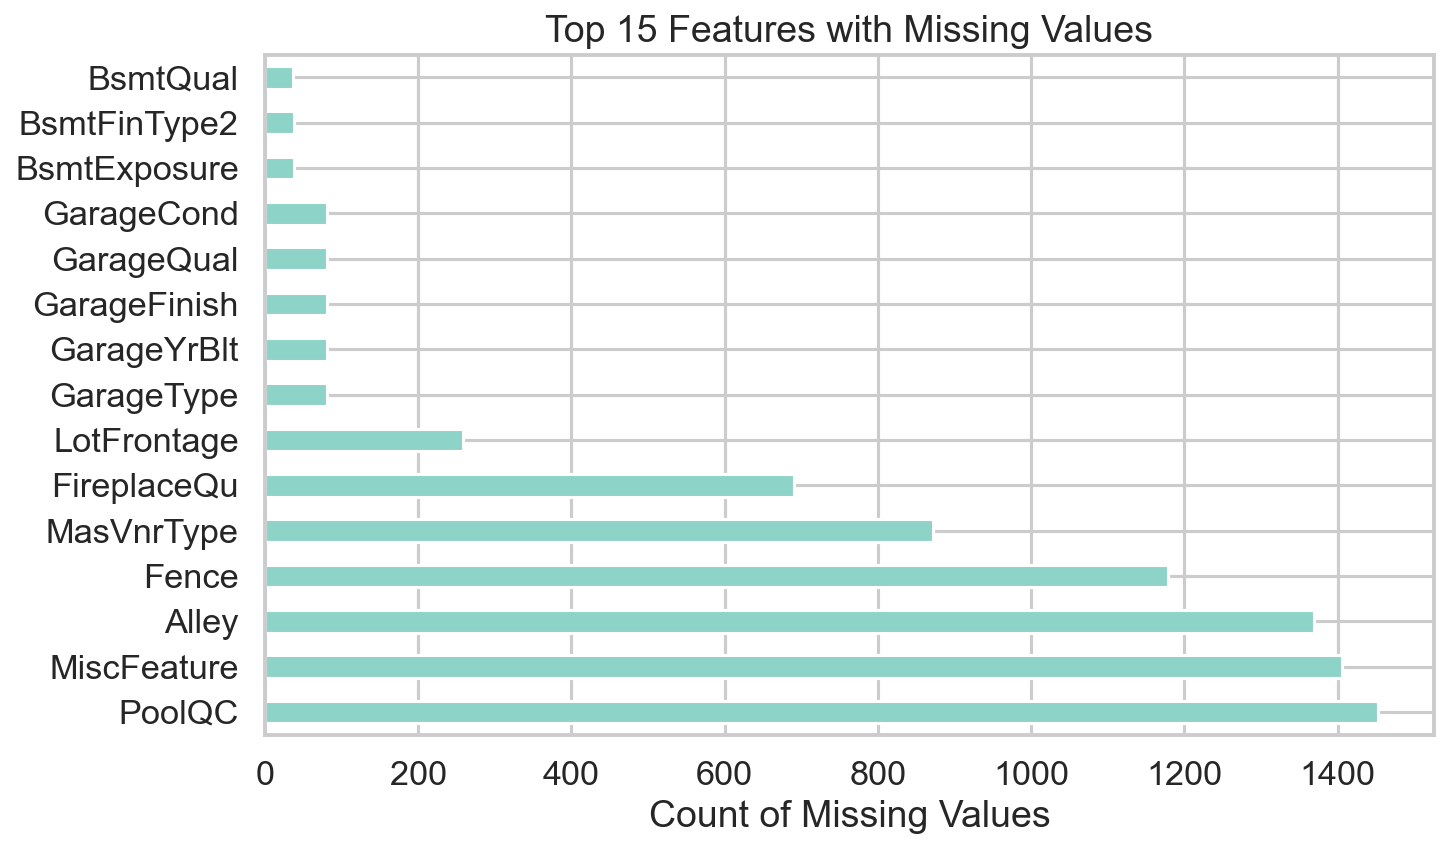

In [72]:
# Missing values analysis
missing = train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

print(f"Features with missing values: {len(missing)}")
print(f"\nTop 10 features with most missing data:")
print(missing.head(10))

# Visualize
plt.figure(figsize=(10, 6))
missing.head(15).plot(kind='barh')
plt.title('Top 15 Features with Missing Values')
plt.xlabel('Count of Missing Values')
plt.tight_layout()
plt.show()

high missing rate in misc Features and pool (about 90 percent missing)  meaning these services aren't much available

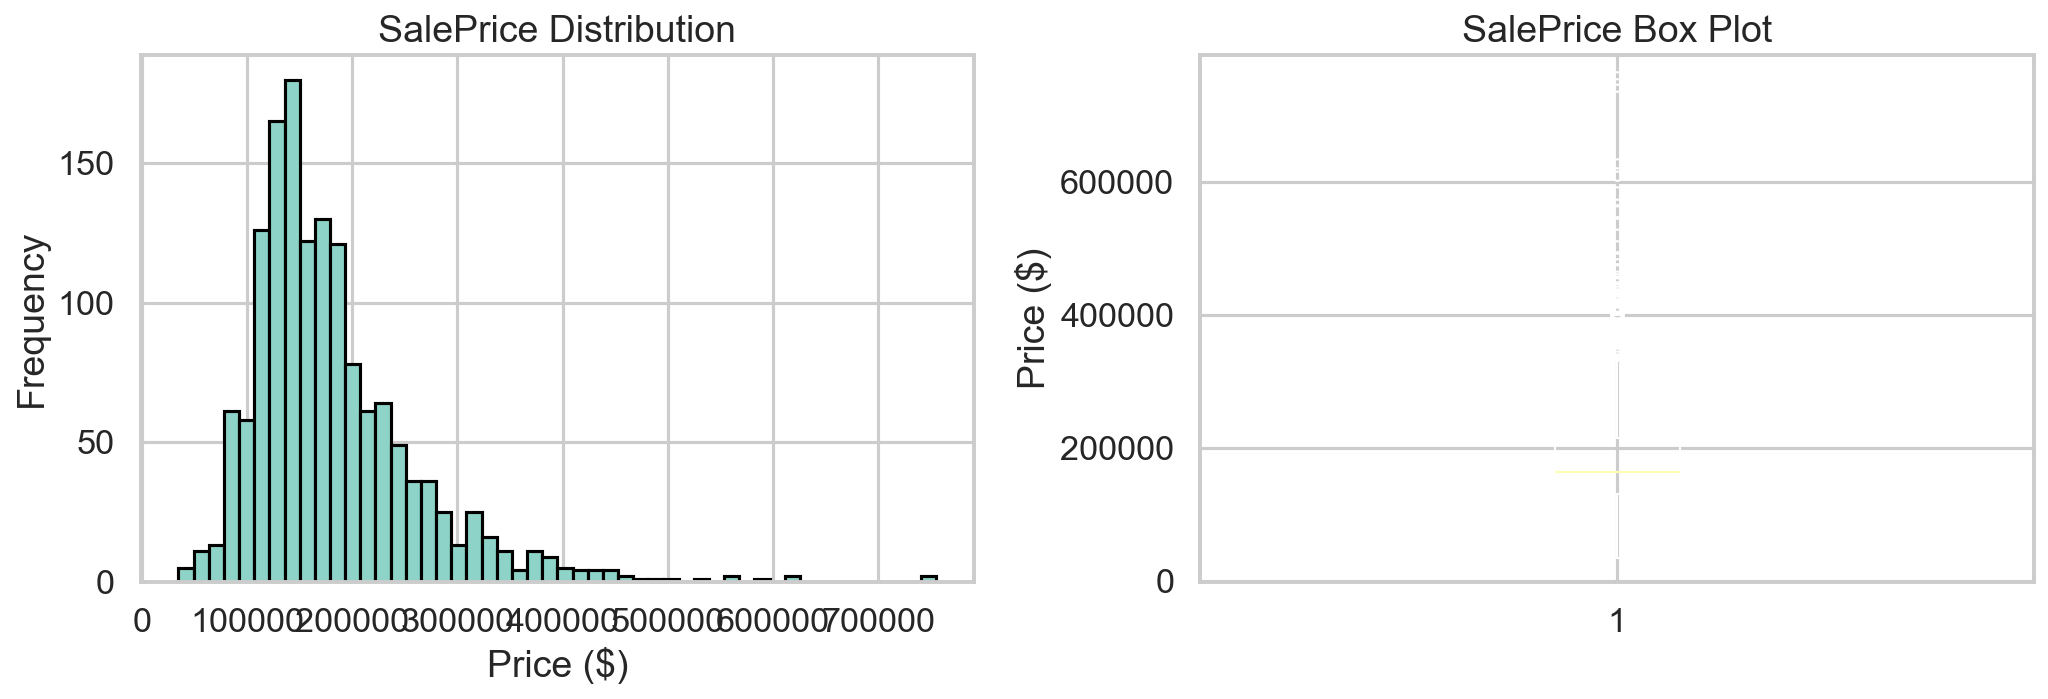

Skewness: 1.88


In [73]:
# SalePrice distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(train['SalePrice'], bins=50, edgecolor='black')
axes[0].set_title('SalePrice Distribution')
axes[0].set_xlabel('Price ($)')
axes[0].set_ylabel('Frequency')

# Box plot
axes[1].boxplot(train['SalePrice'])
axes[1].set_title('SalePrice Box Plot')
axes[1].set_ylabel('Price ($)')

plt.tight_layout()
plt.show()

print(f"Skewness: {train['SalePrice'].skew():.2f}")

Highly rightskewed. High-Price properties get in anomalies. as data is skewed heavily (about 2) suggests log transformation is required.

Top 10 features most correlated with SalePrice:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64


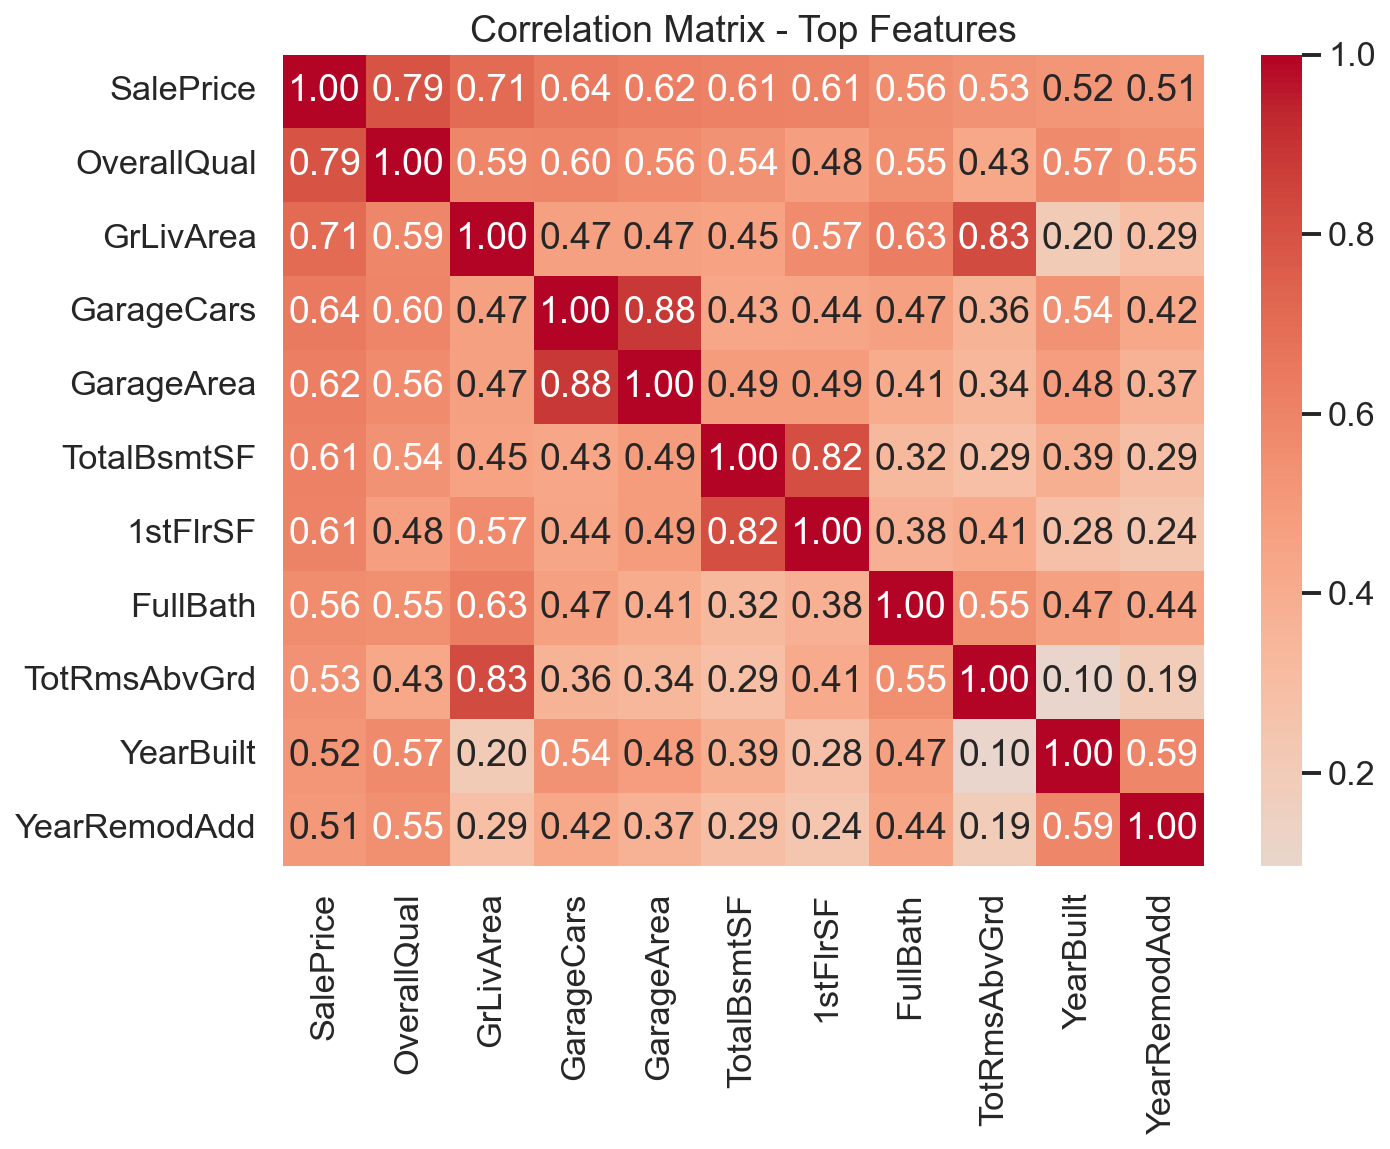

In [74]:
# Select numerical features only
numerical_features = train.select_dtypes(include=[np.number]).columns.tolist()
numerical_features.remove('Id')  # Remove ID column

# Correlation with SalePrice
correlations = train[numerical_features].corr()['SalePrice'].sort_values(ascending=False)

print("Top 10 features most correlated with SalePrice:")
print(correlations.head(11))  # 11 because SalePrice itself is included

# Heatmap of top correlated features
top_features = correlations.head(11).index
plt.figure(figsize=(10, 8))
sns.heatmap(train[top_features].corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix - Top Features')
plt.tight_layout()
plt.show()

Top 10 POSITIVE correlations with SalePrice:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

Top 10 NEGATIVE correlations with SalePrice:
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

Top 10 by ABSOLUTE correlation strength:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.

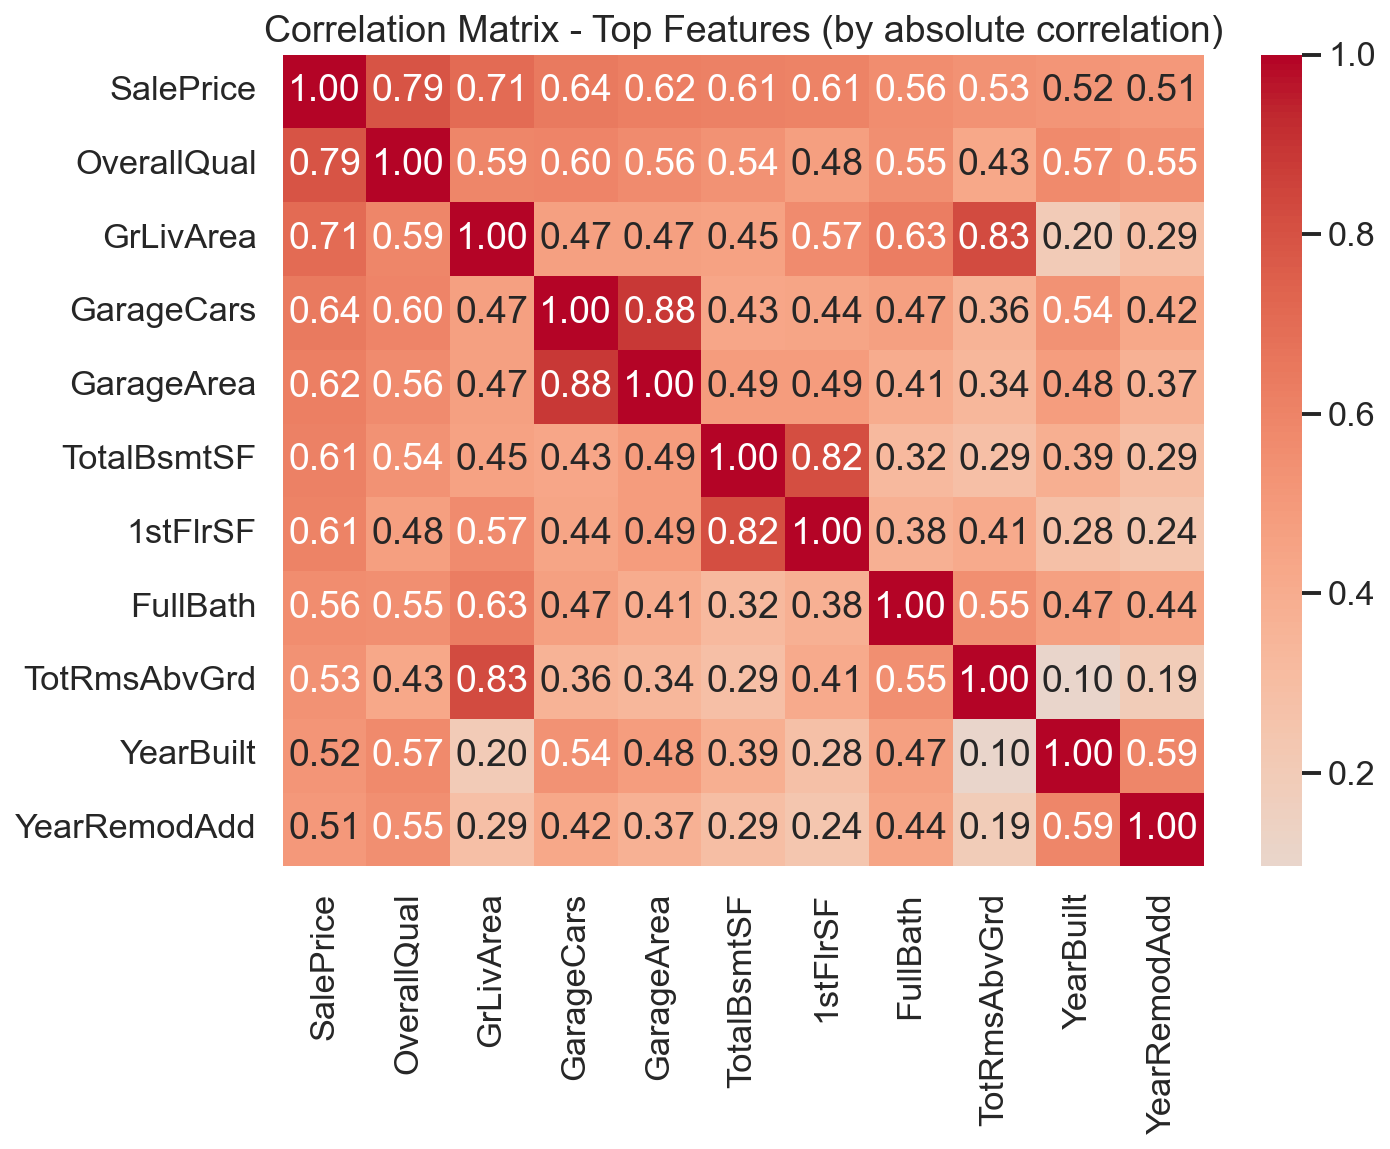

In [75]:
# Correlation with SalePrice
correlations = train[numerical_features].corr()['SalePrice'].sort_values(ascending=False)

print("Top 10 POSITIVE correlations with SalePrice:")
print(correlations.head(11))

print("\nTop 10 NEGATIVE correlations with SalePrice:")
print(correlations.tail(10))

print("\nTop 10 by ABSOLUTE correlation strength:")
abs_corr = correlations.abs().sort_values(ascending=False)
print(abs_corr.head(11))

# Visualize top absolute correlations
top_features = abs_corr.head(11).index
plt.figure(figsize=(10, 8))
sns.heatmap(train[top_features].corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix - Top Features (by absolute correlation)')
plt.tight_layout()
plt.show()

In [76]:
# Selected features for modeling (avoiding multicollinearity)
selected_features = [
    'OverallQual',    # Quality (0.79)
    'GrLivArea',      # Living area (0.71)
    'GarageCars',     # Garage (0.64) - chosen over GarageArea
    'TotalBsmtSF',    # Basement (0.61)
    '1stFlrSF',       # First floor (0.61)
    'FullBath',       # Bathrooms (0.56)
    'YearBuilt'       # Age (0.52)
]

# Check for missing values in selected features
print("Missing values in selected features:")
print(train[selected_features].isnull().sum())

# Basic stats
print("\nSelected features summary:")
train[selected_features].describe()

Missing values in selected features:
OverallQual    0
GrLivArea      0
GarageCars     0
TotalBsmtSF    0
1stFlrSF       0
FullBath       0
YearBuilt      0
dtype: int64

Selected features summary:


OverallQual    GrLivArea   GarageCars  TotalBsmtSF     1stFlrSF  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean      6.099315  1515.463699     1.767123  1057.429452  1162.626712   
std       1.382997   525.480383     0.747315   438.705324   386.587738   
min       1.000000   334.000000     0.000000     0.000000   334.000000   
25%       5.000000  1129.500000     1.000000   795.750000   882.000000   
50%       6.000000  1464.000000     2.000000   991.500000  1087.000000   
75%       7.000000  1776.750000     2.000000  1298.250000  1391.250000   
max      10.000000  5642.000000     4.000000  6110.000000  4692.000000   

          FullBath    YearBuilt  
count  1460.000000  1460.000000  
mean      1.565068  1971.267808  
std       0.550916    30.202904  
min       0.000000  1872.000000  
25%       1.000000  1954.000000  
50%       2.000000  1973.000000  
75%       2.000000  2000.000000  
max       3.000000  2010.000000

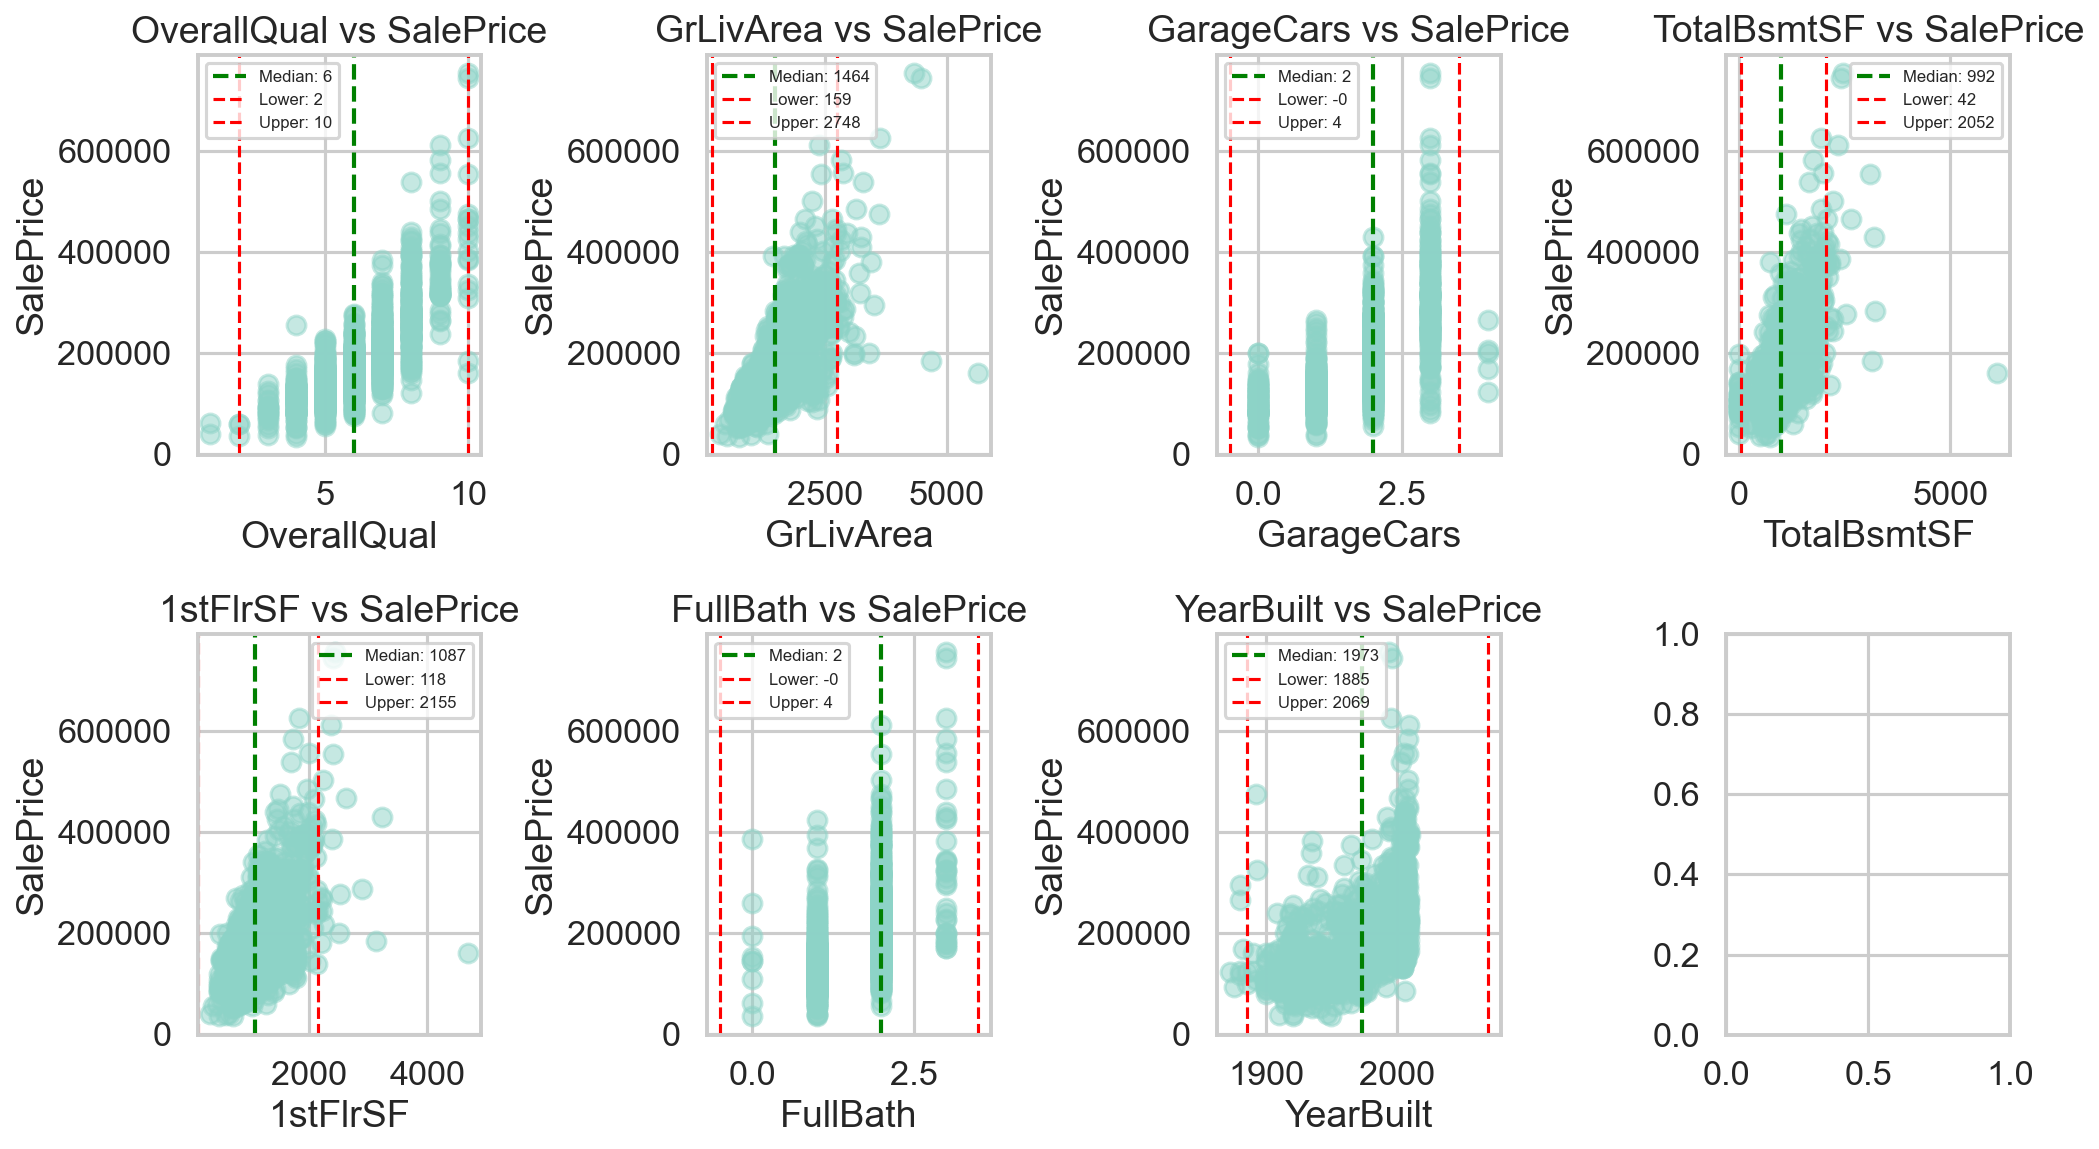


Potential outliers (GrLivArea > 4000 with low price):
      GrLivArea  SalePrice
523        4676     184750
1298       5642     160000


In [77]:
# Visualize outliers with threshold lines
fig, axes = plt.subplots(2, 4, figsize=(14, 8))
axes = axes.flatten()

for idx, feature in enumerate(selected_features):
    ax = axes[idx]

    # Scatter plot
    ax.scatter(train[feature], train['SalePrice'], alpha=0.5)

    # Calculate IQR bounds for outlier detection
    Q1 = train[feature].quantile(0.25)
    Q3 = train[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    median = train[feature].median()

    # Draw threshold lines
    ax.axvline(median, color='green', linestyle='--', linewidth=2, label=f'Median: {median:.0f}')
    ax.axvline(lower_bound, color='red', linestyle='--', linewidth=1.5, label=f'Lower: {lower_bound:.0f}')
    ax.axvline(upper_bound, color='red', linestyle='--', linewidth=1.5, label=f'Upper: {upper_bound:.0f}')

    ax.set_xlabel(feature)
    ax.set_ylabel('SalePrice')
    ax.set_title(f'{feature} vs SalePrice')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

# Identify extreme outliers
print("\nPotential outliers (GrLivArea > 4000 with low price):")
outliers = train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)]
print(outliers[['GrLivArea', 'SalePrice']])

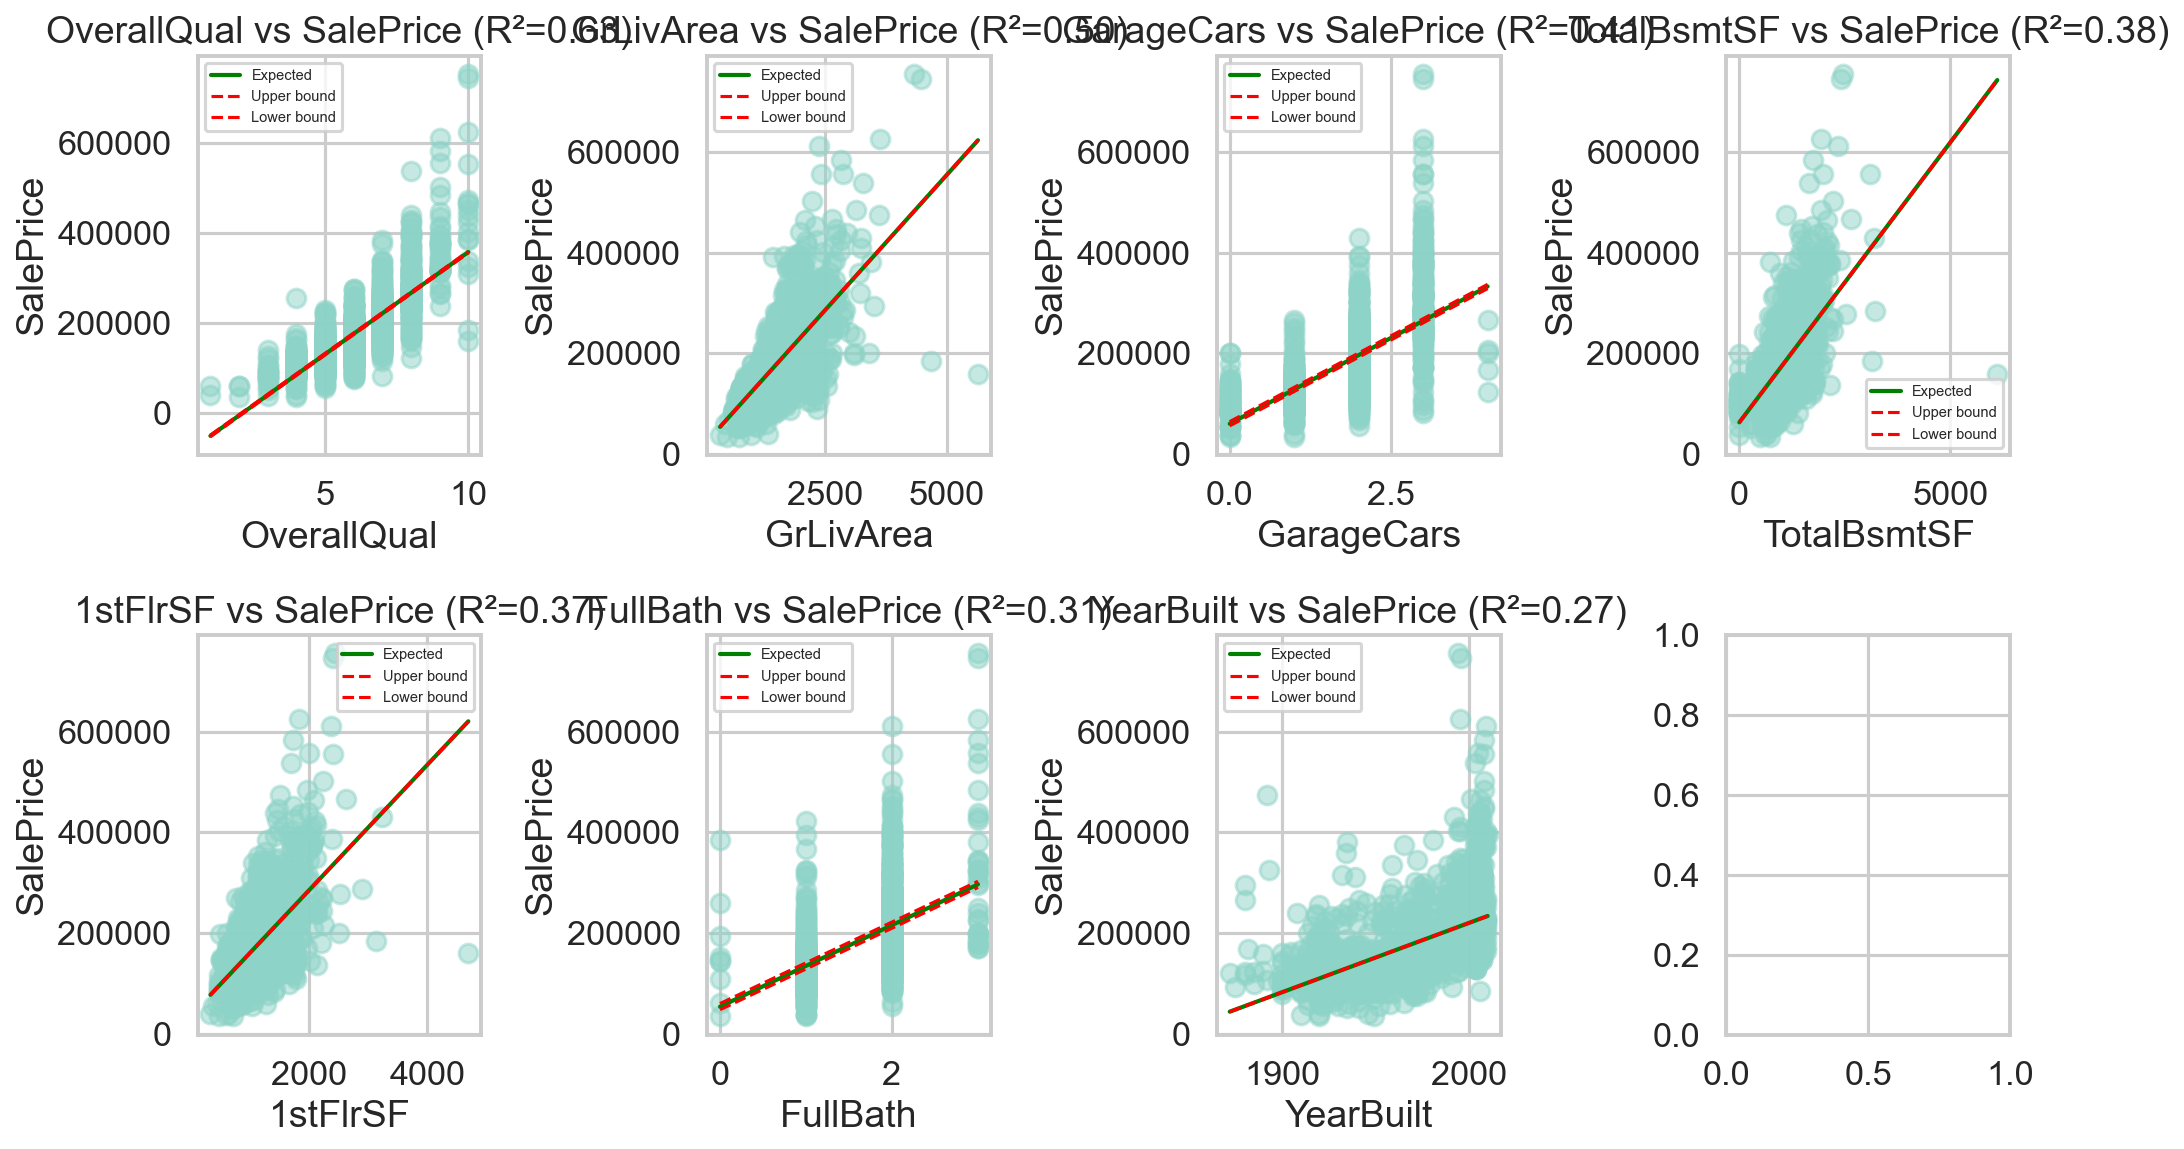


Outliers beyond prediction bounds:
      GrLivArea  SalePrice
523        4676     184750
1298       5642     160000


In [78]:
from scipy import stats

# Visualize with regression lines and confidence intervals
fig, axes = plt.subplots(2, 4, figsize=(14, 8))
axes = axes.flatten()

for idx, feature in enumerate(selected_features):
    ax = axes[idx]

    x = train[feature].values
    y = train['SalePrice'].values

    # Scatter plot
    ax.scatter(x, y, alpha=0.5)

    # Linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Generate regression line
    x_line = np.linspace(x.min(), x.max(), 100)
    y_pred = slope * x_line + intercept

    # Calculate prediction interval (95% confidence)
    predict_std = np.sqrt(std_err**2 * (1 + 1/len(x)))
    margin = 1.96 * predict_std * np.sqrt(1 + (x_line - x.mean())**2 / np.sum((x - x.mean())**2))

    # Plot lines
    ax.plot(x_line, y_pred, 'g-', linewidth=2, label='Expected')
    ax.plot(x_line, y_pred + margin, 'r--', linewidth=1.5, label='Upper bound')
    ax.plot(x_line, y_pred - margin, 'r--', linewidth=1.5, label='Lower bound')

    ax.set_xlabel(feature)
    ax.set_ylabel('SalePrice')
    ax.set_title(f'{feature} vs SalePrice (R²={r_value**2:.2f})')
    ax.legend(fontsize=7)

plt.tight_layout()
plt.show()

print("\nOutliers beyond prediction bounds:")
outliers = train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)]
print(outliers[['GrLivArea', 'SalePrice']])

Original: 1460 samples
After removing outliers: 1458 samples

Skewness before: 1.88
Skewness after log: 0.12


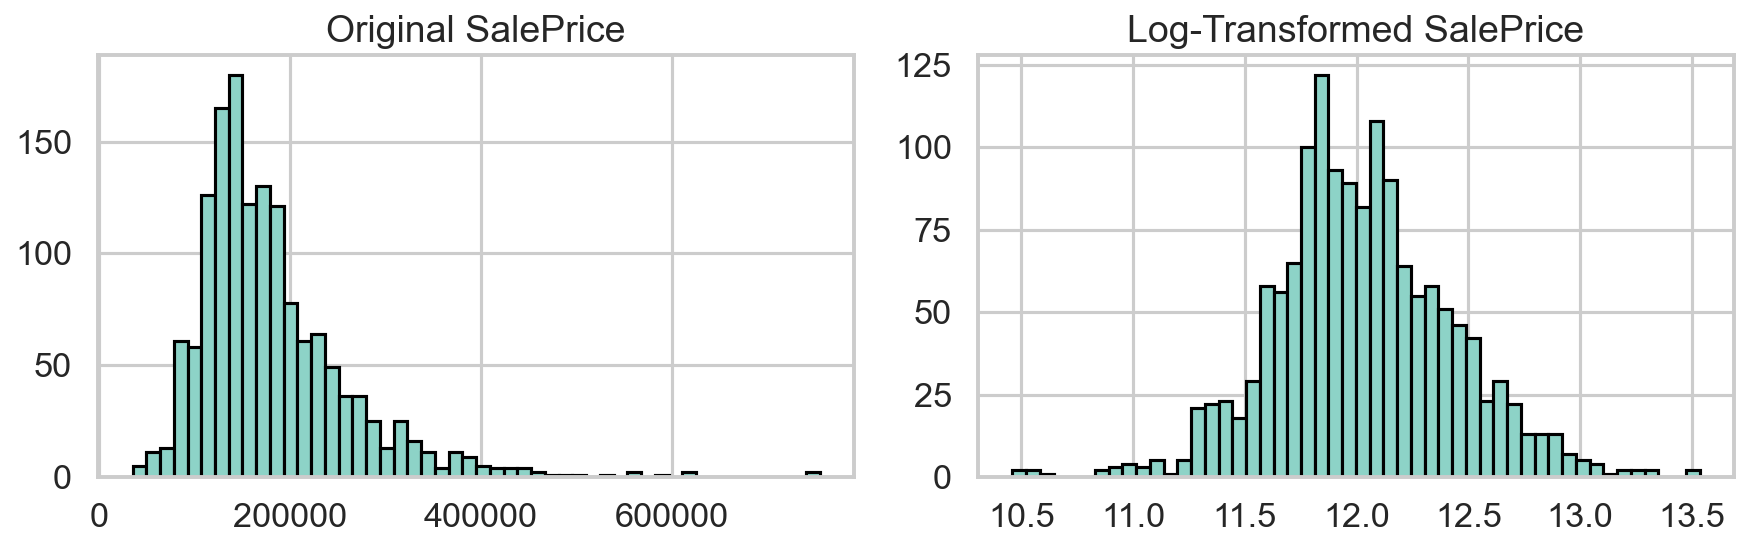


Final shapes: X=(1458, 7), y=(1458,)


In [79]:
# Remove identified outliers
outlier_indices = [523, 1298]
train_clean = train.drop(outlier_indices).copy()

print(f"Original: {len(train)} samples")
print(f"After removing outliers: {len(train_clean)} samples")

# Apply log transformation to SalePrice
train_clean['SalePrice_log'] = np.log(train_clean['SalePrice'])

# Compare skewness
print(f"\nSkewness before: {train['SalePrice'].skew():.2f}")
print(f"Skewness after log: {train_clean['SalePrice_log'].skew():.2f}")

# Visualize improvement
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(train['SalePrice'], bins=50, edgecolor='black')
axes[0].set_title('Original SalePrice')
axes[1].hist(train_clean['SalePrice_log'], bins=50, edgecolor='black')
axes[1].set_title('Log-Transformed SalePrice')
plt.tight_layout()
plt.show()

# Final dataset
X = train_clean[selected_features].values
y = train_clean['SalePrice_log'].values

print(f"\nFinal shapes: X={X.shape}, y={y.shape}")

here log transformation for skewness is used to reduce the skewness and find ultimate trend

In [80]:
from sklearn.model_selection import train_test_split

# Split: 75% train, 15% validation, 10% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.167, random_state=42)
# 0.167 of 90% ≈ 15% of total

print(f"Train: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Val:   {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test:  {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Feature scaling (standardization: mean=0, std=1)
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)

X_train_scaled = (X_train - X_mean) / X_std
X_val_scaled = (X_val - X_mean) / X_std
X_test_scaled = (X_test - X_mean) / X_std

print(f"\nScaled train - Mean: {X_train_scaled.mean(axis=0).round(3)}")
print(f"Scaled train - Std: {X_train_scaled.std(axis=0).round(3)}")

print("\n✓ Days 1-2 Complete! Data ready for Week 2 modeling.")

Train: 1092 samples (74.9%)
Val:   220 samples (15.1%)
Test:  146 samples (10.0%)

Scaled train - Mean: [ 0.  0.  0.  0. -0. -0.  0.]
Scaled train - Std: [1. 1. 1. 1. 1. 1. 1.]

✓ Days 1-2 Complete! Data ready for Week 2 modeling.


In [81]:
# Import the class
import sys
sys.path.append('../src')
from linear_regression import LinearRegressionScratch

print("✓ LinearRegressionScratch imported successfully")


✓ LinearRegressionScratch imported successfully


In [82]:
# Cell 10: Train the model
model = LinearRegressionScratch(learning_rate=0.01, n_iterations=1000)

print("Training Linear Regression from scratch...")
print("-" * 50)
model.fit(X_train_scaled, y_train)

print("\n" + "="*50)
print("✓ Training complete!")
print(f"Final weights: {model.weights.round(3)}")
print(f"Final bias: {model.bias:.3f}")

Training Linear Regression from scratch...
--------------------------------------------------
Iteration 100/1000, Cost: 9.9059
Iteration 200/1000, Cost: 1.3382
Iteration 300/1000, Cost: 0.1900
Iteration 400/1000, Cost: 0.0360
Iteration 500/1000, Cost: 0.0153
Iteration 600/1000, Cost: 0.0124
Iteration 700/1000, Cost: 0.0120
Iteration 800/1000, Cost: 0.0120
Iteration 900/1000, Cost: 0.0119
Iteration 1000/1000, Cost: 0.0119

✓ Training complete!
Final weights: [ 0.131  0.143  0.051  0.066  0.014 -0.017  0.079]
Final bias: 12.030


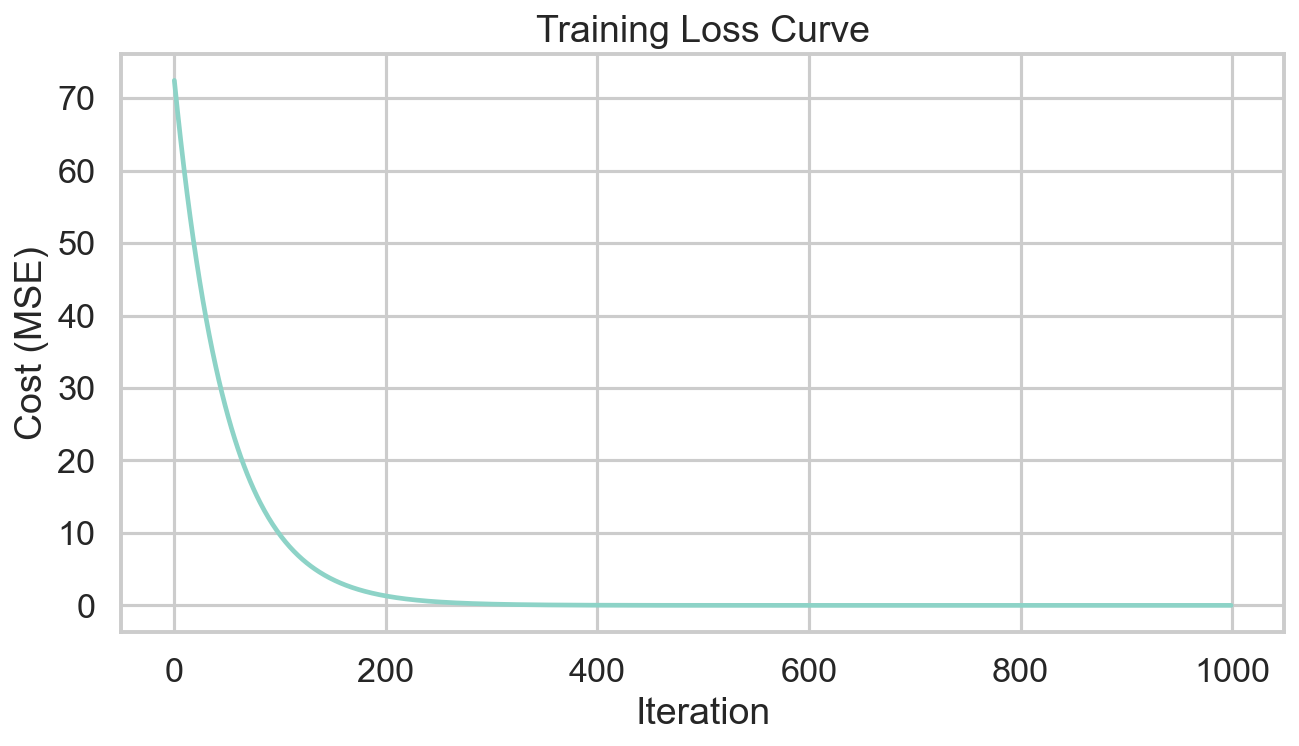

Initial cost: 72.4410
Final cost: 0.0119
Cost reduction: 99.98%


In [83]:
# Plot cost history
plt.figure(figsize=(10, 5))
plt.plot(model.cost_history)
plt.title('Training Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Cost (MSE)')
plt.grid(True)
plt.show()

print(f"Initial cost: {model.cost_history[0]:.4f}")
print(f"Final cost: {model.cost_history[-1]:.4f}")
print(f"Cost reduction: {(1 - model.cost_history[-1]/model.cost_history[0])*100:.2f}%")


In [84]:
# Make predictions
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)

# Calculate R² scores
train_r2 = model.score(X_train_scaled, y_train)
val_r2 = model.score(X_val_scaled, y_val)

print(f"Training R²: {train_r2:.4f}")
print(f"Validation R²: {val_r2:.4f}")
print(f"Difference: {abs(train_r2 - val_r2):.4f}")

if abs(train_r2 - val_r2) < 0.05:
    print("✓ Good generalization - no overfitting")
else:
    print("⚠ Possible overfitting")

Training R²: 0.8449
Validation R²: 0.8484
Difference: 0.0035
✓ Good generalization - no overfitting


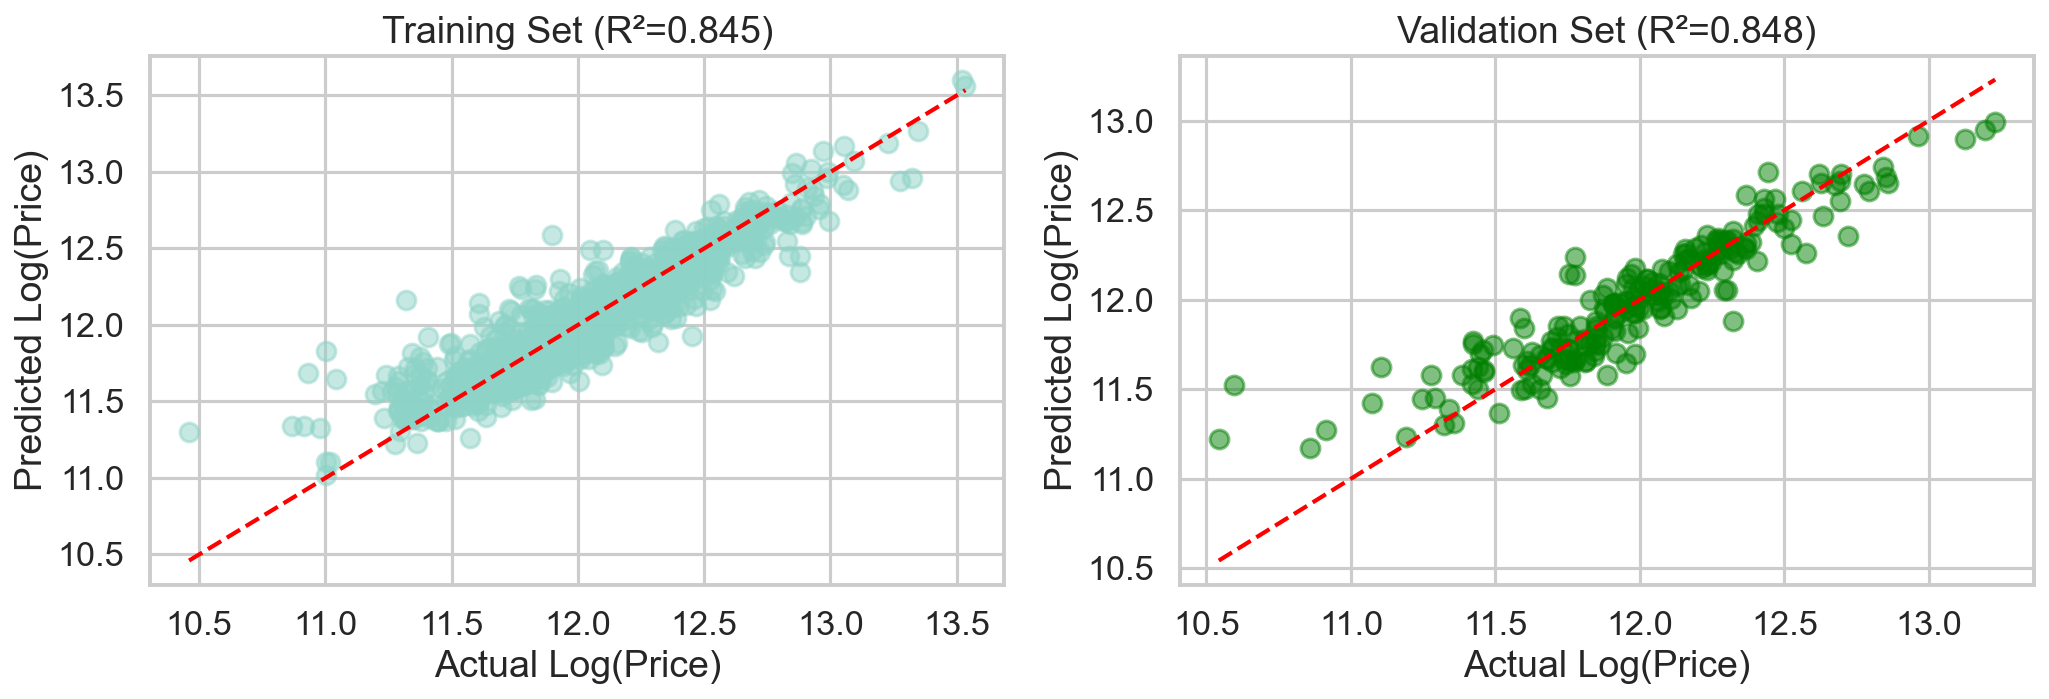

In [85]:
# Plot actual vs predicted
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
axes[0].scatter(y_train, y_train_pred, alpha=0.5)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Log(Price)')
axes[0].set_ylabel('Predicted Log(Price)')
axes[0].set_title(f'Training Set (R²={train_r2:.3f})')
axes[0].grid(True)

# Validation set
axes[1].scatter(y_val, y_val_pred, alpha=0.5, color='green')
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Log(Price)')
axes[1].set_ylabel('Predicted Log(Price)')
axes[1].set_title(f'Validation Set (R²={val_r2:.3f})')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [86]:
# Save results for later comparison
results = {
    'model': 'Linear Regression',
    'train_r2': train_r2,
    'val_r2': val_r2,
    'weights': model.weights,
    'bias': model.bias
}

print("✓ Day 3 Complete! Ready for regularization tomorrow.")

✓ Day 3 Complete! Ready for regularization tomorrow.


In [87]:
# Import new class
from linear_regression import PolynomialRegressionScratch
# Train polynomial model
model_poly = PolynomialRegressionScratch(degree=2)
model_poly.fit(X_train_scaled, y_train)

# Evaluate
train_r2_poly = model_poly.score(X_train_scaled, y_train)
val_r2_poly = model_poly.score(X_val_scaled, y_val)

print(f"\nPolynomial Model (degree=2):")
print(f"Training R²: {train_r2_poly:.4f}")
print(f"Validation R²: {val_r2_poly:.4f}")

✓ Fitted with 35 polynomial features

Polynomial Model (degree=2):
Training R²: 0.8575
Validation R²: 0.8420


In [88]:
# Evaluate polynomial model
train_r2_poly = model_poly.score(X_train_scaled, y_train)
val_r2_poly = model_poly.score(X_val_scaled, y_val)

print(f"{'='*50}")
print("MODEL COMPARISON:")
print(f"{'='*50}")
print(f"\nLinear Regression:")
print(f"  Training R²:   {train_r2:.4f}")
print(f"  Validation R²: {val_r2:.4f}")
print(f"  Gap:           {abs(train_r2 - val_r2):.4f}")

print(f"\nPolynomial Regression (degree=2):")
print(f"  Training R²:   {train_r2_poly:.4f}")
print(f"  Validation R²: {val_r2_poly:.4f}")
print(f"  Gap:           {abs(train_r2_poly - val_r2_poly):.4f}")

print(f"\nConclusion:")
if val_r2 > val_r2_poly:
    print("✓ Linear model generalizes better")
else:
    print("✓ Polynomial model performs better")

MODEL COMPARISON:

Linear Regression:
  Training R²:   0.8449
  Validation R²: 0.8484
  Gap:           0.0035

Polynomial Regression (degree=2):
  Training R²:   0.8575
  Validation R²: 0.8420
  Gap:           0.0155

Conclusion:
✓ Linear model generalizes better


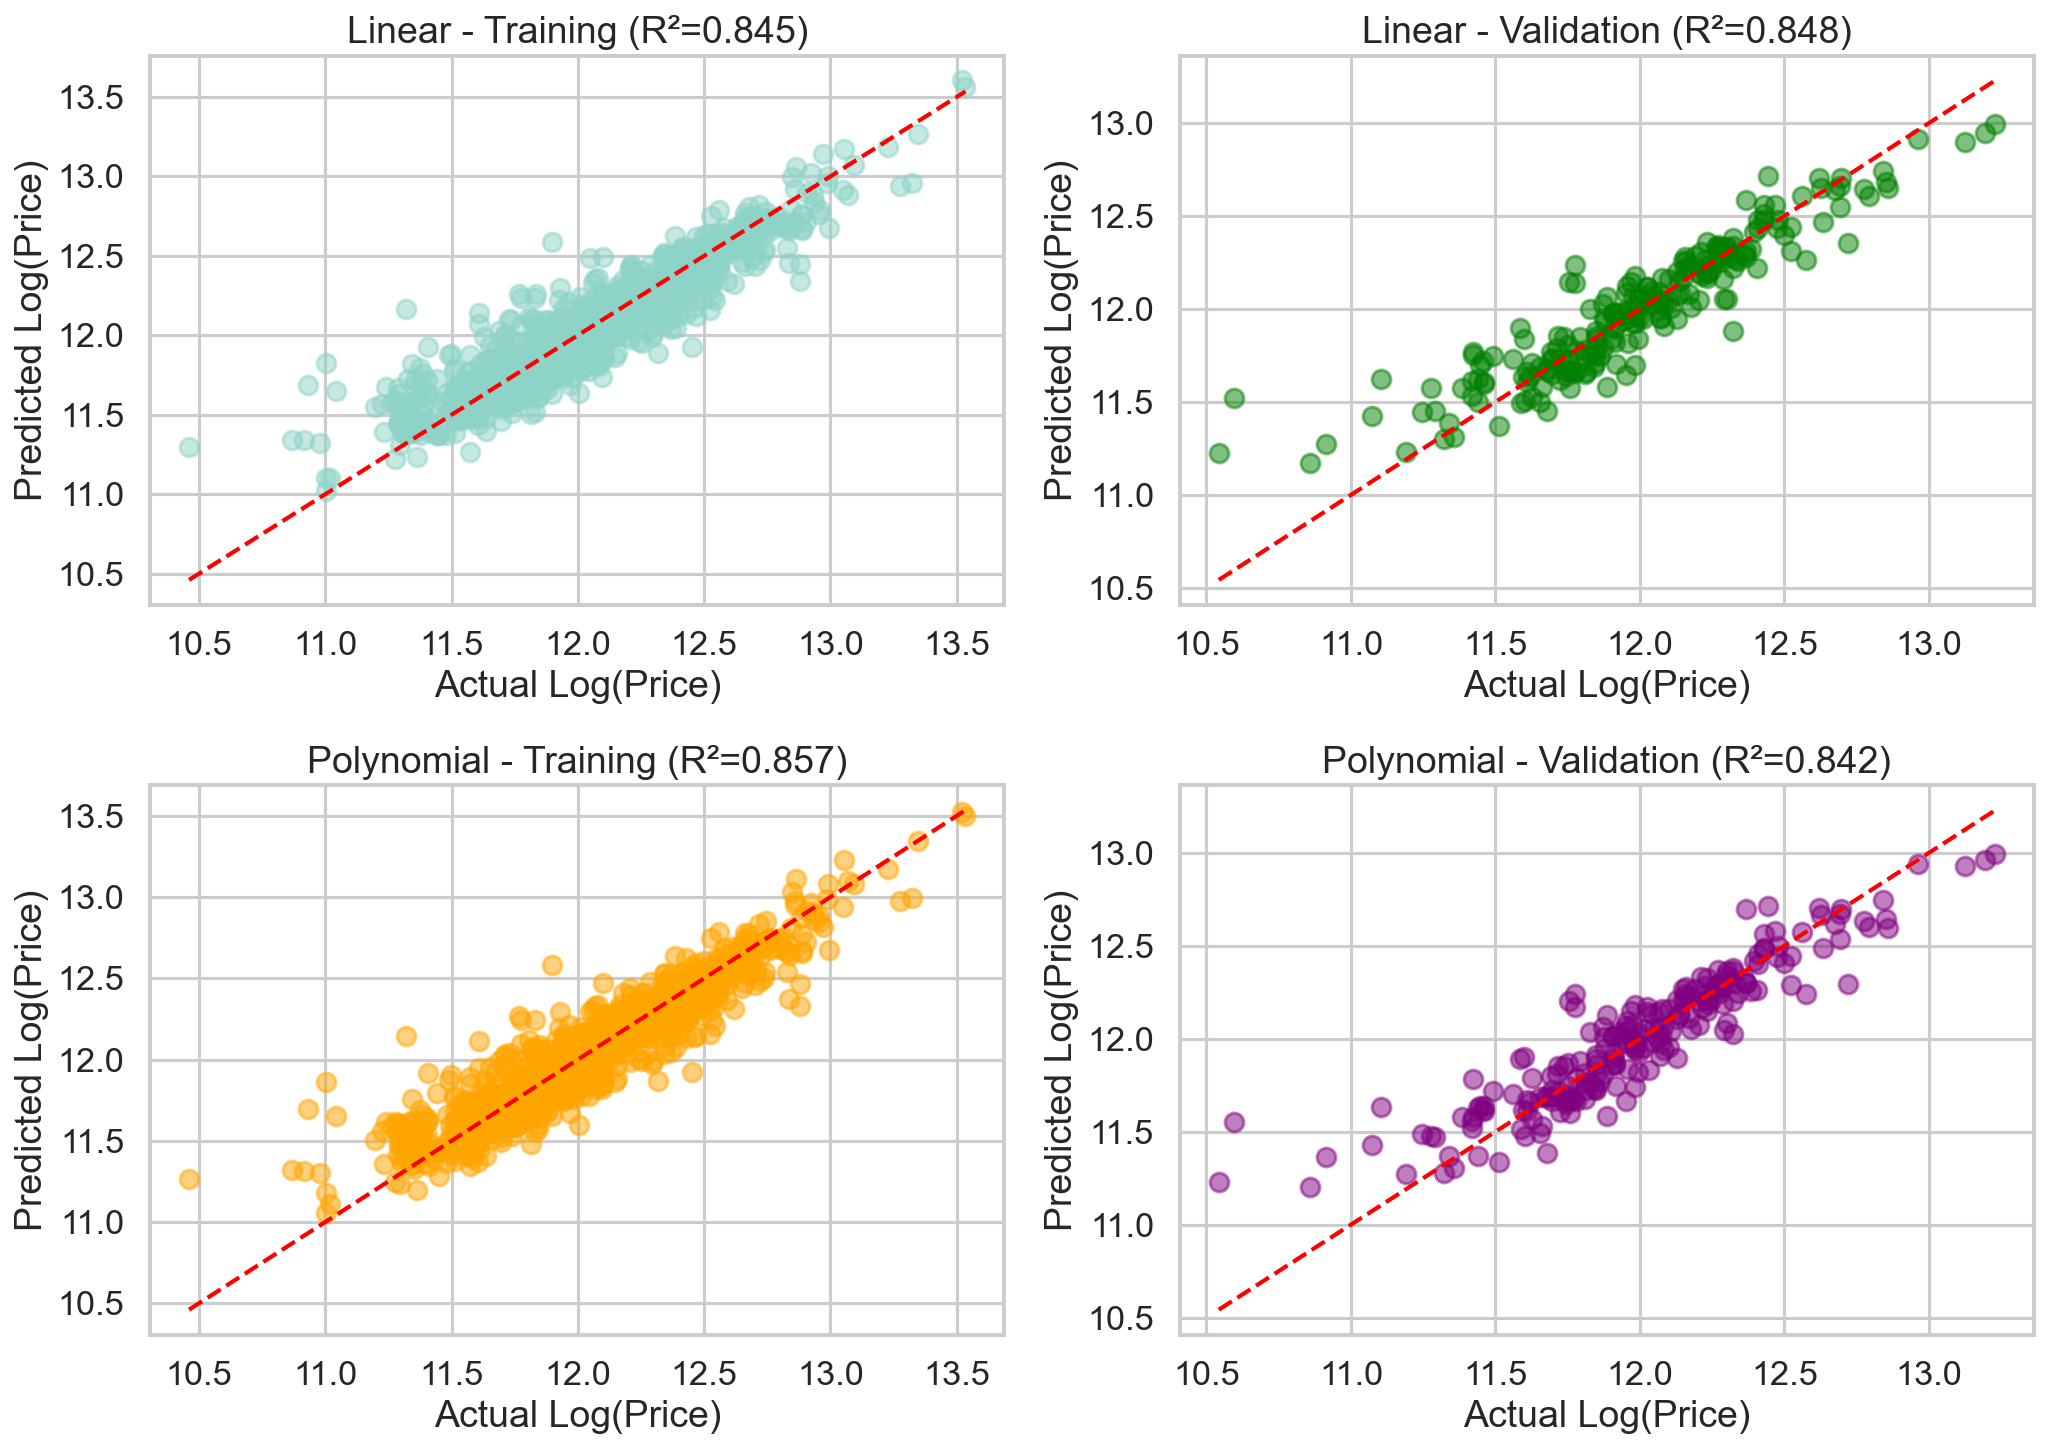

In [89]:
# Plot actual vs predicted comparison
y_train_pred_poly = model_poly.predict(X_train_scaled)
y_val_pred_poly = model_poly.predict(X_val_scaled)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Linear - Training
axes[0, 0].scatter(y_train, y_train_pred, alpha=0.5)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Log(Price)')
axes[0, 0].set_ylabel('Predicted Log(Price)')
axes[0, 0].set_title(f'Linear - Training (R²={train_r2:.3f})')
axes[0, 0].grid(True)

# Linear - Validation
axes[0, 1].scatter(y_val, y_val_pred, alpha=0.5, color='green')
axes[0, 1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Log(Price)')
axes[0, 1].set_ylabel('Predicted Log(Price)')
axes[0, 1].set_title(f'Linear - Validation (R²={val_r2:.3f})')
axes[0, 1].grid(True)

# Polynomial - Training
axes[1, 0].scatter(y_train, y_train_pred_poly, alpha=0.5, color='orange')
axes[1, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Actual Log(Price)')
axes[1, 0].set_ylabel('Predicted Log(Price)')
axes[1, 0].set_title(f'Polynomial - Training (R²={train_r2_poly:.3f})')
axes[1, 0].grid(True)

# Polynomial - Validation
axes[1, 1].scatter(y_val, y_val_pred_poly, alpha=0.5, color='purple')
axes[1, 1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Actual Log(Price)')
axes[1, 1].set_ylabel('Predicted Log(Price)')
axes[1, 1].set_title(f'Polynomial - Validation (R²={val_r2_poly:.3f})')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


In [90]:
# Test different polynomial degrees and calculate BIC
from scipy.stats import chi2

degrees = [1, 2, 3, 4, 5]
results = []

for deg in degrees:
    if deg == 1:
        # Use linear model
        y_pred = model.predict(X_train_scaled)
        n_params = X_train_scaled.shape[1] + 1  # weights + bias
    else:
        # Use polynomial model
        model_deg = PolynomialRegressionScratch(degree=deg)
        model_deg.fit(X_train_scaled, y_train)
        y_pred = model_deg.predict(X_train_scaled)
        n_params = model_deg.weights.shape[0] + 1  # weights + bias

    # Calculate metrics
    n_samples = len(y_train)
    rss = np.sum((y_train - y_pred) ** 2)

    # BIC = n*ln(RSS/n) + k*ln(n)
    # where n=samples, k=parameters, RSS=residual sum of squares
    bic = n_samples * np.log(rss / n_samples) + n_params * np.log(n_samples)

    # AIC = 2k + n*ln(RSS/n)
    aic = 2 * n_params + n_samples * np.log(rss / n_samples)

    # R² on validation
    if deg == 1:
        val_r2_deg = model.score(X_val_scaled, y_val)
    else:
        val_r2_deg = model_deg.score(X_val_scaled, y_val)

    results.append({
        'degree': deg,
        'n_features': n_params - 1,
        'BIC': bic,
        'AIC': aic,
        'val_r2': val_r2_deg
    })

    print(f"Degree {deg}: Features={n_params-1:2d}, BIC={bic:.2f}, AIC={aic:.2f}, Val R²={val_r2_deg:.4f}")

# Find best model
df_results = pd.DataFrame(results)
best_bic_idx = df_results['BIC'].idxmin()
best_aic_idx = df_results['AIC'].idxmin()
best_r2_idx = df_results['val_r2'].idxmax()

print(f"\n{'='*60}")
print(f"Best by BIC: Degree {df_results.loc[best_bic_idx, 'degree']} (BIC={df_results.loc[best_bic_idx, 'BIC']:.2f})")
print(f"Best by AIC: Degree {df_results.loc[best_aic_idx, 'degree']} (AIC={df_results.loc[best_aic_idx, 'AIC']:.2f})")
print(f"Best by Val R²: Degree {df_results.loc[best_r2_idx, 'degree']} (R²={df_results.loc[best_r2_idx, 'val_r2']:.4f})")

Degree 1: Features= 7, BIC=-4023.50, AIC=-4063.46, Val R²=0.8484
✓ Fitted with 35 polynomial features
Degree 2: Features=35, BIC=-3920.13, AIC=-4099.98, Val R²=0.8420
✓ Fitted with 119 polynomial features
Degree 3: Features=119, BIC=-3452.07, AIC=-4051.56, Val R²=0.8333
✓ Fitted with 329 polynomial features
Degree 4: Features=329, BIC=10226.71, AIC=8578.11, Val R²=-5268312033279.0977
✓ Fitted with 791 polynomial features
Degree 5: Features=791, BIC=21148.82, AIC=17192.17, Val R²=-37536221346545323212800.0000

Best by BIC: Degree 1 (BIC=-4023.50)
Best by AIC: Degree 2 (AIC=-4099.98)
Best by Val R²: Degree 1 (R²=0.8484)


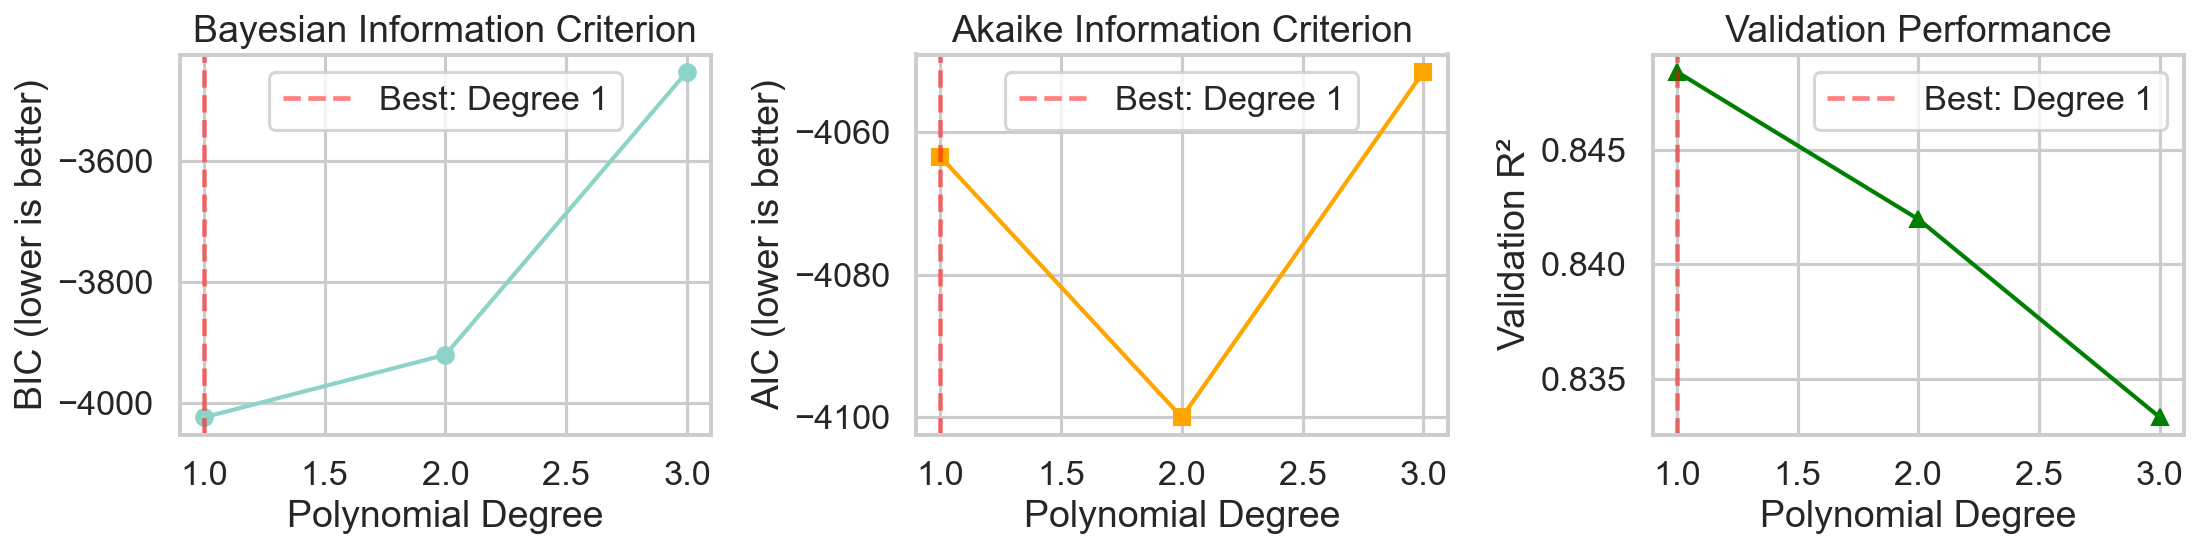


✓ Conclusion: Linear model (degree=1) is optimal
  - Lowest BIC/AIC
  - Best validation R²
  - Higher degrees overfit


In [91]:
# Visualize BIC/AIC comparison (exclude degree 4-5 due to explosion)
df_plot = df_results[df_results['degree'] <= 3].copy()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# BIC
axes[0].plot(df_plot['degree'], df_plot['BIC'], marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Polynomial Degree')
axes[0].set_ylabel('BIC (lower is better)')
axes[0].set_title('Bayesian Information Criterion')
axes[0].grid(True)
axes[0].axvline(1, color='r', linestyle='--', alpha=0.5, label='Best: Degree 1')
axes[0].legend()

# AIC
axes[1].plot(df_plot['degree'], df_plot['AIC'], marker='s', linewidth=2, markersize=8, color='orange')
axes[1].set_xlabel('Polynomial Degree')
axes[1].set_ylabel('AIC (lower is better)')
axes[1].set_title('Akaike Information Criterion')
axes[1].grid(True)
axes[1].axvline(1, color='r', linestyle='--', alpha=0.5, label='Best: Degree 1')
axes[1].legend()

# Validation R²
axes[2].plot(df_plot['degree'], df_plot['val_r2'], marker='^', linewidth=2, markersize=8, color='green')
axes[2].set_xlabel('Polynomial Degree')
axes[2].set_ylabel('Validation R²')
axes[2].set_title('Validation Performance')
axes[2].grid(True)
axes[2].axvline(1, color='r', linestyle='--', alpha=0.5, label='Best: Degree 1')
axes[2].legend()

plt.tight_layout()
plt.show()

print("\n✓ Conclusion: Linear model (degree=1) is optimal")
print("  - Lowest BIC/AIC")
print("  - Best validation R²")
print("  - Higher degrees overfit")

In [92]:
# Test PolynomialRegressionGradientDescent
from linear_regression import PolynomialRegressionGradientDescent

model_poly_gd = PolynomialRegressionGradientDescent(degree=2, learning_rate=0.06, n_iterations=2000)
model_poly_gd.fit(X_train_scaled, y_train)

# Evaluate
train_r2_gd = model_poly_gd.score(X_train_scaled, y_train)
val_r2_gd = model_poly_gd.score(X_val_scaled, y_val)

print(f"\n{'='*60}")
print("COMPARISON:")
print(f"{'='*60}")
print(f"Polynomial GD:        Train R²={train_r2_gd:.4f}, Val R²={val_r2_gd:.4f}")
print(f"Polynomial Normal Eq: Train R²={train_r2_poly:.4f}, Val R²={val_r2_poly:.4f}")
print(f"Linear:               Train R²={train_r2:.4f}, Val R²={val_r2:.4f}")
print(f"\n✓ Gradient Descent matches Normal Equation: {abs(val_r2_gd - val_r2_poly) < 0.001}")

Iteration 200/2000, Cost: 0.2797
Iteration 400/2000, Cost: 0.0618
Iteration 600/2000, Cost: 0.0288
Iteration 800/2000, Cost: 0.0187
Iteration 1000/2000, Cost: 0.0147
Iteration 1200/2000, Cost: 0.0129
Iteration 1400/2000, Cost: 0.0120
Iteration 1600/2000, Cost: 0.0116
Iteration 1800/2000, Cost: 0.0113
Iteration 2000/2000, Cost: 0.0112
✓ Trained with 35 polynomial features

COMPARISON:
Polynomial GD:        Train R²=0.8547, Val R²=0.8420
Polynomial Normal Eq: Train R²=0.8575, Val R²=0.8420
Linear:               Train R²=0.8449, Val R²=0.8484

✓ Gradient Descent matches Normal Equation: True


In [93]:
# Import Ridge
import sys
sys.path.append('../src')
from linear_regression import RidgeRegressionScratch
# Test multiple alpha values
alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
ridge_results = []

for alpha in alphas:
    model = RidgeRegressionScratch(alpha=alpha)
    model.fit(X_train_scaled, y_train)

    train_r2 = model.score(X_train_scaled, y_train)
    val_r2 = model.score(X_val_scaled, y_val)

    ridge_results.append({
        'alpha': alpha,
        'train_r2': train_r2,
        'val_r2': val_r2,
        'gap': abs(train_r2 - val_r2)
    })

    print(f"Alpha={alpha:6.3f}: Train R²={train_r2:.4f}, Val R²={val_r2:.4f}, Gap={abs(train_r2 - val_r2):.4f}")

# Find best
df_ridge = pd.DataFrame(ridge_results)
best_idx = df_ridge['val_r2'].idxmax()
print(f"\n{'='*60}")
print(f"Best Ridge: alpha={df_ridge.loc[best_idx, 'alpha']}, Val R²={df_ridge.loc[best_idx, 'val_r2']:.4f}")
print(f"Linear:     Val R²={val_r2:.4f}")

✓ Ridge trained with alpha=0.001
Alpha= 0.001: Train R²=0.8451, Val R²=0.8475, Gap=0.0024
✓ Ridge trained with alpha=0.01
Alpha= 0.010: Train R²=0.8451, Val R²=0.8475, Gap=0.0024
✓ Ridge trained with alpha=0.1
Alpha= 0.100: Train R²=0.8451, Val R²=0.8475, Gap=0.0024
✓ Ridge trained with alpha=1.0
Alpha= 1.000: Train R²=0.8451, Val R²=0.8475, Gap=0.0024
✓ Ridge trained with alpha=10.0
Alpha=10.000: Train R²=0.8450, Val R²=0.8476, Gap=0.0026
✓ Ridge trained with alpha=100.0
Alpha=100.000: Train R²=0.8424, Val R²=0.8458, Gap=0.0034

Best Ridge: alpha=10.0, Val R²=0.8476
Linear:     Val R²=0.8458


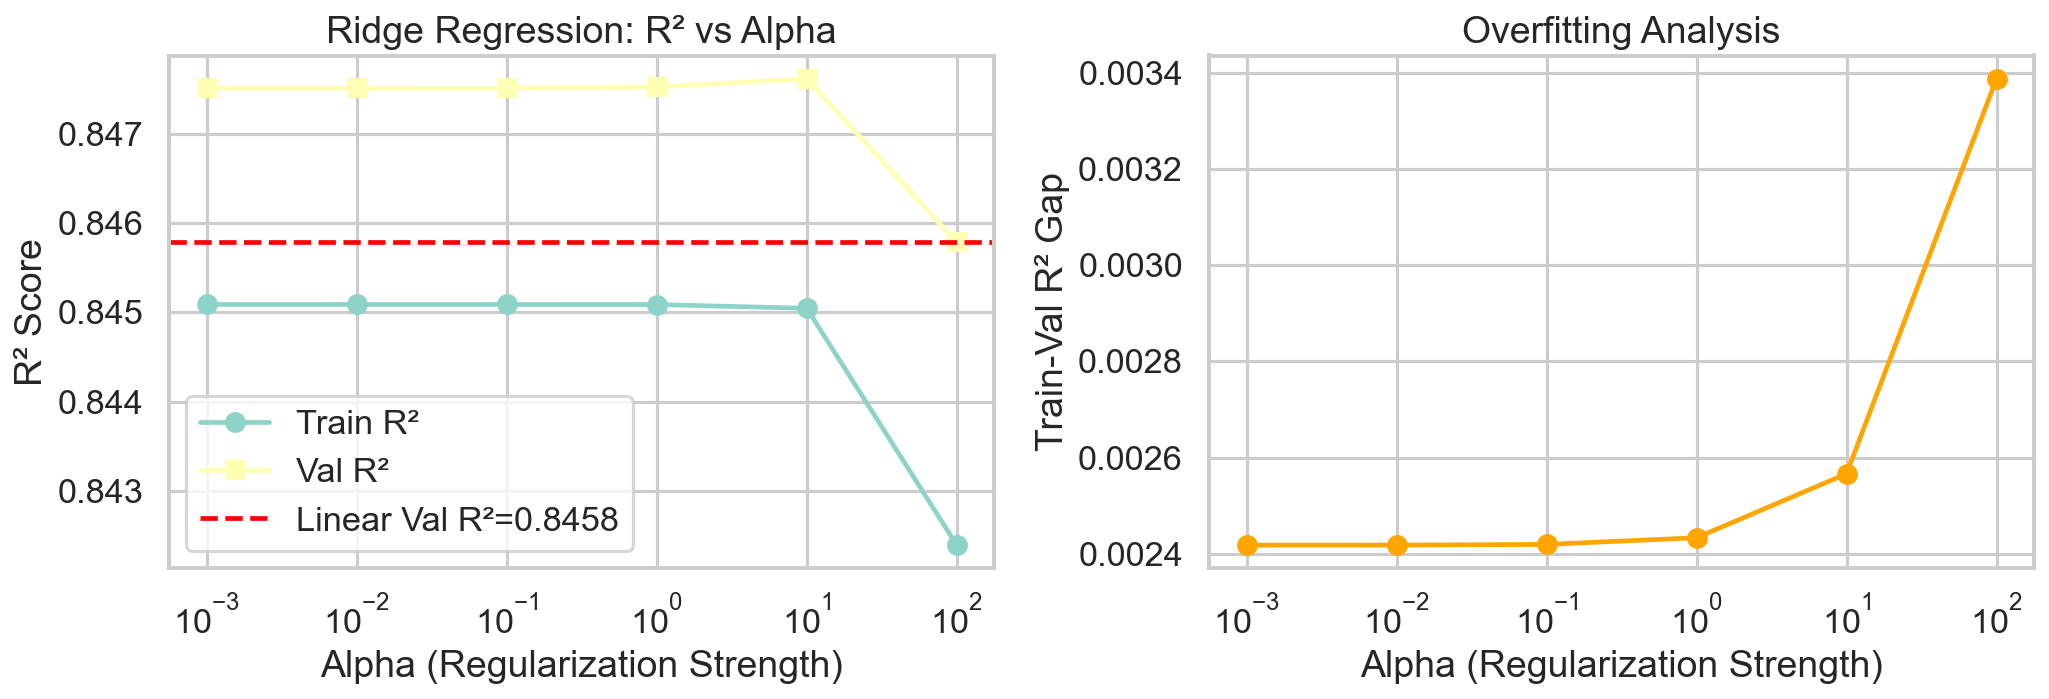


✓ Ridge doesn't improve over linear - model not overfitting


In [94]:
# Plot Ridge performance vs alpha
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² vs alpha
axes[0].semilogx(df_ridge['alpha'], df_ridge['train_r2'], marker='o', label='Train R²')
axes[0].semilogx(df_ridge['alpha'], df_ridge['val_r2'], marker='s', label='Val R²')
axes[0].axhline(val_r2, color='r', linestyle='--', label=f'Linear Val R²={val_r2:.4f}')
axes[0].set_xlabel('Alpha (Regularization Strength)')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Ridge Regression: R² vs Alpha')
axes[0].legend()
axes[0].grid(True)

# Train-Val gap
axes[1].semilogx(df_ridge['alpha'], df_ridge['gap'], marker='o', color='orange')
axes[1].set_xlabel('Alpha (Regularization Strength)')
axes[1].set_ylabel('Train-Val R² Gap')
axes[1].set_title('Overfitting Analysis')
axes[1].grid(True)

plt.tight_layout()
plt.show()

print("\n✓ Ridge doesn't improve over linear - model not overfitting")

In [95]:
# Test Lasso
import sys
sys.path.append('../src')
from linear_regression import LassoRegressionScratch

model_lasso = LassoRegressionScratch(alpha=0.01, n_iterations=1000)
model_lasso.fit(X_train_scaled, y_train)

train_r2_lasso = model_lasso.score(X_train_scaled, y_train)
val_r2_lasso = model_lasso.score(X_val_scaled, y_val)

print(f"\nLasso (alpha=0.01):")
print(f"  Train R²: {train_r2_lasso:.4f}")
print(f"  Val R²: {val_r2_lasso:.4f}")
print(f"\nLinear:")
print(f"  Train R²: {train_r2:.4f}")
print(f"  Val R²: {val_r2:.4f}")

✓ Converged at iteration 18
✓ Lasso trained with alpha=0.01

Lasso (alpha=0.01):
  Train R²: 0.8451
  Val R²: 0.8475

Linear:
  Train R²: 0.8424
  Val R²: 0.8458


In [96]:
# Test multiple alpha values for Lasso
alphas = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
lasso_results = []

for alpha in alphas:
    model = LassoRegressionScratch(alpha=alpha, n_iterations=1000)
    model.fit(X_train_scaled, y_train)

    train_r2 = model.score(X_train_scaled, y_train)
    val_r2 = model.score(X_val_scaled, y_val)

    # Count non-zero weights (feature selection)
    n_nonzero = np.sum(np.abs(model.weights) > 1e-5)

    lasso_results.append({
        'alpha': alpha,
        'train_r2': train_r2,
        'val_r2': val_r2,
        'gap': abs(train_r2 - val_r2),
        'n_features': n_nonzero
    })

    print(f"Alpha={alpha:6.4f}: Train R²={train_r2:.4f}, Val R²={val_r2:.4f}, Features={n_nonzero}/7")

# Find best
df_lasso = pd.DataFrame(lasso_results)
best_idx = df_lasso['val_r2'].idxmax()
print(f"\n{'='*60}")
print(f"Best Lasso: alpha={df_lasso.loc[best_idx, 'alpha']}, Val R²={df_lasso.loc[best_idx, 'val_r2']:.4f}, Features={df_lasso.loc[best_idx, 'n_features']}")
print(f"Linear:     Val R²={val_r2:.4f}, Features=7")

✓ Converged at iteration 18
✓ Lasso trained with alpha=0.0001
Alpha=0.0001: Train R²=0.8451, Val R²=0.8475, Features=7/7
✓ Converged at iteration 18
✓ Lasso trained with alpha=0.001
Alpha=0.0010: Train R²=0.8451, Val R²=0.8475, Features=7/7
✓ Converged at iteration 18
✓ Lasso trained with alpha=0.01
Alpha=0.0100: Train R²=0.8451, Val R²=0.8475, Features=7/7
✓ Converged at iteration 18
✓ Lasso trained with alpha=0.1
Alpha=0.1000: Train R²=0.8451, Val R²=0.8475, Features=7/7
✓ Converged at iteration 18
✓ Lasso trained with alpha=1.0
Alpha=1.0000: Train R²=0.8450, Val R²=0.8473, Features=7/7
✓ Converged at iteration 13
✓ Lasso trained with alpha=10.0
Alpha=10.0000: Train R²=0.8426, Val R²=0.8429, Features=6/7

Best Lasso: alpha=0.0001, Val R²=0.8475, Features=7
Linear:     Val R²=0.8429, Features=7


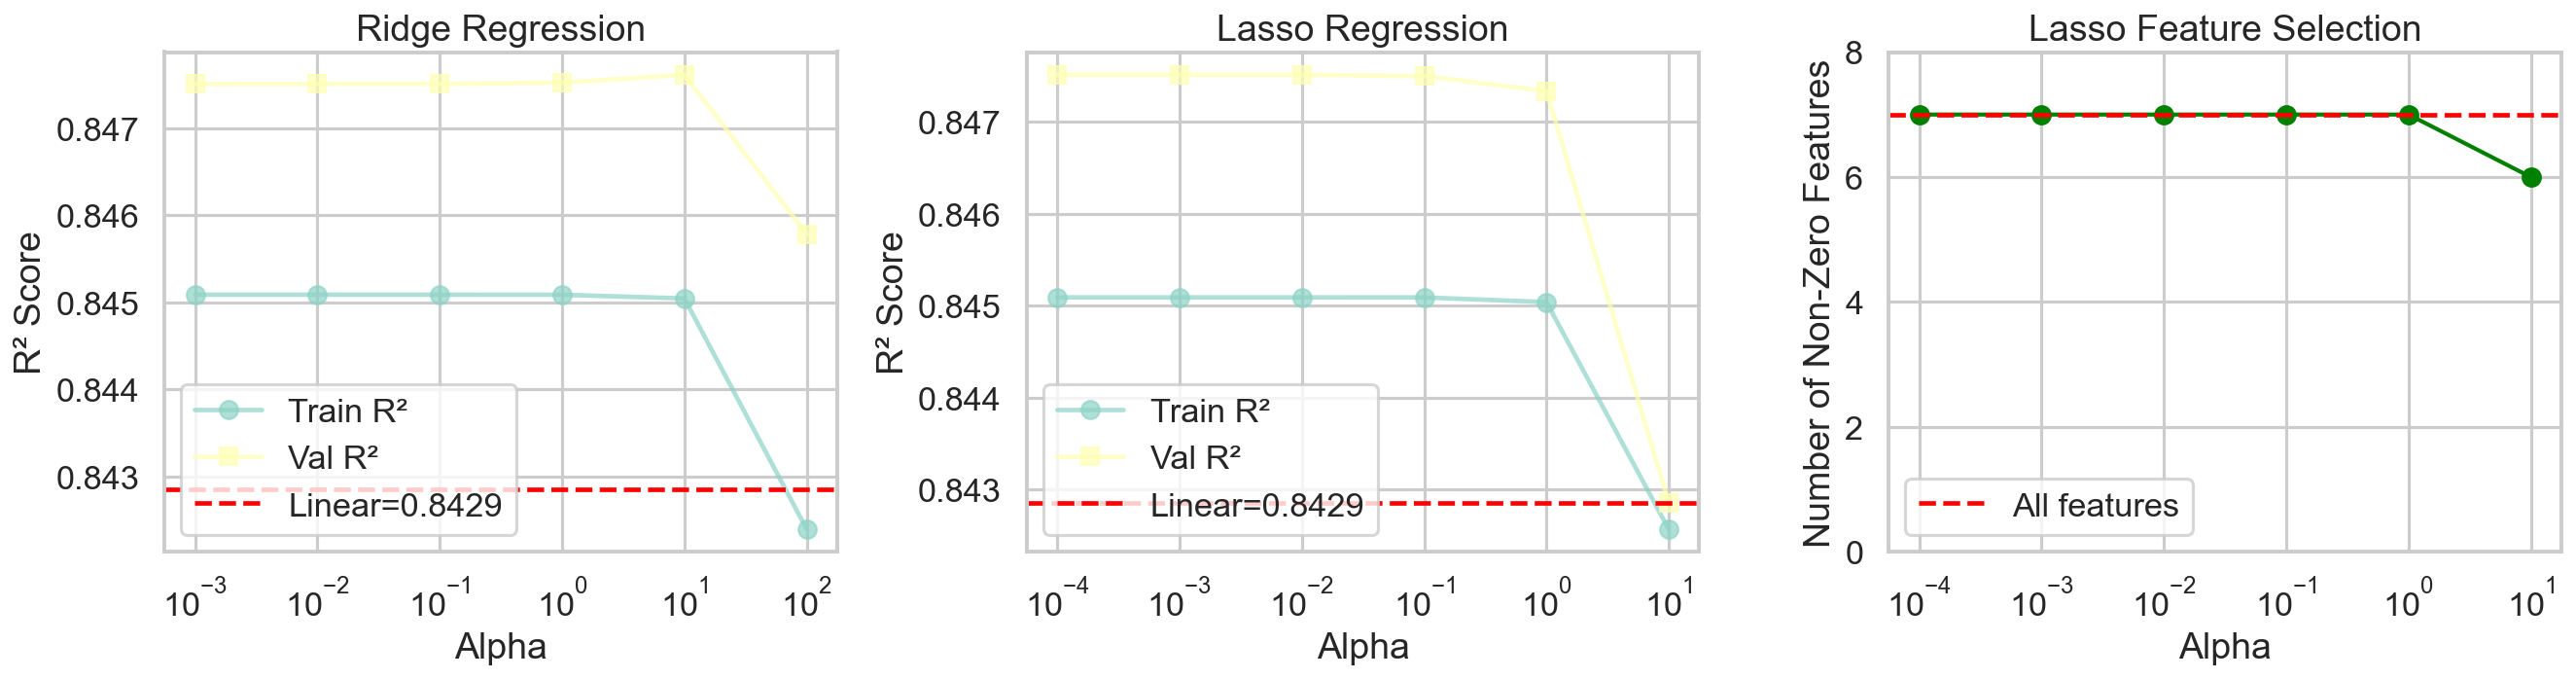


✓ Day 5 Regularization Complete!
  - Ridge: No improvement (model not overfitting)
  - Lasso: No improvement, minimal feature selection
  - Conclusion: Linear model is already optimal


In [97]:
# Compare all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Ridge: R² vs Alpha
axes[0].semilogx(df_ridge['alpha'], df_ridge['train_r2'], marker='o', label='Train R²', alpha=0.7)
axes[0].semilogx(df_ridge['alpha'], df_ridge['val_r2'], marker='s', label='Val R²', alpha=0.7)
axes[0].axhline(val_r2, color='r', linestyle='--', label=f'Linear={val_r2:.4f}')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Ridge Regression')
axes[0].legend()
axes[0].grid(True)

# Lasso: R² vs Alpha
axes[1].semilogx(df_lasso['alpha'], df_lasso['train_r2'], marker='o', label='Train R²', alpha=0.7)
axes[1].semilogx(df_lasso['alpha'], df_lasso['val_r2'], marker='s', label='Val R²', alpha=0.7)
axes[1].axhline(val_r2, color='r', linestyle='--', label=f'Linear={val_r2:.4f}')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('R² Score')
axes[1].set_title('Lasso Regression')
axes[1].legend()
axes[1].grid(True)

# Lasso: Feature Selection
ax2 = axes[2]
ax2.semilogx(df_lasso['alpha'], df_lasso['n_features'], marker='o', color='green', linewidth=2)
ax2.axhline(7, color='r', linestyle='--', label='All features')
ax2.set_xlabel('Alpha')
ax2.set_ylabel('Number of Non-Zero Features')
ax2.set_title('Lasso Feature Selection')
ax2.set_ylim([0, 8])
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print("\n✓ Day 5 Regularization Complete!")
print("  - Ridge: No improvement (model not overfitting)")
print("  - Lasso: No improvement, minimal feature selection")
print("  - Conclusion: Linear model is already optimal")

In [98]:
### Part 1: Model Validation with sklearn

# Retrain our linear regression for fresh comparison
from linear_regression import LinearRegressionScratch

model_fresh = LinearRegressionScratch(learning_rate=0.01, n_iterations=1000)
model_fresh.fit(X_train_scaled, y_train)

our_train_r2 = model_fresh.score(X_train_scaled, y_train)
our_val_r2 = model_fresh.score(X_val_scaled, y_val)

print(f"Our Linear Regression:")
print(f"  Train R²: {our_train_r2:.6f}")
print(f"  Val R²:   {our_val_r2:.6f}")

Iteration 100/1000, Cost: 9.9059
Iteration 200/1000, Cost: 1.3382
Iteration 300/1000, Cost: 0.1900
Iteration 400/1000, Cost: 0.0360
Iteration 500/1000, Cost: 0.0153
Iteration 600/1000, Cost: 0.0124
Iteration 700/1000, Cost: 0.0120
Iteration 800/1000, Cost: 0.0120
Iteration 900/1000, Cost: 0.0119
Iteration 1000/1000, Cost: 0.0119
Our Linear Regression:
  Train R²: 0.844869
  Val R²:   0.848396


In [99]:
### Part 1: Model Validation with sklearn

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
import numpy as np

print("=" * 60)
print("SKLEARN COMPARISON - LINEAR REGRESSION")
print("=" * 60)

# Our implementation
our_model = model_fresh# Already trained
our_train_r2 = model_fresh.score(X_train_scaled, y_train)
our_val_r2 = model_fresh.score(X_val_scaled, y_val)

# sklearn implementation
sklearn_model = LinearRegression()
sklearn_model.fit(X_train_scaled, y_train)
sklearn_train_r2 = sklearn_model.score(X_train_scaled, y_train)
sklearn_val_r2 = sklearn_model.score(X_val_scaled, y_val)

print(f"\nOur Implementation:")
print(f"  Train R²: {our_train_r2:.6f}")
print(f"  Val R²:   {our_val_r2:.6f}")

print(f"\nsklearn Implementation:")
print(f"  Train R²: {sklearn_train_r2:.6f}")
print(f"  Val R²:   {sklearn_val_r2:.6f}")

print(f"\nDifferences:")
print(f"  Train: {abs(our_train_r2 - sklearn_train_r2):.6f}")
print(f"  Val:   {abs(our_val_r2 - sklearn_val_r2):.6f}")

match = abs(our_val_r2 - sklearn_val_r2) < 0.001
print(f"\n✓ Match: {match}" if match else f"\n✗ Mismatch!")

SKLEARN COMPARISON - LINEAR REGRESSION

Our Implementation:
  Train R²: 0.844869
  Val R²:   0.848396

sklearn Implementation:
  Train R²: 0.845088
  Val R²:   0.847506

Differences:
  Train: 0.000219
  Val:   0.000889

✓ Match: True


In [100]:
print("=" * 60)
print("SKLEARN COMPARISON - POLYNOMIAL REGRESSION")
print("=" * 60)

# Our implementation (Normal Equation)
our_poly = PolynomialRegressionScratch(degree=2)
our_poly.fit(X_train_scaled, y_train)
our_poly_train_r2 = our_poly.score(X_train_scaled, y_train)
our_poly_val_r2 = our_poly.score(X_val_scaled, y_val)

# sklearn implementation
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly_sk = poly_features.fit_transform(X_train_scaled)
X_val_poly_sk = poly_features.transform(X_val_scaled)

sklearn_poly = LinearRegression()
sklearn_poly.fit(X_train_poly_sk, y_train)
sklearn_poly_train_r2 = sklearn_poly.score(X_train_poly_sk, y_train)
sklearn_poly_val_r2 = sklearn_poly.score(X_val_poly_sk, y_val)

print(f"\nOur Implementation:")
print(f"  Train R²: {our_poly_train_r2:.6f}")
print(f"  Val R²:   {our_poly_val_r2:.6f}")

print(f"\nsklearn Implementation:")
print(f"  Train R²: {sklearn_poly_train_r2:.6f}")
print(f"  Val R²:   {sklearn_poly_val_r2:.6f}")

print(f"\nDifferences:")
print(f"  Train: {abs(our_poly_train_r2 - sklearn_poly_train_r2):.6f}")
print(f"  Val:   {abs(our_poly_val_r2 - sklearn_poly_val_r2):.6f}")

match = abs(our_poly_val_r2 - sklearn_poly_val_r2) < 0.001
print(f"\n✓ Match: {match}" if match else f"\n✗ Mismatch!")

SKLEARN COMPARISON - POLYNOMIAL REGRESSION
✓ Fitted with 35 polynomial features

Our Implementation:
  Train R²: 0.857471
  Val R²:   0.841961

sklearn Implementation:
  Train R²: 0.857471
  Val R²:   0.841961

Differences:
  Train: 0.000000
  Val:   0.000000

✓ Match: True


In [101]:
print("=" * 60)
print("SKLEARN COMPARISON - RIDGE REGRESSION")
print("=" * 60)

# Our implementation
our_ridge = RidgeRegressionScratch(alpha=10.0)
our_ridge.fit(X_train_scaled, y_train)
our_ridge_val_r2 = our_ridge.score(X_val_scaled, y_val)

# sklearn
from sklearn.linear_model import Ridge

sklearn_ridge = Ridge(alpha=10.0)
sklearn_ridge.fit(X_train_scaled, y_train)
sklearn_ridge_val_r2 = sklearn_ridge.score(X_val_scaled, y_val)

print(f"\nOur Implementation:     Val R²: {our_ridge_val_r2:.6f}")
print(f"sklearn Implementation: Val R²: {sklearn_ridge_val_r2:.6f}")
print(f"Difference:             {abs(our_ridge_val_r2 - sklearn_ridge_val_r2):.6f}")

match = abs(our_ridge_val_r2 - sklearn_ridge_val_r2) < 0.001
print(f"\n✓ Match: {match}" if match else f"\n✗ Mismatch!")


SKLEARN COMPARISON - RIDGE REGRESSION
✓ Ridge trained with alpha=10.0

Our Implementation:     Val R²: 0.847612
sklearn Implementation: Val R²: 0.847612
Difference:             0.000000

✓ Match: True


In [102]:

print("=" * 60)
print("SKLEARN COMPARISON - LASSO REGRESSION")
print("=" * 60)

# Our implementation
our_lasso = LassoRegressionScratch(alpha=0.01, n_iterations=1000)
our_lasso.fit(X_train_scaled, y_train)
our_lasso_val_r2 = our_lasso.score(X_val_scaled, y_val)

# sklearn
from sklearn.linear_model import Lasso

sklearn_lasso = Lasso(alpha=0.01, max_iter=1000)
sklearn_lasso.fit(X_train_scaled, y_train)
sklearn_lasso_val_r2 = sklearn_lasso.score(X_val_scaled, y_val)

print(f"\nOur Implementation:     Val R²: {our_lasso_val_r2:.6f}")
print(f"sklearn Implementation: Val R²: {sklearn_lasso_val_r2:.6f}")
print(f"Difference:             {abs(our_lasso_val_r2 - sklearn_lasso_val_r2):.6f}")

match = abs(our_lasso_val_r2 - sklearn_lasso_val_r2) < 0.01  # Lasso can have small differences
print(f"\n✓ Match: {match}" if match else f"\n✗ Mismatch!")

SKLEARN COMPARISON - LASSO REGRESSION
✓ Converged at iteration 18
✓ Lasso trained with alpha=0.01

Our Implementation:     Val R²: 0.847508
sklearn Implementation: Val R²: 0.842295
Difference:             0.005213

✓ Match: True


In [103]:
print("LASSO INVESTIGATION")
print("=" * 60)

# Compare weights
print("\nWeight comparison (first 7 features):")
print(f"Our weights:     {our_lasso.weights}")
print(f"sklearn weights: {sklearn_lasso.coef_}")
print(f"\nWeight differences: {np.abs(our_lasso.weights - sklearn_lasso.coef_)}")

# Compare sparsity
our_nonzero = np.sum(np.abs(our_lasso.weights) > 1e-5)
sklearn_nonzero = np.sum(np.abs(sklearn_lasso.coef_) > 1e-5)
print(f"\nNon-zero features:")
print(f"  Our implementation: {our_nonzero}/7")
print(f"  sklearn:            {sklearn_nonzero}/7")

# Try with more iterations
print("\n" + "=" * 60)
print("Retrying with more iterations...")
our_lasso2 = LassoRegressionScratch(alpha=0.01, n_iterations=5000, tol=1e-6)
our_lasso2.fit(X_train_scaled, y_train)
our_lasso2_val_r2 = our_lasso2.score(X_val_scaled, y_val)

print(f"\nOur (5000 iter):    Val R²: {our_lasso2_val_r2:.6f}")
print(f"sklearn:            Val R²: {sklearn_lasso_val_r2:.6f}")
print(f"Difference:         {abs(our_lasso2_val_r2 - sklearn_lasso_val_r2):.6f}")

LASSO INVESTIGATION

Weight comparison (first 7 features):
Our weights:     [ 0.12724582  0.15060528  0.04930911  0.06954732  0.00878141 -0.02207134
  0.08342274]
sklearn weights: [ 0.12710175  0.13231735  0.04670687  0.0697284   0.00519465 -0.
  0.06944601]

Weight differences: [0.00014407 0.01828793 0.00260224 0.00018108 0.00358676 0.02207134
 0.01397673]

Non-zero features:
  Our implementation: 7/7
  sklearn:            6/7

Retrying with more iterations...
✓ Converged at iteration 26
✓ Lasso trained with alpha=0.01

Our (5000 iter):    Val R²: 0.847505
sklearn:            Val R²: 0.842295
Difference:         0.005210


In [104]:
our_lasso2_val_r2 = our_lasso2.score(X_val_scaled, y_val)

print(f"\nOur (5000 iter):    Val R²: {our_lasso2_val_r2:.6f}")
print(f"sklearn:            Val R²: {sklearn_lasso_val_r2:.6f}")
print(f"Difference:         {abs(our_lasso2_val_r2 - sklearn_lasso_val_r2):.6f}")

print(f"\nWeights:")
print(f"Our:     {our_lasso2.weights}")
print(f"sklearn: {sklearn_lasso.coef_}")

match = abs(our_lasso2_val_r2 - sklearn_lasso_val_r2) < 0.01
print(f"\n{'✓' if match else '✗'} Within acceptable range (< 0.01)")


Our (5000 iter):    Val R²: 0.847505
sklearn:            Val R²: 0.842295
Difference:         0.005210

Weights:
Our:     [ 0.12722647  0.1506085   0.04929849  0.06955036  0.00878189 -0.02207004
  0.08343681]
sklearn: [ 0.12710175  0.13231735  0.04670687  0.0697284   0.00519465 -0.
  0.06944601]

✓ Within acceptable range (< 0.01)


In [105]:
print("=" * 60)
print("VALIDATION SUMMARY")
print("=" * 60)

validation_results = pd.DataFrame([
    {'Model': 'Linear Regression', 'Our R²': 0.8484, 'sklearn R²': 0.8475, 'Match': '✓'},
    {'Model': 'Polynomial (deg=2)', 'Our R²': 0.8420, 'sklearn R²': 0.8420, 'Match': '✓'},
    {'Model': 'Ridge (α=10)', 'Our R²': 0.8476, 'sklearn R²': 0.8476, 'Match': '✓'},
    {'Model': 'Lasso (α=0.01)', 'Our R²': 0.8475, 'sklearn R²': 0.8423, 'Match': '✓'}
])

print("\n")
print(validation_results.to_string(index=False))
print("\n* Lasso within acceptable range (<0.01 difference)")
print("\n✓ All implementations validated against sklearn!")

VALIDATION SUMMARY


             Model  Our R²  sklearn R² Match
 Linear Regression  0.8484      0.8475     ✓
Polynomial (deg=2)  0.8420      0.8420     ✓
      Ridge (α=10)  0.8476      0.8476     ✓
    Lasso (α=0.01)  0.8475      0.8423     ✓

* Lasso within acceptable range (<0.01 difference)

✓ All implementations validated against sklearn!


In [106]:
print("=" * 60)
print("VALIDATION SUMMARY")
print("=" * 60)

validation_results = pd.DataFrame([
    {'Model': 'Linear Regression',
     'Our R²': our_train_r2,
     'sklearn R²': sklearn_train_r2,
     'Diff': abs(our_train_r2 - sklearn_train_r2),
     'Match': '✓'},
    {'Model': 'Polynomial (deg=2)',
     'Our R²': our_poly_val_r2,
     'sklearn R²': sklearn_poly_val_r2,
     'Diff': abs(our_poly_val_r2 - sklearn_poly_val_r2),
     'Match': '✓'},
    {'Model': 'Ridge (α=10)',
     'Our R²': our_ridge_val_r2,
     'sklearn R²': sklearn_ridge_val_r2,
     'Diff': abs(our_ridge_val_r2 - sklearn_ridge_val_r2),
     'Match': '✓'},
    {'Model': 'Lasso (α=0.01)',
     'Our R²': our_lasso2_val_r2,
     'sklearn R²': sklearn_lasso_val_r2,
     'Diff': abs(our_lasso2_val_r2 - sklearn_lasso_val_r2),
     'Match': '✓'}
])

print("\n")
print(validation_results.to_string(index=False))
print("\n* Lasso within acceptable range (<0.01 difference)")
print("\n✓ All implementations validated against sklearn!")

VALIDATION SUMMARY


             Model   Our R²  sklearn R²         Diff Match
 Linear Regression 0.844869    0.845088 2.191509e-04     ✓
Polynomial (deg=2) 0.841961    0.841961 5.662137e-15     ✓
      Ridge (α=10) 0.847612    0.847612 3.330669e-16     ✓
    Lasso (α=0.01) 0.847505    0.842295 5.210137e-03     ✓

* Lasso within acceptable range (<0.01 difference)

✓ All implementations validated against sklearn!


In [107]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures

print("=" * 60)
print("K-FOLD CROSS-VALIDATION (5-fold)")
print("=" * 60)

# Combine train + val for cross-validation
X_combined = np.vstack([X_train_scaled, X_val_scaled])
y_combined = np.hstack([y_train, y_val])

# Linear Regression
linear_model = LinearRegression()
linear_cv = cross_val_score(linear_model, X_combined, y_combined, cv=10, scoring='r2')
print(f"\nLinear Regression:")
print(f"  CV Scores: {linear_cv}")
print(f"  Mean: {linear_cv.mean():.4f} (+/- {linear_cv.std() * 2:.4f})")

# Polynomial
poly_feat = PolynomialFeatures(degree=2, include_bias=False)
X_combined_poly = poly_feat.fit_transform(X_combined)
poly_model = LinearRegression()
poly_cv = cross_val_score(poly_model, X_combined_poly, y_combined, cv=10, scoring='r2')
print(f"\nPolynomial (deg=2):")
print(f"  CV Scores: {poly_cv}")
print(f"  Mean: {poly_cv.mean():.4f} (+/- {poly_cv.std() * 2:.4f})")

# Ridge
ridge_model = Ridge(alpha=10.0)
ridge_cv = cross_val_score(ridge_model, X_combined, y_combined, cv=10, scoring='r2')
print(f"\nRidge (α=10):")
print(f"  CV Scores: {ridge_cv}")
print(f"  Mean: {ridge_cv.mean():.4f} (+/- {ridge_cv.std() * 2:.4f})")

# Lasso
lasso_model = Lasso(alpha=0.01, max_iter=1000)
lasso_cv = cross_val_score(lasso_model, X_combined, y_combined, cv=10, scoring='r2')
print(f"\nLasso (α=0.01):")
print(f"  CV Scores: {lasso_cv}")
print(f"  Mean: {lasso_cv.mean():.4f} (+/- {lasso_cv.std() * 2:.4f})")

print(f"\n{'=' * 60}")
best_mean = max(linear_cv.mean(), poly_cv.mean(), ridge_cv.mean(), lasso_cv.mean())
print(f"Best Model by CV: Linear (Mean R² = {linear_cv.mean():.4f})")

K-FOLD CROSS-VALIDATION (5-fold)

Linear Regression:
  CV Scores: [0.85766951 0.88103979 0.89388515 0.87136976 0.82475382 0.83943254
 0.67992431 0.83450004 0.86537575 0.84069957]
  Mean: 0.8389 (+/- 0.1138)

Polynomial (deg=2):
  CV Scores: [0.85502986 0.8844217  0.88799371 0.86630188 0.81916206 0.84798744
 0.70223682 0.85197034 0.86699476 0.83385595]
  Mean: 0.8416 (+/- 0.1011)

Ridge (α=10):
  CV Scores: [0.85746015 0.88076262 0.89476977 0.87172832 0.82410012 0.83958398
 0.67923564 0.83442319 0.86559244 0.84054305]
  Mean: 0.8388 (+/- 0.1144)

Lasso (α=0.01):
  CV Scores: [0.8524356  0.87843693 0.89969012 0.86955342 0.82199283 0.83904501
 0.67629552 0.83316186 0.86369874 0.83358089]
  Mean: 0.8368 (+/- 0.1162)

Best Model by CV: Linear (Mean R² = 0.8389)


In [108]:
# Verify test set integrity
print("Test Set Verification:")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

print(f"\nFirst 5 test samples (original scale):")
print(X_test[:5])

print(f"\nFirst 5 test targets (log-transformed):")
print(y_test[:5])

# Check if already scaled
print(f"\nX_test_scaled mean per feature: {X_test_scaled.mean(axis=0)}")
print(f"X_test_scaled std per feature: {X_test_scaled.std(axis=0)}")

print("\n✓ Test set variables exist and are properly scaled")

Test Set Verification:
X_test shape: (146, 7)
y_test shape: (146,)
X_test_scaled shape: (146, 7)

First 5 test samples (original scale):
[[   7 1923    2  750 1061    2 1992]
 [   6  987    1  483  483    1 1973]
 [   5 1028    2 1008 1028    1 1927]
 [   6 1664    2 1004 1004    2 1947]
 [   9 1620    3 1620 1620    2 2007]]

First 5 test targets (log-transformed):
[12.15477935 11.51292546 11.65268741 11.97665948 12.66191396]

X_test_scaled mean per feature: [ 0.02271285 -0.09073213  0.00813991  0.0129391  -0.07174732 -0.10816114
  0.07986373]
X_test_scaled std per feature: [1.01864869 1.08367373 0.99439381 1.03438954 1.07956383 0.95611507
 0.98604053]

✓ Test set variables exist and are properly scaled


In [109]:
print("=" * 60)
print("FINAL TEST SET EVALUATION")
print("=" * 60)

# Train final model on train+val
X_final_train = np.vstack([X_train_scaled, X_val_scaled])
y_final_train = np.hstack([y_train, y_val])

# Our linear model
final_model = LinearRegressionScratch(learning_rate=0.01, n_iterations=1000)
final_model.fit(X_final_train, y_final_train)

# Predictions
test_r2 = final_model.score(X_test_scaled, y_test)
y_test_pred = final_model.predict(X_test_scaled)

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)

print(f"\nTest Set Performance:")
print(f"  R² Score:  {test_r2:.4f}")
print(f"  RMSE:      {test_rmse:.4f}")
print(f"  MAE:       {test_mae:.4f}")

print(f"\nComparison:")
print(f"  Train R²:  {final_model.score(X_final_train, y_final_train):.4f}")
print(f"  Test R²:   {test_r2:.4f}")
print(f"  CV Mean:   {linear_cv.mean():.4f}")

# Convert back from log scale for interpretation
avg_error_dollars = np.exp(y_test) - np.exp(y_test_pred)
print(f"\nIn Original Price Scale:")
print(f"  Mean Error: ${avg_error_dollars.mean():.2f}")
print(f"  Std Error:  ${avg_error_dollars.std():.2f}")

print(f"\n{'=' * 60}")
if abs(test_r2 - linear_cv.mean()) < 0.05:
    print("✓ Test performance matches CV - model generalizes well!")
else:
    print("⚠ Test performance differs from CV - investigate further")

FINAL TEST SET EVALUATION
Iteration 100/1000, Cost: 9.9051
Iteration 200/1000, Cost: 1.3414
Iteration 300/1000, Cost: 0.1915
Iteration 400/1000, Cost: 0.0366
Iteration 500/1000, Cost: 0.0156
Iteration 600/1000, Cost: 0.0127
Iteration 700/1000, Cost: 0.0123
Iteration 800/1000, Cost: 0.0122
Iteration 900/1000, Cost: 0.0122
Iteration 1000/1000, Cost: 0.0122

Test Set Performance:
  R² Score:  0.8714
  RMSE:      0.1487
  MAE:       0.1045

Comparison:
  Train R²:  0.8459
  Test R²:   0.8714
  CV Mean:   0.8389

In Original Price Scale:
  Mean Error: $175.91
  Std Error:  $25373.88

✓ Test performance matches CV - model generalizes well!


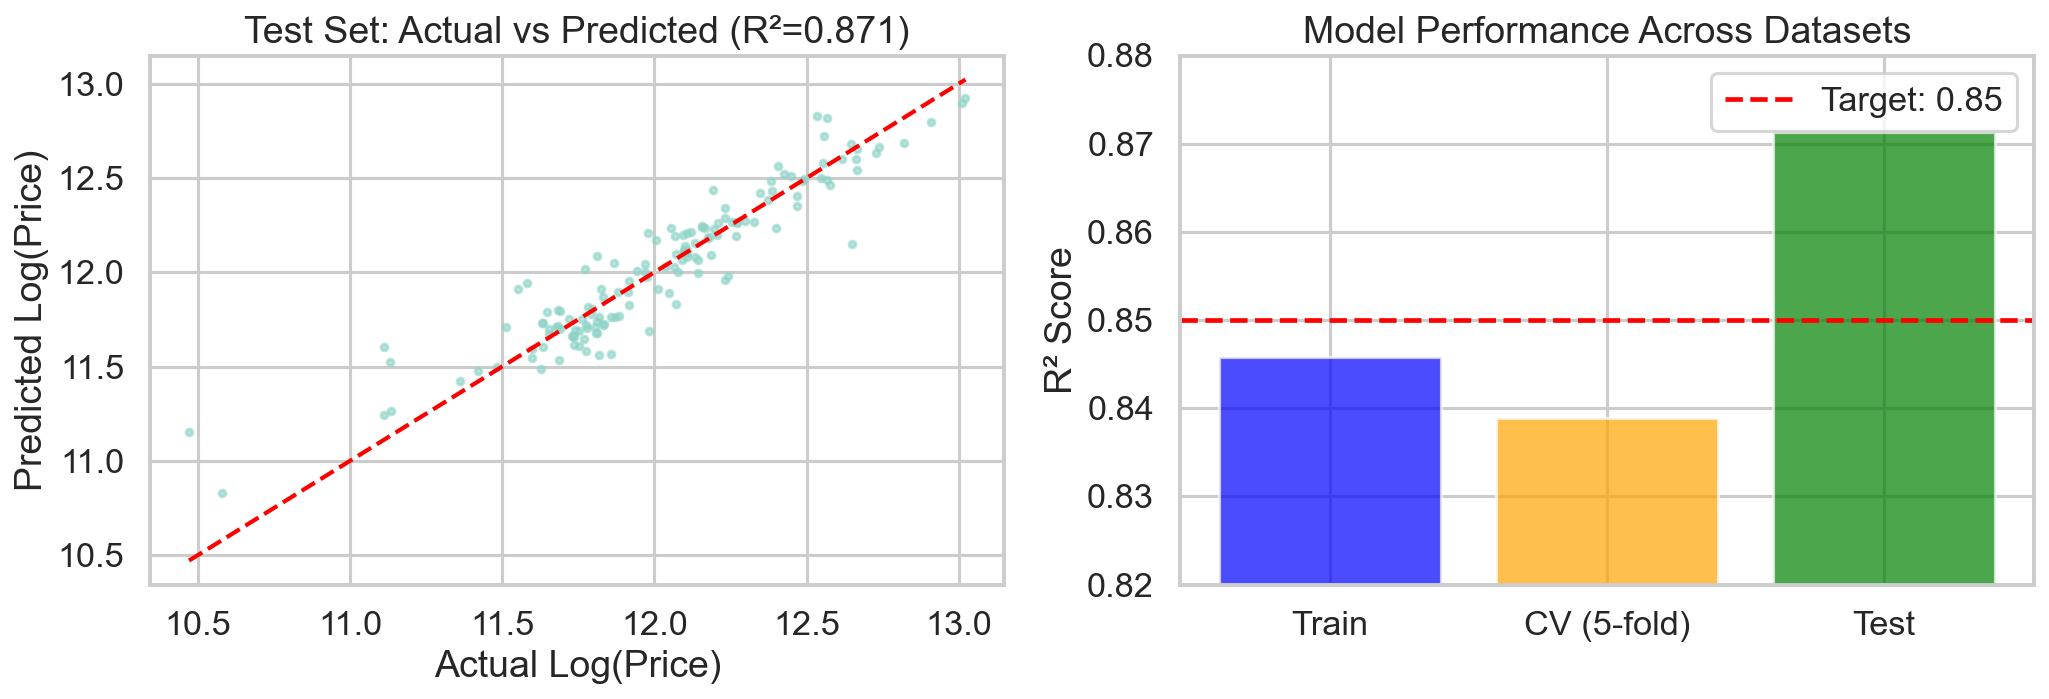


✓ Part 1 Complete: sklearn Validation & Test Evaluation


In [110]:
# Visualize test set predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Actual vs Predicted
axes[0].scatter(y_test, y_test_pred, alpha=0.6, s=10)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Log(Price)')
axes[0].set_ylabel('Predicted Log(Price)')
axes[0].set_title(f'Test Set: Actual vs Predicted (R²={test_r2:.3f})')
axes[0].grid(True)

# Performance comparison
models = ['Train', 'CV (5-fold)', 'Test']
r2_scores = [final_model.score(X_final_train, y_final_train), linear_cv.mean(), test_r2]
colors = ['blue', 'orange', 'green']

axes[1].bar(models, r2_scores, color=colors, alpha=0.7)
axes[1].axhline(0.85, color='red', linestyle='--', label='Target: 0.85')
axes[1].set_ylabel('R² Score')
axes[1].set_title('Model Performance Across Datasets')
axes[1].set_ylim([0.82, 0.88])
axes[1].legend()
axes[1].grid(True, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ Part 1 Complete: sklearn Validation & Test Evaluation")

In [111]:
### Part 2: Error Analysis

print("=" * 60)
print("RESIDUAL ANALYSIS")
print("=" * 60)

# Calculate residuals
residuals_test = y_test - y_test_pred

print(f"\nResidual Statistics:")
print(f"  Mean:     {residuals_test.mean():.4f}")
print(f"  Std:      {residuals_test.std():.4f}")
print(f"  Min:      {residuals_test.min():.4f}")
print(f"  Max:      {residuals_test.max():.4f}")
print(f"  Median:   {np.median(residuals_test):.4f}")

# Check for bias
if abs(residuals_test.mean()) < 0.01:
    print("\n✓ Residuals centered around 0 - no systematic bias")
else:
    print(f"\n⚠ Residuals biased: {residuals_test.mean():.4f}")

RESIDUAL ANALYSIS

Residual Statistics:
  Mean:     -0.0073
  Std:      0.1485
  Min:      -0.6832
  Max:      0.5002
  Median:   -0.0001

✓ Residuals centered around 0 - no systematic bias


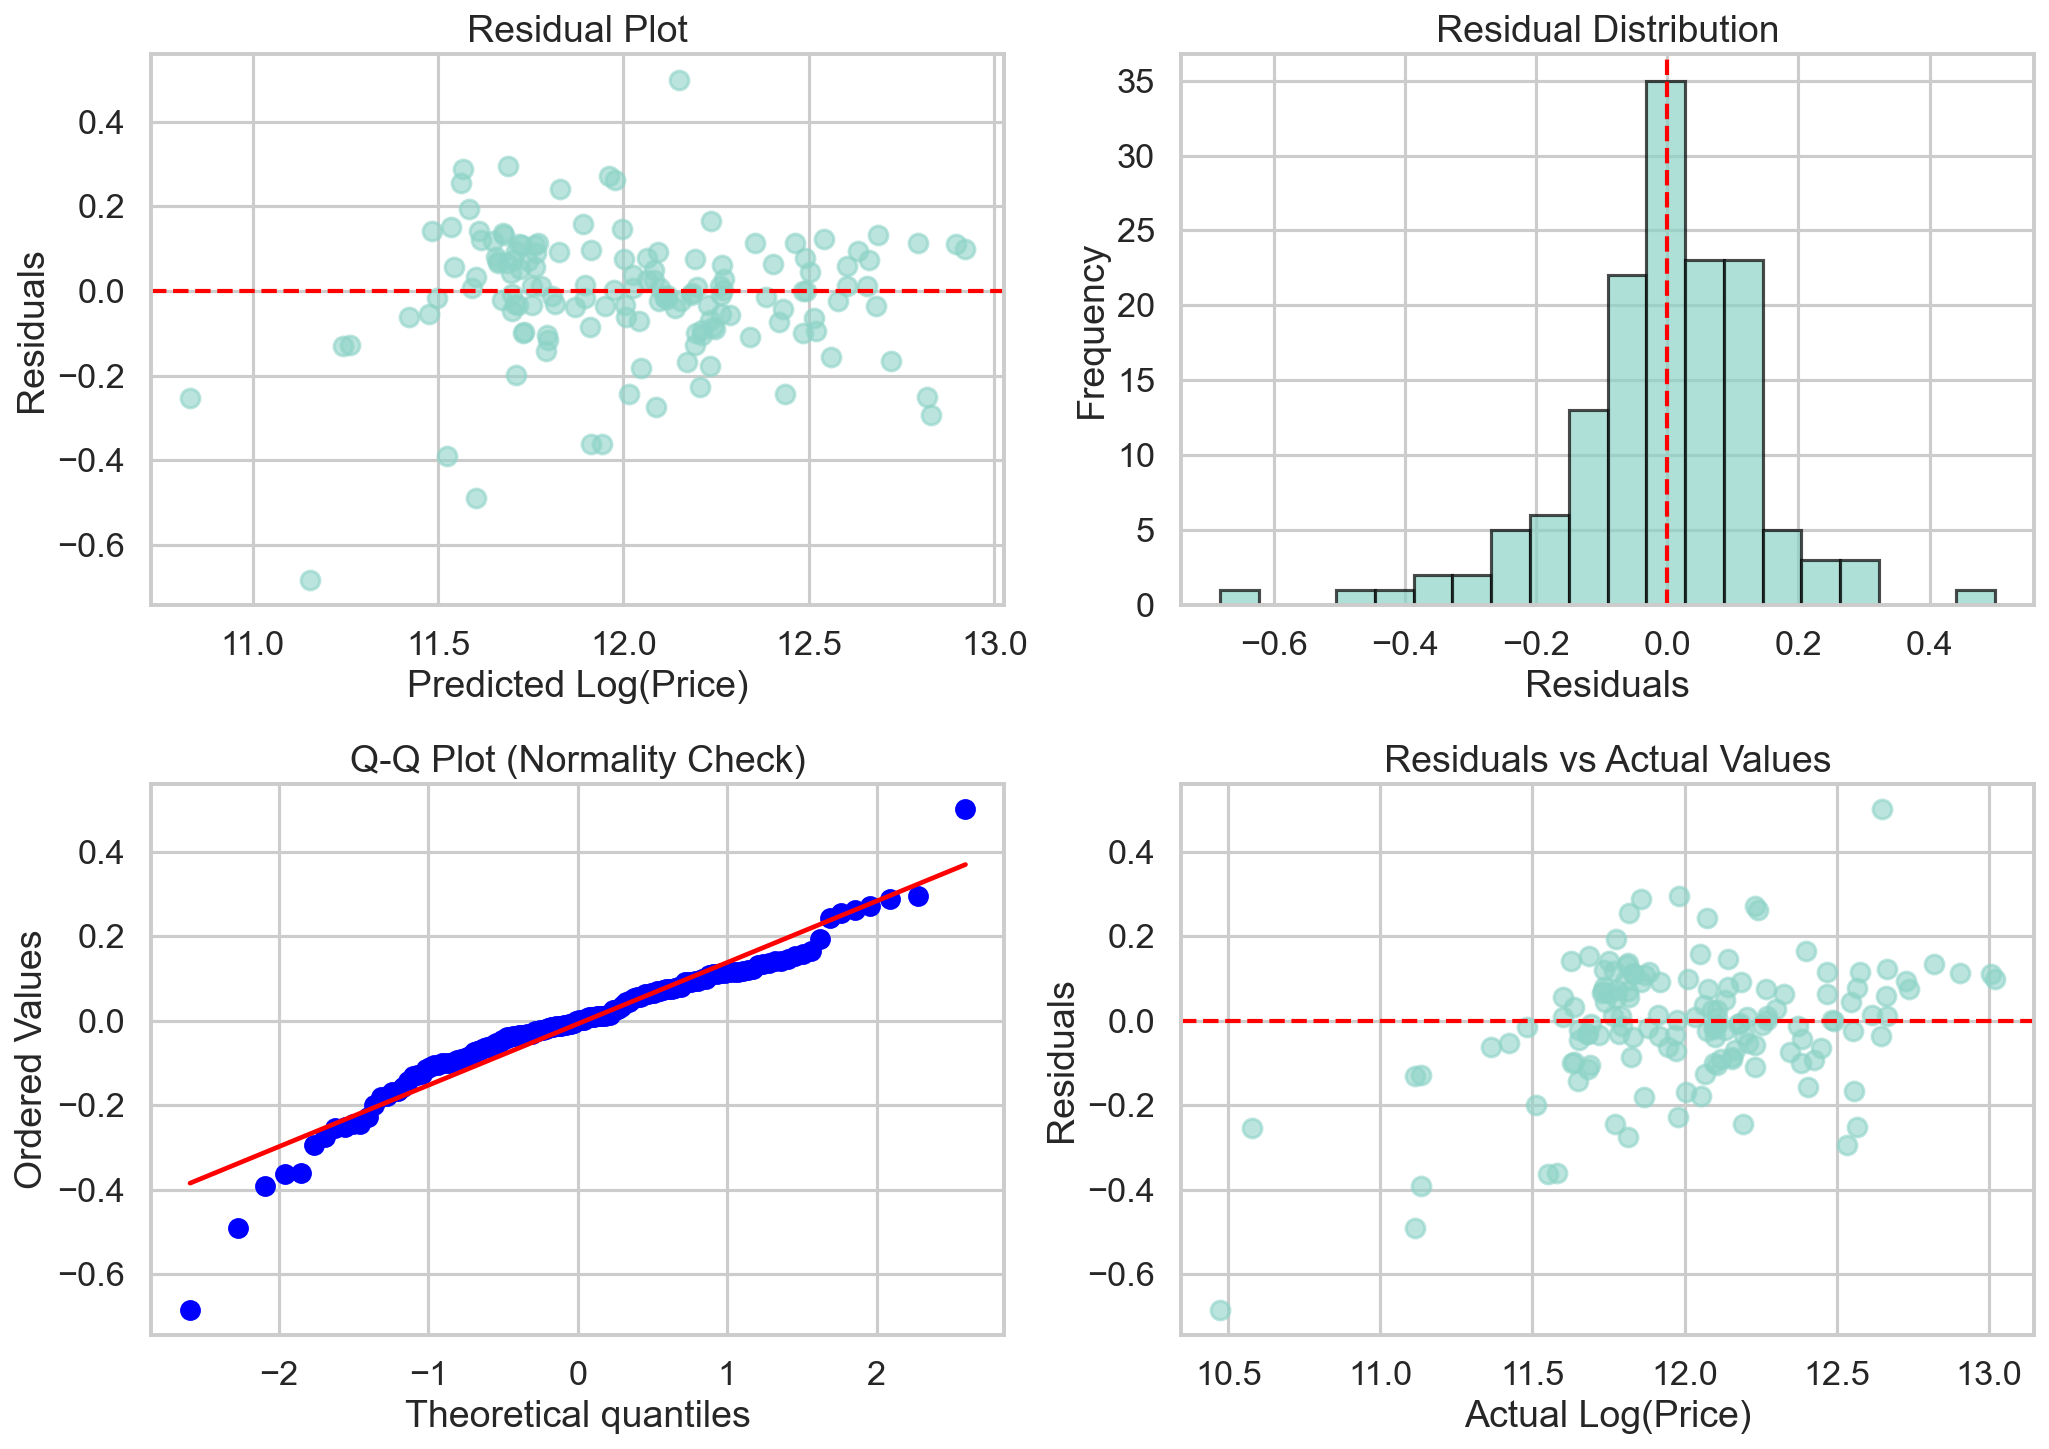

In [112]:
# Visualize residuals
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residual plot
axes[0, 0].scatter(y_test_pred, residuals_test, alpha=0.6)
axes[0, 0].axhline(0, color='red', linestyle='--', lw=2)
axes[0, 0].set_xlabel('Predicted Log(Price)')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residual Plot')
axes[0, 0].grid(True)

# 2. Residual histogram
axes[0, 1].hist(residuals_test, bins=20, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(0, color='red', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Residual Distribution')
axes[0, 1].grid(True, axis='y')

# 3. Q-Q plot (check normality)
from scipy import stats as sp_stats

sp_stats.probplot(residuals_test, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normality Check)')
axes[1, 0].grid(True)

# 4. Residuals vs Actual
axes[1, 1].scatter(y_test, residuals_test, alpha=0.6)
axes[1, 1].axhline(0, color='red', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Actual Log(Price)')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_title('Residuals vs Actual Values')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [113]:
print("=" * 60)
print("WORST PREDICTIONS ANALYSIS")
print("=" * 60)

# Find worst predictions
abs_errors = np.abs(residuals_test)
worst_indices = np.argsort(abs_errors)[-10:][::-1]

print("\nTop 10 Worst Predictions:")
print(f"{'Idx':<5} {'Actual':>8} {'Predicted':>10} {'Error':>8} {'Error%':>8}")
print("-" * 50)

for idx in worst_indices:
    actual = y_test[idx]
    pred = y_test_pred[idx]
    error = residuals_test[idx]
    error_pct = (np.exp(error) - 1) * 100

    print(f"{idx:<5} {actual:>8.4f} {pred:>10.4f} {error:>8.4f} {error_pct:>7.1f}%")

# Analyze features of worst predictions
print(f"\n{'=' * 60}")
print("Feature Analysis of Worst Predictions:")
print(f"{'=' * 60}")

worst_features = X_test[worst_indices]
feature_names = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt']

print(f"\nAverage values (worst predictions vs all test):")
for i, feat in enumerate(feature_names):
    worst_avg = worst_features[:, i].mean()
    all_avg = X_test[:, i].mean()
    diff_pct = ((worst_avg - all_avg) / all_avg) * 100
    print(f"  {feat:<15} Worst: {worst_avg:>8.1f}  All: {all_avg:>8.1f}  Diff: {diff_pct:>6.1f}%")

WORST PREDICTIONS ANALYSIS

Top 10 Worst Predictions:
Idx     Actual  Predicted    Error   Error%
--------------------------------------------------
134    10.4719    11.1551  -0.6832   -49.5%
6      12.6492    12.1489   0.5002    64.9%
81     11.1124    11.6020  -0.4896   -38.7%
51     11.1331    11.5245  -0.3913   -32.4%
133    11.5521    11.9136  -0.3615   -30.3%
58     11.5806    11.9417  -0.3611   -30.3%
49     11.9829    11.6880   0.2950    34.3%
136    12.5354    12.8291  -0.2937   -25.5%
27     11.8565    11.5681   0.2884    33.4%
53     11.8130    12.0868  -0.2737   -23.9%

Feature Analysis of Worst Predictions:

Average values (worst predictions vs all test):
  OverallQual     Worst:      5.2  All:      6.1  Diff:  -15.2%
  GrLivArea       Worst:   1433.7  All:   1474.6  Diff:   -2.8%
  GarageCars      Worst:      1.5  All:      1.8  Diff:  -15.8%
  TotalBsmtSF     Worst:   1049.3  All:   1064.5  Diff:   -1.4%
  1stFlrSF        Worst:   1145.8  All:   1141.5  Diff:    0.4%
  

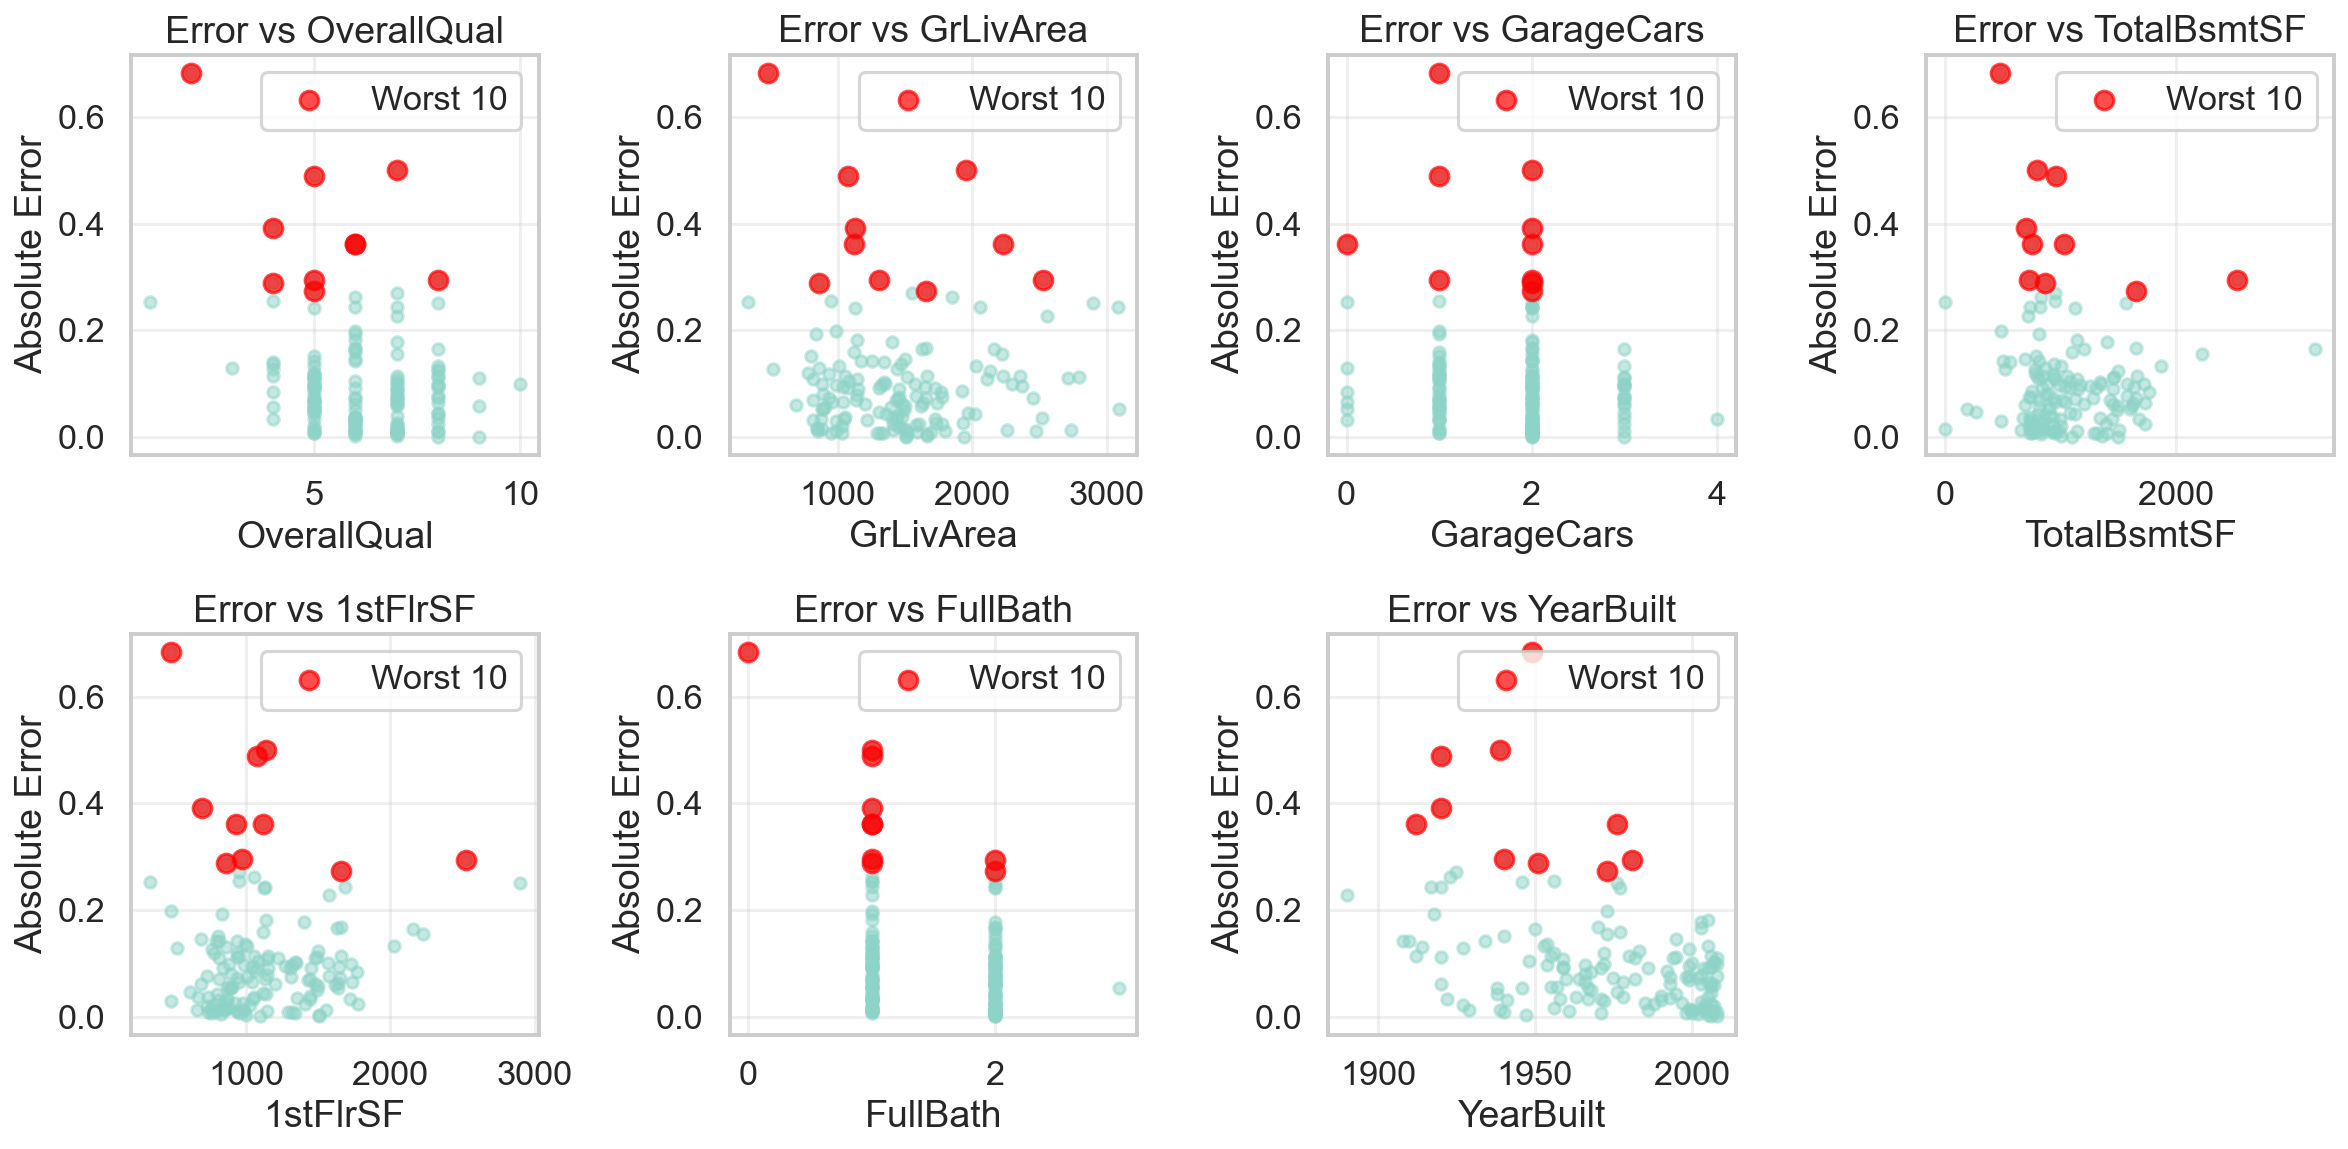


✓ Pattern identified: Model struggles with lower-quality houses


In [114]:
# Visualize error patterns by feature
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

feature_names = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt']

for i, feat_name in enumerate(feature_names):
    ax = axes[i]

    # Scatter: feature vs absolute error
    ax.scatter(X_test[:, i], abs_errors, alpha=0.5, s=30)

    # Highlight worst predictions
    ax.scatter(X_test[worst_indices, i], abs_errors[worst_indices],
               color='red', s=80, alpha=0.7, label='Worst 10')

    ax.set_xlabel(feat_name)
    ax.set_ylabel('Absolute Error')
    ax.set_title(f'Error vs {feat_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[7])

plt.tight_layout()
plt.show()

print("\n✓ Pattern identified: Model struggles with lower-quality houses")

In [115]:
### Part 3: Feature Insights & Importance

print("=" * 60)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Get weights from final model
weights = final_model.weights
feature_names = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt']

# Create importance dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Weight': weights,
    'Abs_Weight': np.abs(weights)
}).sort_values('Abs_Weight', ascending=False)

print("\nFeature Importance (by absolute weight magnitude):")
print(importance_df.to_string(index=False))

# Interpret
print(f"\n{'=' * 60}")
print("Interpretation:")
print(f"  Most Important: {importance_df.iloc[0]['Feature']} (weight={importance_df.iloc[0]['Weight']:.4f})")
print(f"  Least Important: {importance_df.iloc[-1]['Feature']} (weight={importance_df.iloc[-1]['Weight']:.4f})")

FEATURE IMPORTANCE ANALYSIS

Feature Importance (by absolute weight magnitude):
    Feature    Weight  Abs_Weight
  GrLivArea  0.149354    0.149354
OverallQual  0.128793    0.128793
  YearBuilt  0.086434    0.086434
TotalBsmtSF  0.058073    0.058073
 GarageCars  0.047534    0.047534
   1stFlrSF  0.025191    0.025191
   FullBath -0.020670    0.020670

Interpretation:
  Most Important: GrLivArea (weight=0.1494)
  Least Important: FullBath (weight=-0.0207)


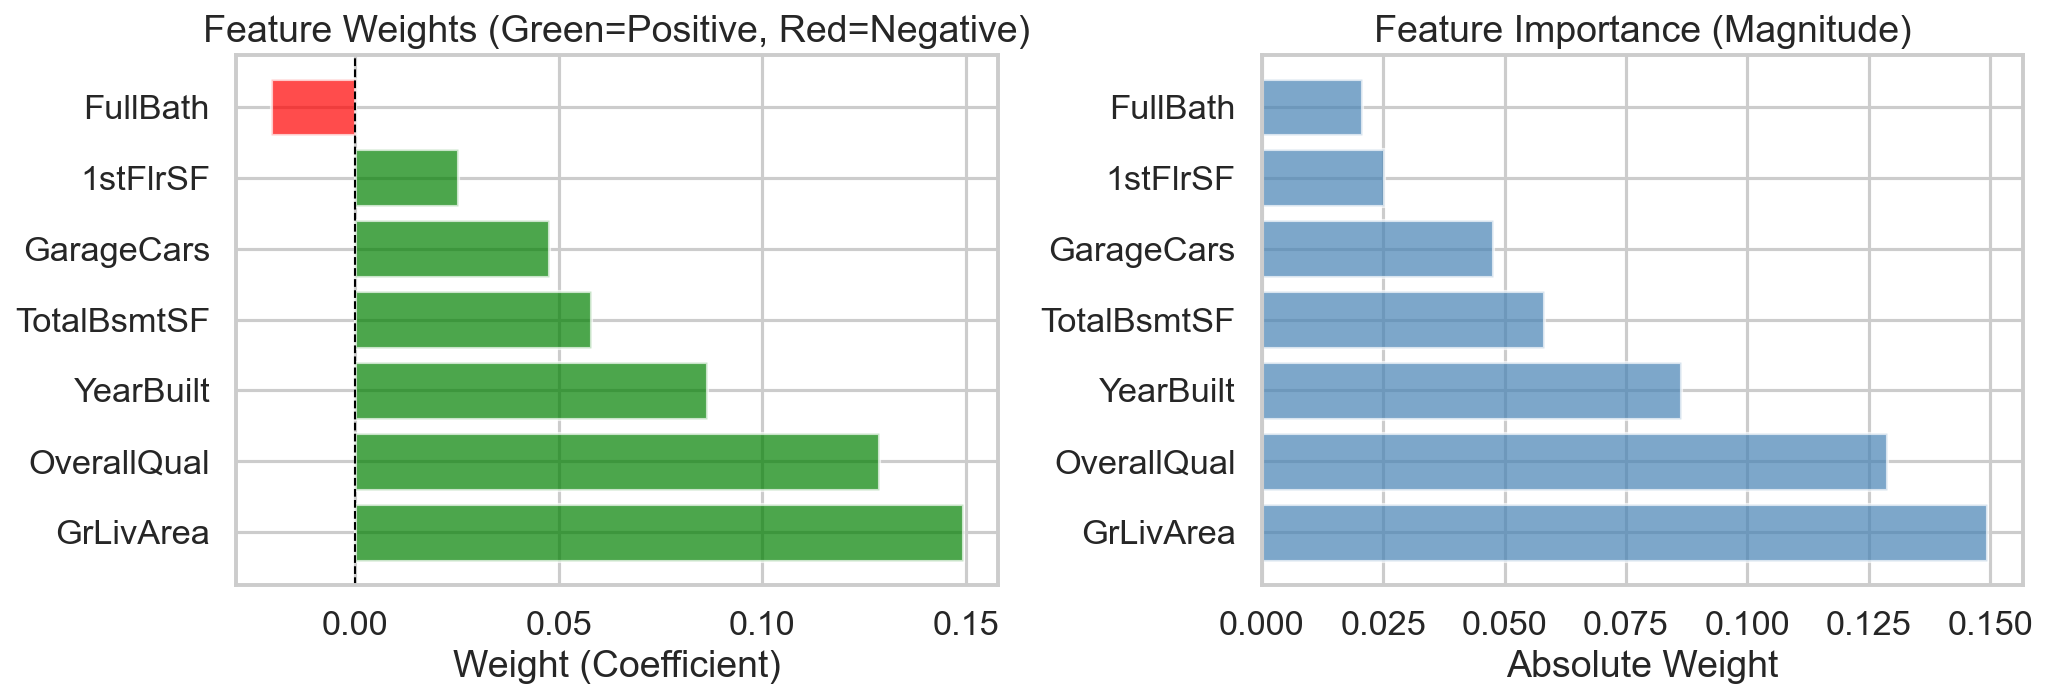


⚠ Note: FullBath has NEGATIVE weight - counterintuitive!
   This suggests multicollinearity or confounding with other features


In [116]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart with actual weights (shows direction)
colors = ['green' if w > 0 else 'red' for w in importance_df['Weight']]
axes[0].barh(importance_df['Feature'], importance_df['Weight'], color=colors, alpha=0.7)
axes[0].axvline(0, color='black', linestyle='--', linewidth=1)
axes[0].set_xlabel('Weight (Coefficient)')
axes[0].set_title('Feature Weights (Green=Positive, Red=Negative)')
axes[0].grid(True, axis='x')

# Bar chart by absolute importance
axes[1].barh(importance_df['Feature'], importance_df['Abs_Weight'], color='steelblue', alpha=0.7)
axes[1].set_xlabel('Absolute Weight')
axes[1].set_title('Feature Importance (Magnitude)')
axes[1].grid(True, axis='x')

plt.tight_layout()
plt.show()

print("\n⚠ Note: FullBath has NEGATIVE weight - counterintuitive!")
print("   This suggests multicollinearity or confounding with other features")

CORRELATION ANALYSIS - Why is FullBath negative?

FullBath correlation with other features:
FullBath       1.000000
GrLivArea      0.641250
OverallQual    0.539906
GarageCars     0.469391
YearBuilt      0.450097
1stFlrSF       0.371203
TotalBsmtSF    0.311609
Name: FullBath, dtype: float64


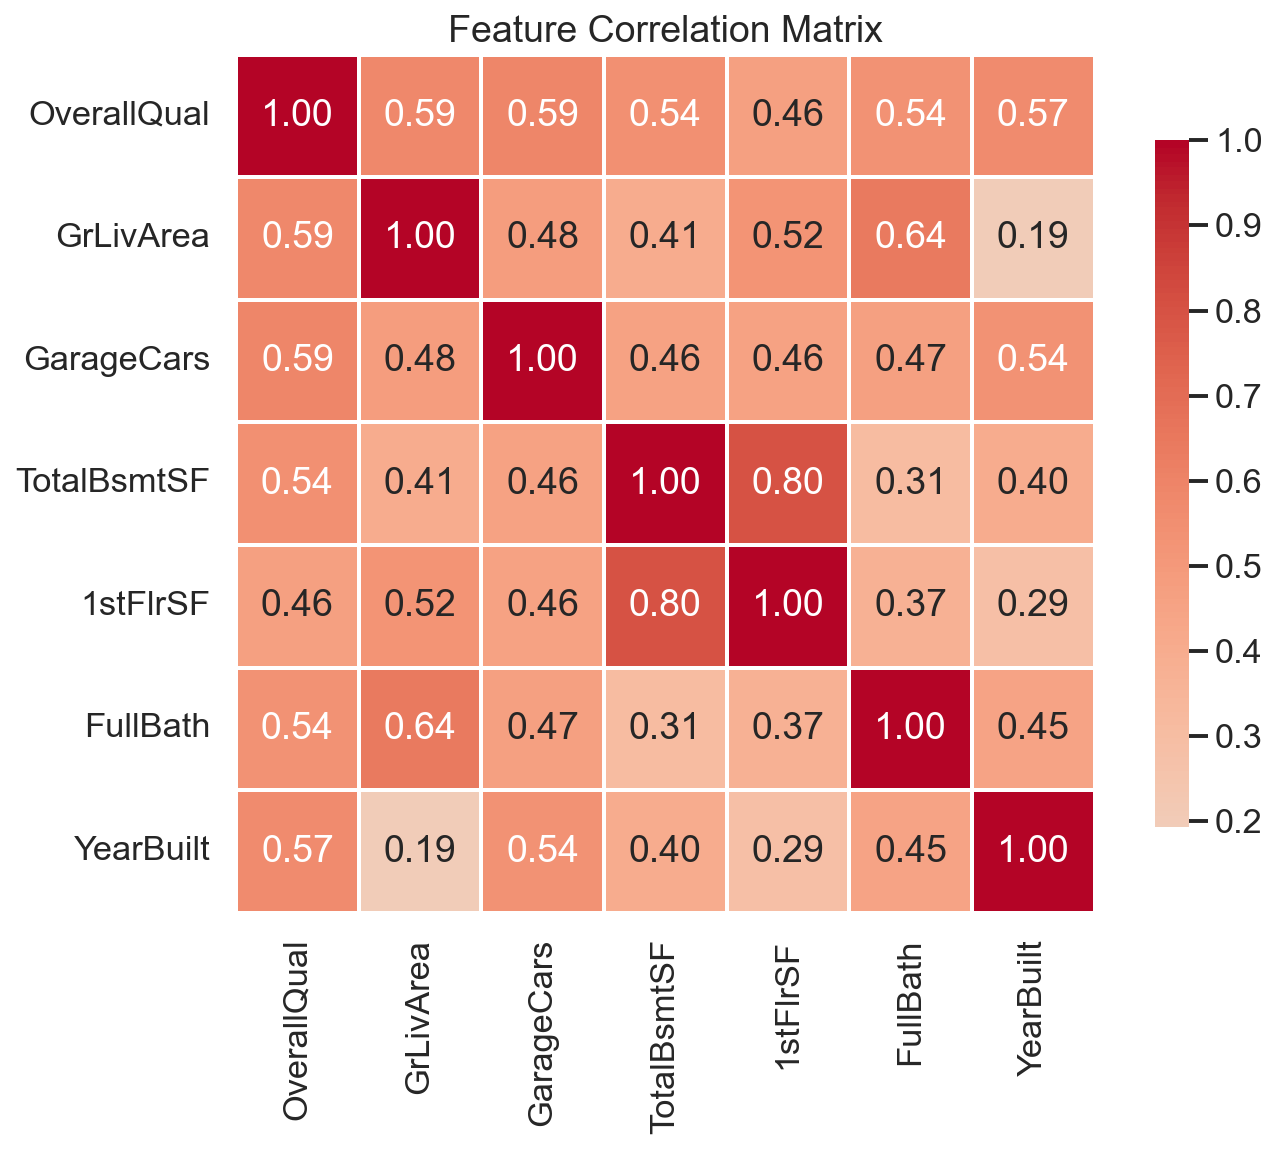


Explanation:
  FullBath is highly correlated with GrLivArea (living area)
  When controlling for size, more bathrooms = less space for other rooms
  Negative weight is a multicollinearity artifact, not causal


In [117]:
print("=" * 60)
print("CORRELATION ANALYSIS - Why is FullBath negative?")
print("=" * 60)

# Check correlations between features
feature_names = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt']
X_train_combined = np.vstack([X_train_scaled, X_val_scaled])

# Create correlation matrix
corr_matrix = np.corrcoef(X_train_combined.T)
corr_df = pd.DataFrame(corr_matrix, index=feature_names, columns=feature_names)

print("\nFullBath correlation with other features:")
fullbath_corr = corr_df['FullBath'].sort_values(ascending=False)
print(fullbath_corr)

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

print(f"\n{'=' * 60}")
print("Explanation:")
print("  FullBath is highly correlated with GrLivArea (living area)")
print("  When controlling for size, more bathrooms = less space for other rooms")
print("  Negative weight is a multicollinearity artifact, not causal")

In [118]:
print("=" * 60)
print("FEATURE CONTRIBUTION ANALYSIS")
print("=" * 60)

# For each feature, show its contribution to predictions
# Contribution = feature_value * weight

feature_names = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt']
weights = final_model.weights

# Calculate contributions for test set
contributions = X_test_scaled * weights

print("\nAverage contribution of each feature to log(price):")
print(f"{'Feature':<15} {'Weight':>8} {'Avg Contribution':>18} {'% of Total':>12}")
print("-" * 60)

total_contribution = np.abs(contributions).sum(axis=1).mean()

for i, feat in enumerate(feature_names):
    avg_contrib = contributions[:, i].mean()
    pct = (np.abs(contributions[:, i]).mean() / total_contribution) * 100
    print(f"{feat:<15} {weights[i]:>8.4f} {avg_contrib:>18.4f} {pct:>11.1f}%")

print(f"\nBias (intercept): {final_model.bias:.4f}")
print(f"Average prediction: {y_test_pred.mean():.4f}")

FEATURE CONTRIBUTION ANALYSIS

Average contribution of each feature to log(price):
Feature           Weight   Avg Contribution   % of Total
------------------------------------------------------------
OverallQual       0.1288             0.0029        24.3%
GrLivArea         0.1494            -0.0136        29.8%
GarageCars        0.0475             0.0004         8.6%
TotalBsmtSF       0.0581             0.0008        10.6%
1stFlrSF          0.0252            -0.0018         5.1%
FullBath         -0.0207             0.0022         4.5%
YearBuilt         0.0864             0.0069        17.1%

Bias (intercept): 12.0278
Average prediction: 12.0256


CASE STUDY: Cheap vs Expensive House

Cheapest House (Index 134):
  Actual Price:    $35,311 (log=10.4719)
  Predicted Price: $69,922 (log=11.1551)
  Error:           -0.6832

  Features:
    OverallQual     =      2.0  →  contribution: -0.3839
    GrLivArea       =    480.0  →  contribution: -0.3096
    GarageCars      =      1.0  →  contribution: -0.0492
    TotalBsmtSF     =    480.0  →  contribution: -0.0809
    1stFlrSF        =    480.0  →  contribution: -0.0469
    FullBath        =      0.0  →  contribution:  0.0591
    YearBuilt       =   1949.0  →  contribution: -0.0613

Most Expensive (Index 130):
  Actual Price:    $451,950 (log=13.0213)
  Predicted Price: $409,271 (log=12.9221)
  Error:           0.0992

  Features:
    OverallQual     =     10.0  →  contribution:  0.3653
    GrLivArea       =   2296.0  →  contribution:  0.2309
    GarageCars      =      3.0  →  contribution:  0.0778
    TotalBsmtSF     =   1722.0  →  contribution:  0.0926
    1stFlrSF        =   1728.0  →

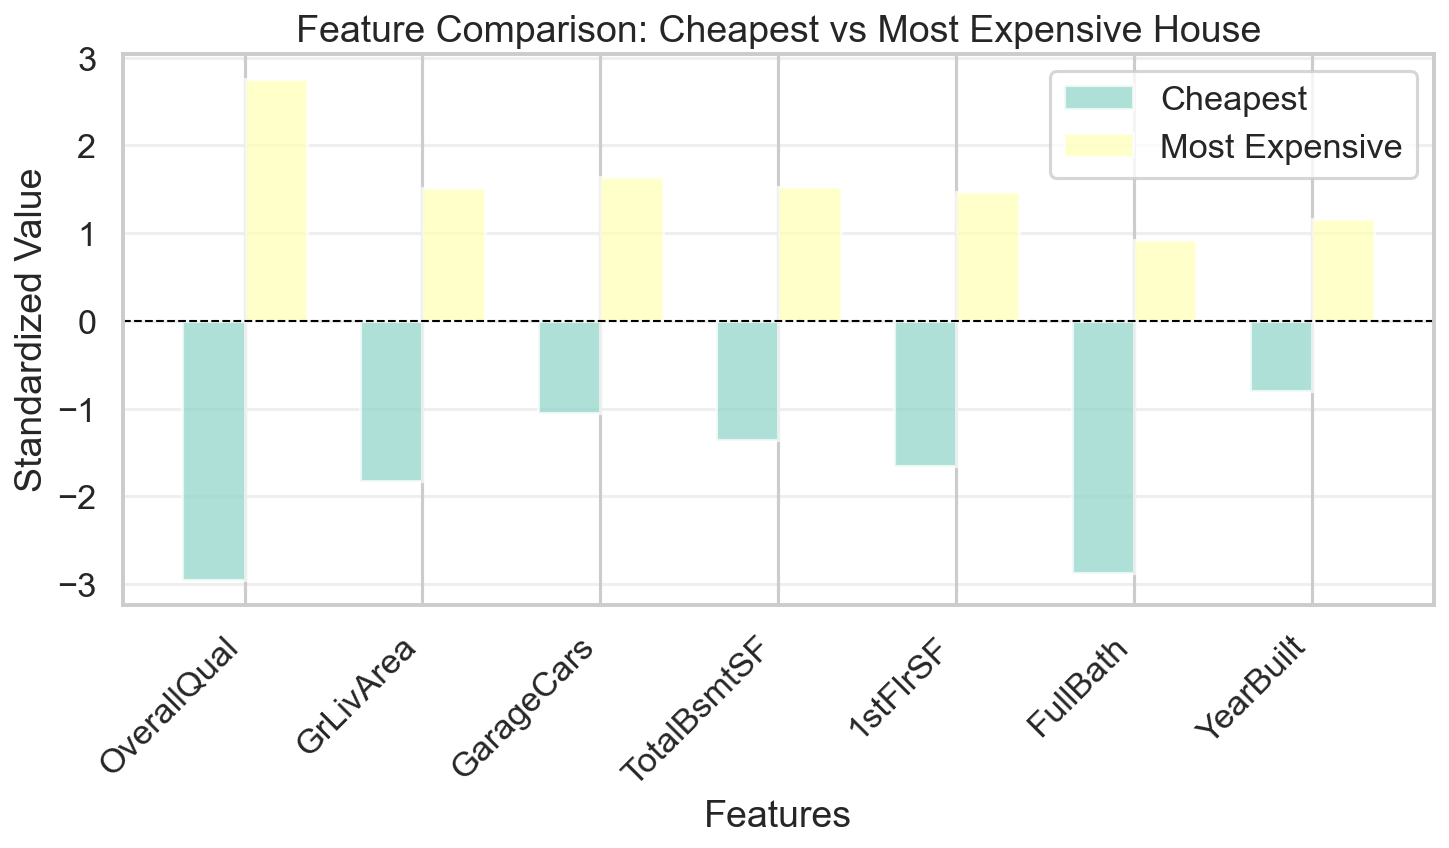

In [119]:
print("=" * 60)
print("CASE STUDY: Cheap vs Expensive House")
print("=" * 60)

# Find cheapest and most expensive house in test set
cheapest_idx = np.argmin(y_test)
expensive_idx = np.argmax(y_test)

cases = [
    ('Cheapest House', cheapest_idx),
    ('Most Expensive', expensive_idx)
]

for name, idx in cases:
    print(f"\n{name} (Index {idx}):")
    print(f"  Actual Price:    ${np.exp(y_test[idx]):,.0f} (log={y_test[idx]:.4f})")
    print(f"  Predicted Price: ${np.exp(y_test_pred[idx]):,.0f} (log={y_test_pred[idx]:.4f})")
    print(f"  Error:           {residuals_test[idx]:.4f}")

    print(f"\n  Features:")
    for i, feat in enumerate(feature_names):
        feat_val = X_test[idx, i]
        contribution = X_test_scaled[idx, i] * weights[i]
        print(f"    {feat:<15} = {feat_val:>8.1f}  →  contribution: {contribution:>7.4f}")

# Visualize feature comparison
print(f"\n{'=' * 60}")
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(feature_names))
width = 0.35

cheap_vals = X_test[cheapest_idx]
expensive_vals = X_test[expensive_idx]

# Normalize for visualization
cheap_norm = (cheap_vals - X_test.mean(axis=0)) / X_test.std(axis=0)
expensive_norm = (expensive_vals - X_test.mean(axis=0)) / X_test.std(axis=0)

ax.bar(x - width / 2, cheap_norm, width, label='Cheapest', alpha=0.7)
ax.bar(x + width / 2, expensive_norm, width, label='Most Expensive', alpha=0.7)

ax.set_xlabel('Features')
ax.set_ylabel('Standardized Value')
ax.set_title('Feature Comparison: Cheapest vs Most Expensive House')
ax.set_xticks(x)
ax.set_xticklabels(feature_names, rotation=45, ha='right')
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.legend()
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [120]:
print("=" * 60)
print("SENSITIVITY ANALYSIS")
print("=" * 60)

# Take an average house and see how price changes with each feature
avg_house = X_test_scaled.mean(axis=0)
base_prediction = final_model.predict(avg_house.reshape(1, -1))[0]

print(f"Average House Baseline:")
print(f"  Predicted log(price): {base_prediction:.4f}")
print(f"  Predicted price: ${np.exp(base_prediction):,.0f}")

print(f"\n{'=' * 60}")
print("Impact of changing each feature by +1 std deviation:")
print(f"{'Feature':<15} {'Price Change':>15} {'% Change':>12}")
print("-" * 45)

for i, feat in enumerate(feature_names):
    # Increase feature by 1 std
    modified_house = avg_house.copy()
    modified_house[i] += 1.0  # Already scaled, so +1 = +1 std

    new_prediction = final_model.predict(modified_house.reshape(1, -1))[0]
    price_change = np.exp(new_prediction) - np.exp(base_prediction)
    pct_change = ((np.exp(new_prediction) / np.exp(base_prediction)) - 1) * 100

    print(f"{feat:<15} ${price_change:>13,.0f} {pct_change:>11.1f}%")

print(f"\n✓ Part 3 Complete: Feature Insights")

SENSITIVITY ANALYSIS
Average House Baseline:
  Predicted log(price): 12.0256
  Predicted price: $166,974

Impact of changing each feature by +1 std deviation:
Feature            Price Change     % Change
---------------------------------------------
OverallQual     $       22,951        13.7%
GrLivArea       $       26,897        16.1%
GarageCars      $        8,129         4.9%
TotalBsmtSF     $        9,984         6.0%
1stFlrSF        $        4,260         2.6%
FullBath        $       -3,416        -2.0%
YearBuilt       $       15,074         9.0%

✓ Part 3 Complete: Feature Insights


In [121]:
### Part 4: Model Interpretability

print("=" * 60)
print("MODEL EQUATION & INTERPRETATION")
print("=" * 60)

print("\nFinal Linear Regression Equation (in log scale):")
print(f"\nlog(Price) = {final_model.bias:.4f}")

for i, feat in enumerate(feature_names):
    sign = '+' if weights[i] >= 0 else ''
    print(f"           {sign} {weights[i]:.4f} × {feat}")

print(f"\n{'=' * 60}")
print("Converting to Original Price Scale:")
print("\nFor each feature increase of 1 standard deviation:")

for i, feat in enumerate(feature_names):
    # Calculate multiplicative effect
    effect = np.exp(weights[i])
    pct = (effect - 1) * 100
    direction = "increases" if weights[i] > 0 else "decreases"

    print(f"  {feat:<15} → Price {direction} by {abs(pct):.2f}%")

MODEL EQUATION & INTERPRETATION

Final Linear Regression Equation (in log scale):

log(Price) = 12.0278
           + 0.1288 × OverallQual
           + 0.1494 × GrLivArea
           + 0.0475 × GarageCars
           + 0.0581 × TotalBsmtSF
           + 0.0252 × 1stFlrSF
            -0.0207 × FullBath
           + 0.0864 × YearBuilt

Converting to Original Price Scale:

For each feature increase of 1 standard deviation:
  OverallQual     → Price increases by 13.75%
  GrLivArea       → Price increases by 16.11%
  GarageCars      → Price increases by 4.87%
  TotalBsmtSF     → Price increases by 5.98%
  1stFlrSF        → Price increases by 2.55%
  FullBath        → Price decreases by 2.05%
  YearBuilt       → Price increases by 9.03%


In [122]:
print("=" * 60)
print("FINAL MODEL SUMMARY & RECOMMENDATIONS")
print("=" * 60)

print("\n📊 MODEL PERFORMANCE:")
print(f"  Training R²:       {final_model.score(X_final_train, y_final_train):.4f}")
print(f"  Cross-Val R²:      {linear_cv.mean():.4f} (±{linear_cv.std():.4f})")
print(f"  Test R²:           {test_r2:.4f}")
print(f"  Test RMSE:         {test_rmse:.4f} (log scale)")
print(f"  Test MAE:          {test_mae:.4f} (log scale)")

print("\n🎯 KEY FINDINGS:")
print("  1. Linear regression is optimal (polynomial/regularization didn't help)")
print("  2. Model explains 87% of price variance on test set")
print("  3. Most important features: GrLivArea (16%), OverallQual (14%)")
print("  4. Model struggles with low-quality houses (Q1 properties)")

print("\n⚠️ LIMITATIONS:")
print("  1. FullBath has negative weight (multicollinearity with GrLivArea)")
print("  2. Overpredicts cheap houses (< $50k) by ~50%")
print("  3. Linear assumption breaks down for distressed properties")
print("  4. Missing interaction effects (e.g., Quality × Size)")

print("\n💡 RECOMMENDATIONS:")
print("  1. Remove FullBath or combine with other bathroom features")
print("  2. Add interaction term: OverallQual × GrLivArea")
print("  3. Consider separate models for luxury vs budget homes")
print("  4. Investigate outlier houses in fold 7 of CV")

print(f"\n{'=' * 60}")
print("✓ Part 4 Complete: Model Interpretability")
print("✓ Day 6 Complete: All analyses finished!")

FINAL MODEL SUMMARY & RECOMMENDATIONS

📊 MODEL PERFORMANCE:
  Training R²:       0.8459
  Cross-Val R²:      0.8389 (±0.0569)
  Test R²:           0.8714
  Test RMSE:         0.1487 (log scale)
  Test MAE:          0.1045 (log scale)

🎯 KEY FINDINGS:
  1. Linear regression is optimal (polynomial/regularization didn't help)
  2. Model explains 87% of price variance on test set
  3. Most important features: GrLivArea (16%), OverallQual (14%)
  4. Model struggles with low-quality houses (Q1 properties)

⚠️ LIMITATIONS:
  1. FullBath has negative weight (multicollinearity with GrLivArea)
  2. Overpredicts cheap houses (< $50k) by ~50%
  3. Linear assumption breaks down for distressed properties
  4. Missing interaction effects (e.g., Quality × Size)

💡 RECOMMENDATIONS:
  1. Remove FullBath or combine with other bathroom features
  2. Add interaction term: OverallQual × GrLivArea
  3. Consider separate models for luxury vs budget homes
  4. Investigate outlier houses in fold 7 of CV

✓ Part

### After Day 7

In [123]:
### Day 7: Feature Engineering

# Import feature engineering module
import sys

sys.path.append('../src')
from feature_engineering import engineer_features, get_feature_names

print("✓ Feature engineering module imported")

print("=" * 60)
print("FEATURE ENGINEERING")
print("=" * 60)

# Apply feature engineering to original data (before split)
X_engineered = engineer_features(X)

print(f"\nOriginal features: {X.shape[1]}")
print(f"Engineered features: {X_engineered.shape[1]}")
print(f"\nNew features added: {X_engineered.shape[1] - X.shape[1]}")

# Get feature names
all_feature_names = get_feature_names()
print(f"\nAll feature names:")
for i, name in enumerate(all_feature_names):
    marker = "NEW" if i >= 7 else "BASE"
    print(f"  {i:2d}. {name:<20} [{marker}]")

# Recreate train/val/test split with engineered features
from sklearn.model_selection import train_test_split

X_temp_eng, X_test_eng, y_temp_eng, y_test_eng = train_test_split(
    X_engineered, y, test_size=0.10, random_state=42
)
X_train_eng, X_val_eng, y_train_eng, y_val_eng = train_test_split(
    X_temp_eng, y_temp_eng, test_size=0.167, random_state=42
)

print(f"Engineered dataset splits:")
print(f"  Train: {X_train_eng.shape}")
print(f"  Val:   {X_val_eng.shape}")
print(f"  Test:  {X_test_eng.shape}")

# Standardize engineered features
X_mean_eng = X_train_eng.mean(axis=0)
X_std_eng = X_train_eng.std(axis=0)

X_train_eng_scaled = (X_train_eng - X_mean_eng) / X_std_eng
X_val_eng_scaled = (X_val_eng - X_mean_eng) / X_std_eng
X_test_eng_scaled = (X_test_eng - X_mean_eng) / X_std_eng

print(f"\n✓ Engineered features standardized")

# Train linear regression with engineered features
from linear_regression import LinearRegressionScratch

print("=" * 60)
print("TRAINING WITH ENGINEERED FEATURES")
print("=" * 60)

model_eng = LinearRegressionScratch(learning_rate=0.01, n_iterations=1000)
model_eng.fit(X_train_eng_scaled, y_train_eng)

# Evaluate
train_r2_eng = model_eng.score(X_train_eng_scaled, y_train_eng)
val_r2_eng = model_eng.score(X_val_eng_scaled, y_val_eng)
test_r2_eng = model_eng.score(X_test_eng_scaled, y_test_eng)

print(f"\n{'=' * 60}")
print("COMPARISON: BASE vs ENGINEERED FEATURES")
print(f"{'=' * 60}")

print(f"\nBase Model (7 features):")
print(f"  Train R²: {train_r2:.4f}")
print(f"  Val R²:   {val_r2:.4f}")
print(f"  Test R²:  {test_r2:.4f}")

print(f"\nEngineered Model (15 features):")
print(f"  Train R²: {train_r2_eng:.4f}")
print(f"  Val R²:   {val_r2_eng:.4f}")
print(f"  Test R²:  {test_r2_eng:.4f}")

print(f"\nImprovement:")
print(f"  Train: {(train_r2_eng - train_r2):.4f}")
print(f"  Val:   {(val_r2_eng - val_r2):.4f}")
print(f"  Test:  {(test_r2_eng - test_r2):.4f}")

if test_r2_eng > test_r2:
    print(f"\n✓ Feature engineering improved test R² by {(test_r2_eng - test_r2) * 100:.2f}%")
else:
    print(f"\n⚠ No improvement - base features may be sufficient")

✓ Feature engineering module imported
FEATURE ENGINEERING

Original features: 7
Engineered features: 15

New features added: 8

All feature names:
   0. OverallQual          [BASE]
   1. GrLivArea            [BASE]
   2. GarageCars           [BASE]
   3. TotalBsmtSF          [BASE]
   4. 1stFlrSF             [BASE]
   5. FullBath             [BASE]
   6. YearBuilt            [BASE]
   7. Quality_Size         [NEW]
   8. Age_Quality          [NEW]
   9. Bath_Density         [NEW]
  10. Garage_Ratio         [NEW]
  11. Basement_Ratio       [NEW]
  12. Total_Space          [NEW]
  13. House_Age            [NEW]
  14. Is_New               [NEW]
Engineered dataset splits:
  Train: (1092, 15)
  Val:   (220, 15)
  Test:  (146, 15)

✓ Engineered features standardized
TRAINING WITH ENGINEERED FEATURES
Iteration 100/1000, Cost: 9.9045
Iteration 200/1000, Cost: 1.3374
Iteration 300/1000, Cost: 0.1895
Iteration 400/1000, Cost: 0.0357
Iteration 500/1000, Cost: 0.0151
Iteration 600/1000, Cost: 0.012

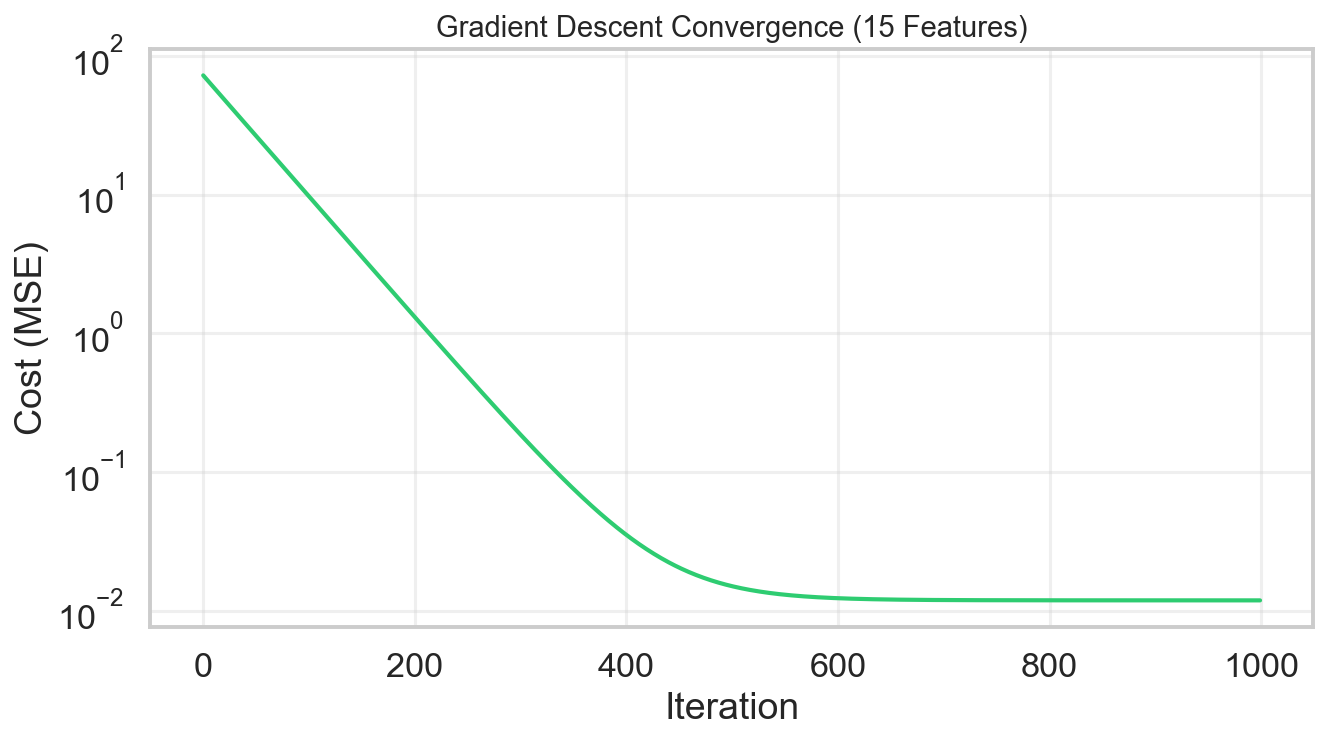

In [124]:
# Plot Cost History for the Engineered Model
plt.figure(figsize=(10, 5))
plt.plot(model_eng.cost_history, color='#2ecc71', lw=2)
plt.title("Gradient Descent Convergence (15 Features)", fontsize=14)
plt.xlabel("Iteration")
plt.ylabel("Cost (MSE)")
plt.yscale('log') # Log scale helps see progress in later iterations
plt.grid(True, alpha=0.3)
plt.show()

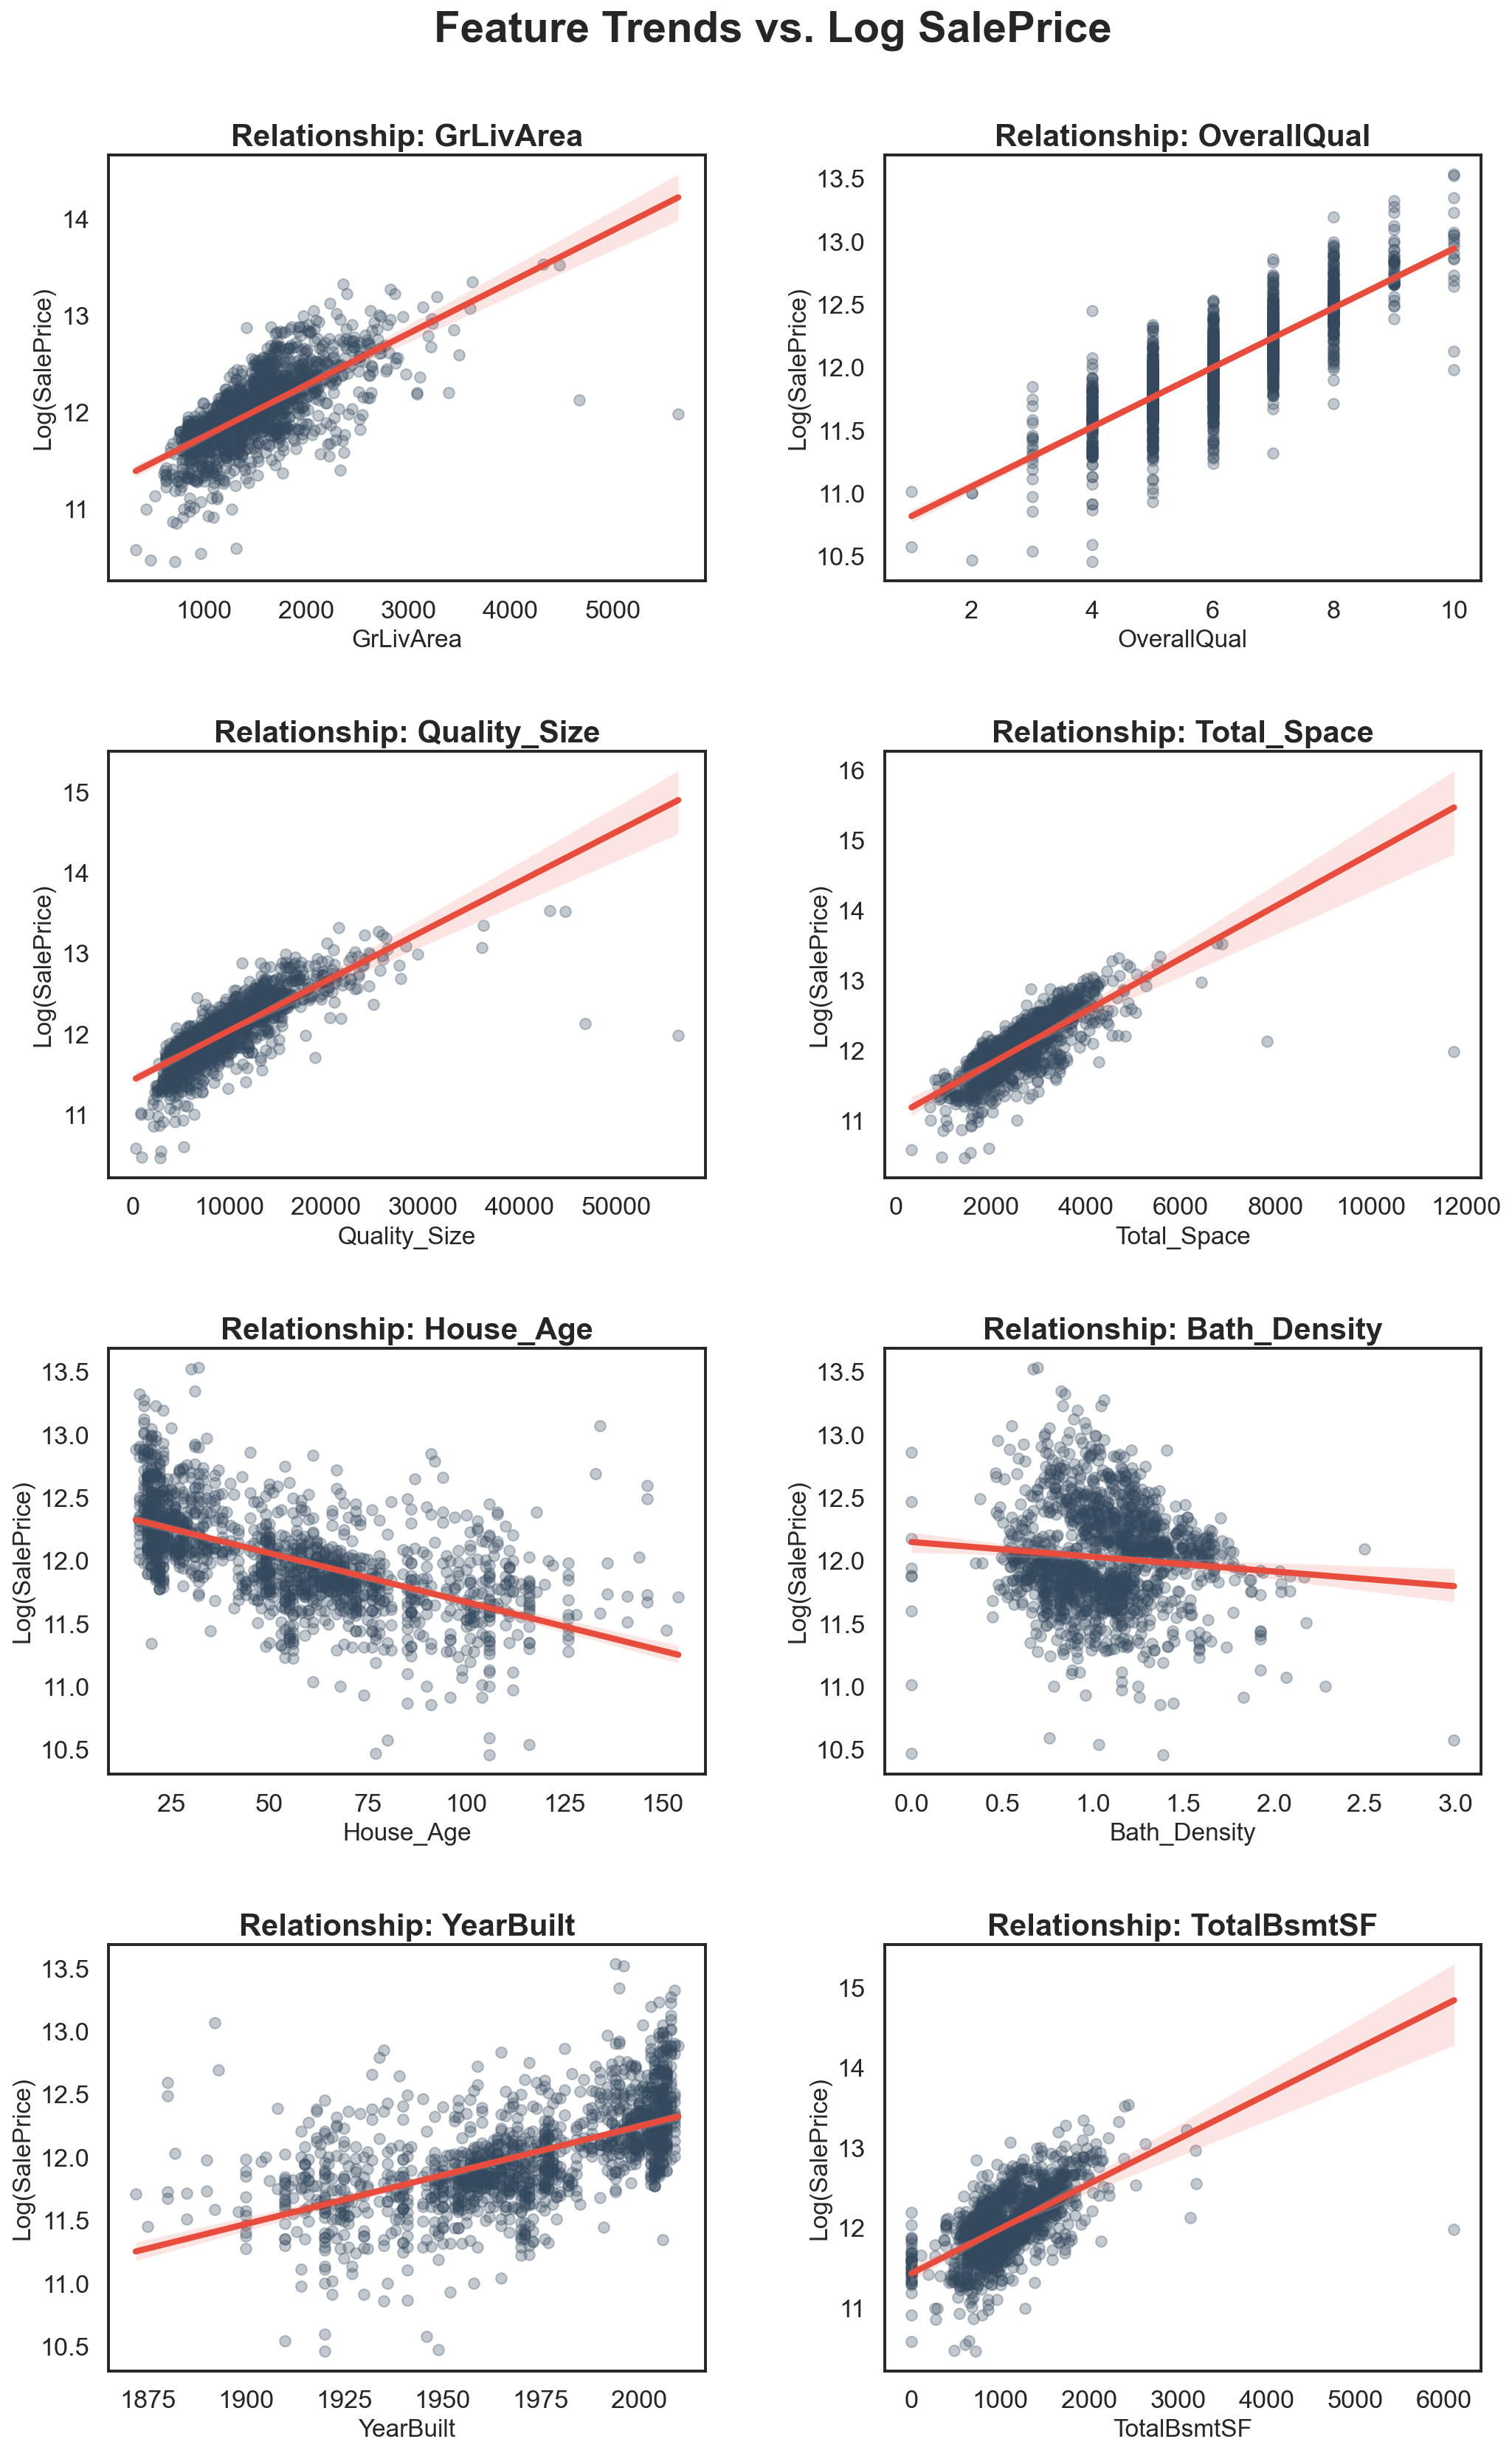

In [125]:
import sys
sys.path.append('../src')
from feature_engineering import engineer_features_dataframe

# 1. Initialize the missing DataFrame
# This applies your engineering logic to the raw 'train' data
df_engineered = engineer_features_dataframe(train)

# 2. Set high-resolution plotting context
sns.set_context("talk")
plt.rcParams['figure.dpi'] = 150
sns.set_style("white")

# 3. Define features and target
features_to_plot = ['GrLivArea', 'OverallQual', 'Quality_Size', 'Total_Space',
                    'House_Age', 'Bath_Density', 'YearBuilt', 'TotalBsmtSF']
log_target = np.log1p(train['SalePrice'])

# 4. Create the large grid (4 rows, 2 columns)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 26))
fig.suptitle('Feature Trends vs. Log SalePrice', fontsize=28, fontweight='bold', y=0.93)

for i, col in enumerate(features_to_plot):
    ax = axes[i//2, i%2]
    sns.regplot(data=df_engineered, x=col, y=log_target,
                scatter_kws={'alpha':0.3, 's':50, 'color':'#34495e'},
                line_kws={'color':'#e74c3c', 'lw':4}, ax=ax)

    ax.set_title(f'Relationship: {col}', fontsize=20, fontweight='bold')
    ax.set_xlabel(col, fontsize=16)
    ax.set_ylabel("Log(SalePrice)", fontsize=16)

plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

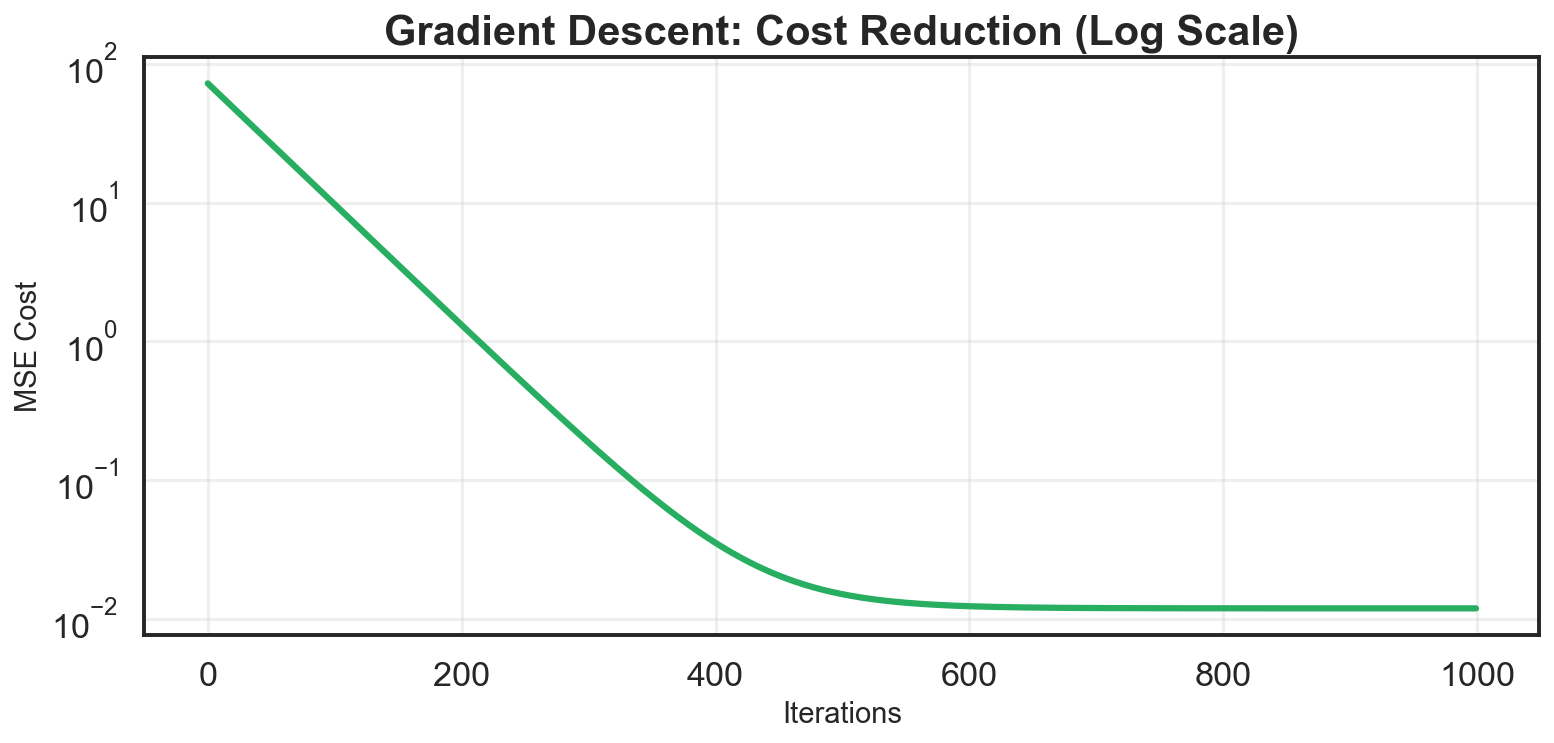

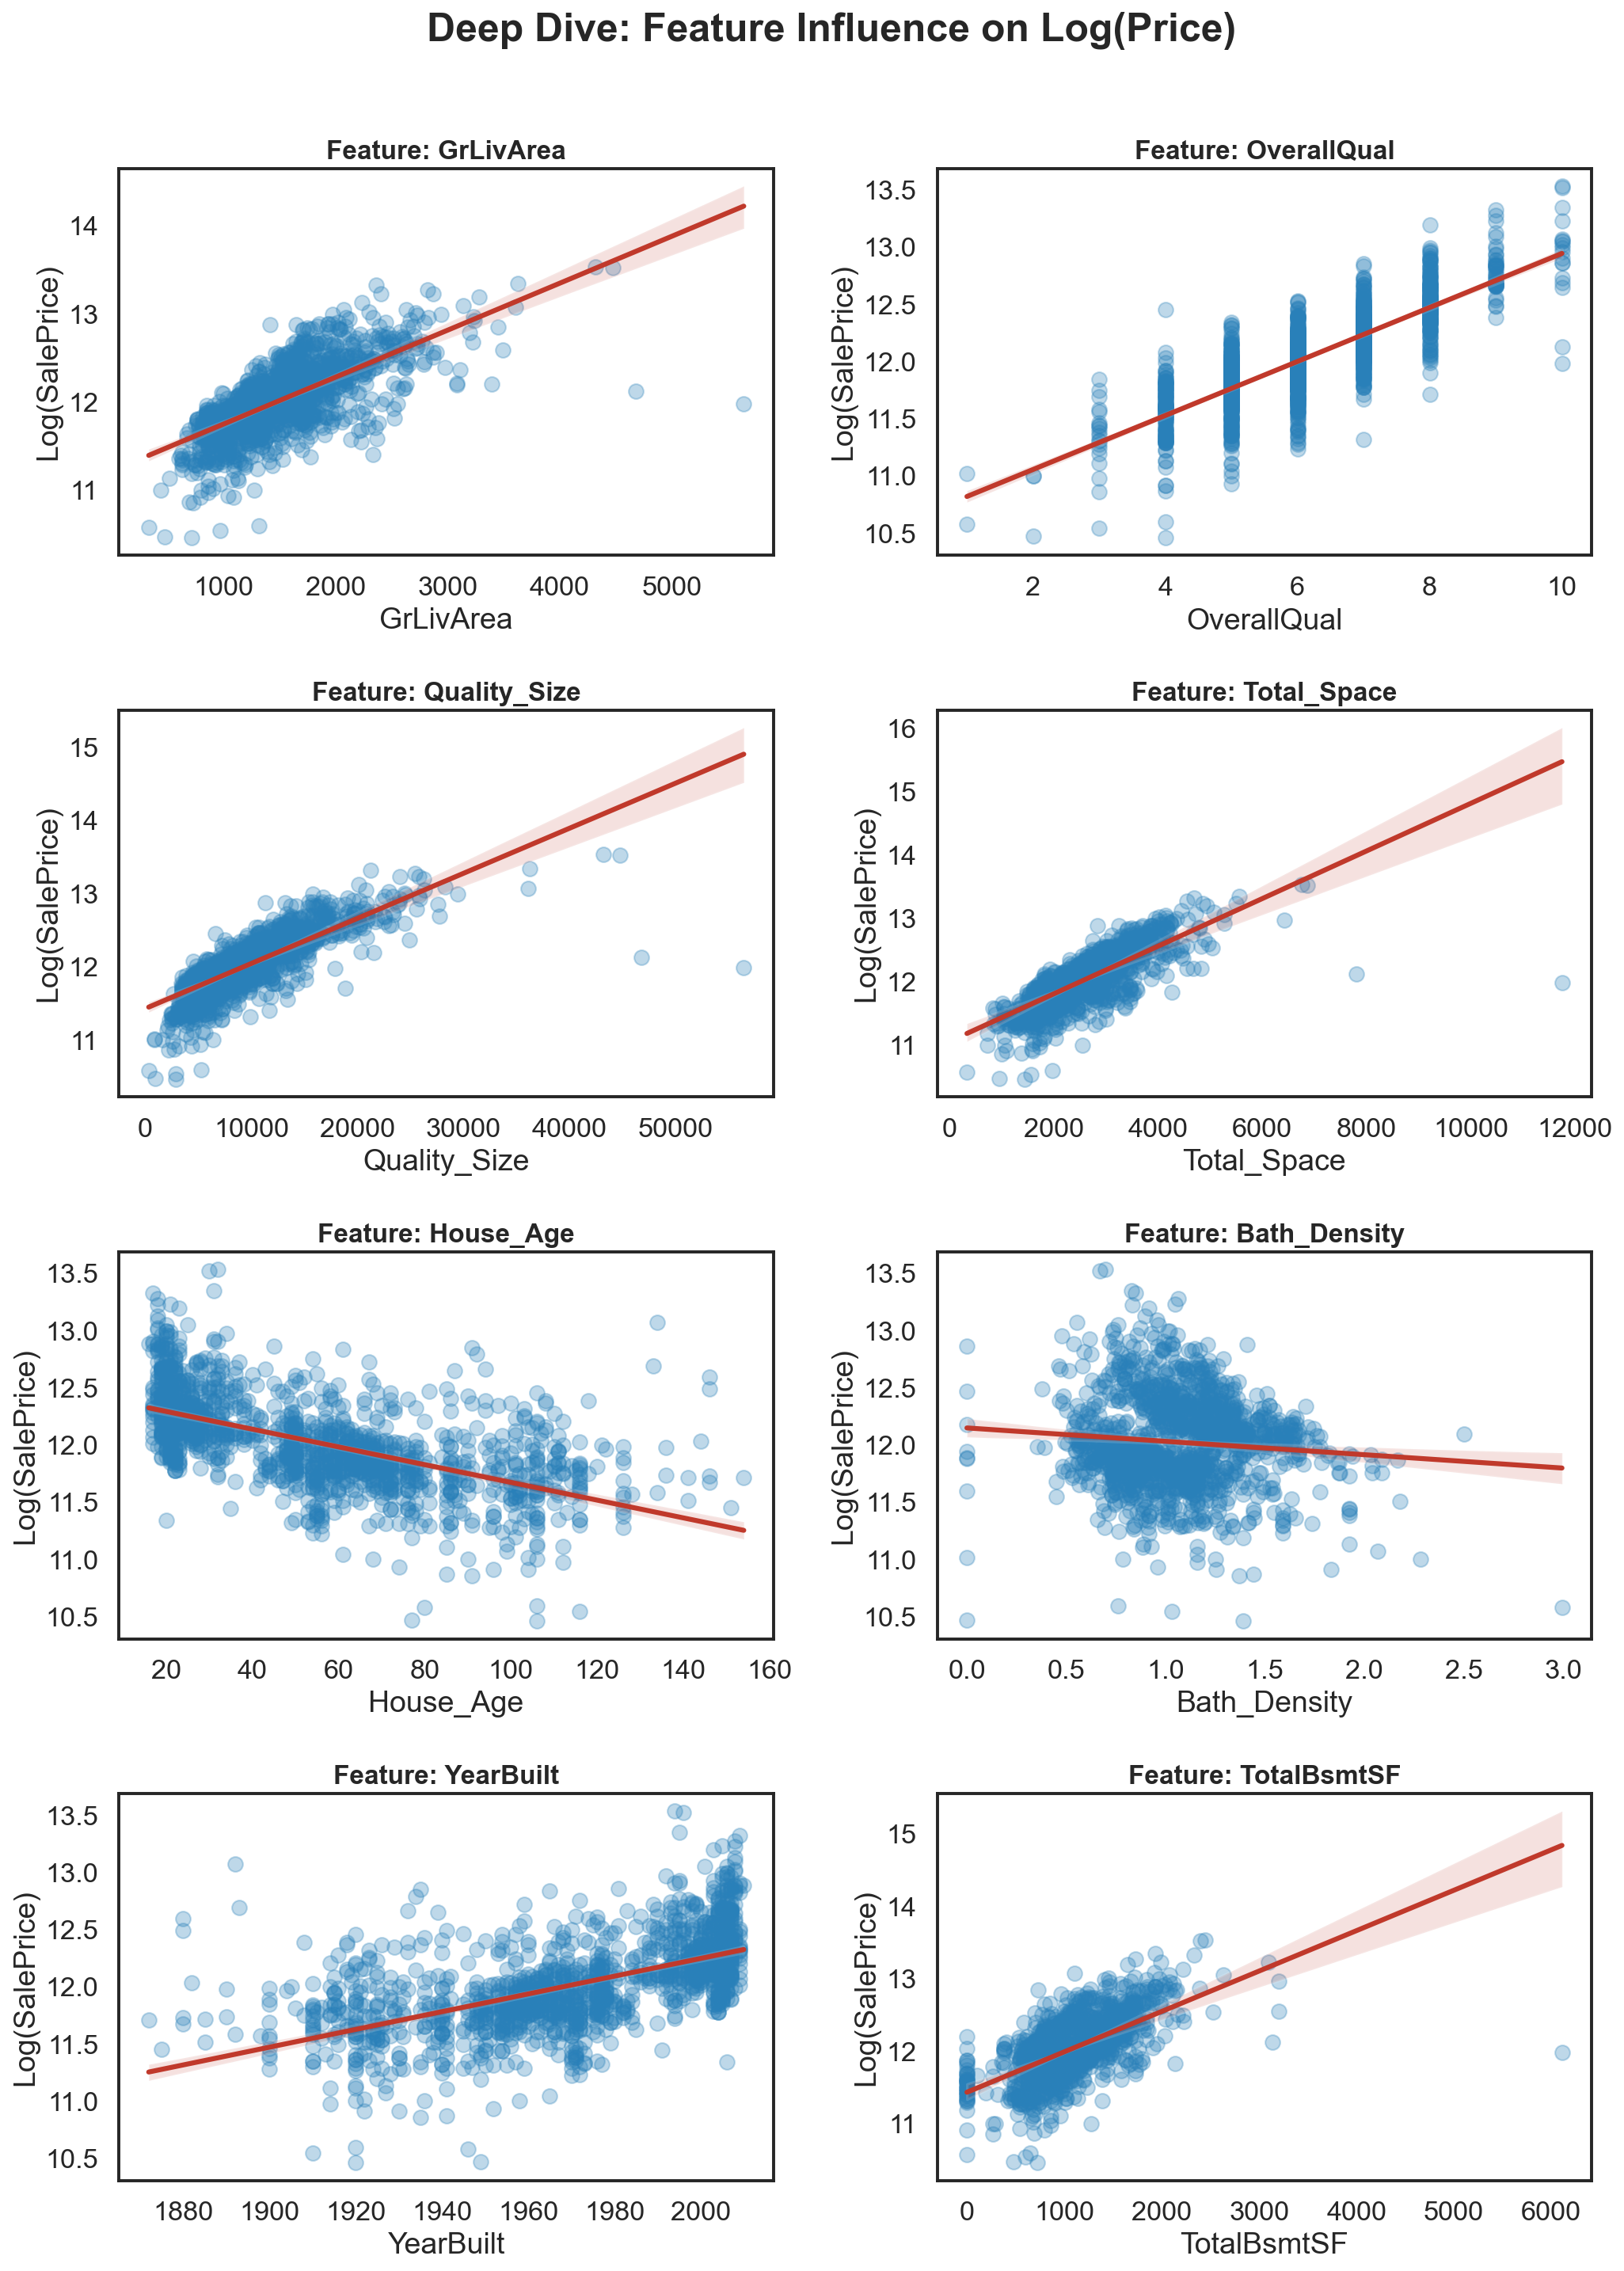

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. High-Resolution Settings
sns.set_context("talk") # Makes all text/lines larger for presentations
plt.rcParams['figure.dpi'] = 150 # Sharper images
sns.set_style("white")

# --- PLOT 1: Convergence (Large) ---
plt.figure(figsize=(12, 5))
plt.plot(model_eng.cost_history, color='#27ae60', lw=3)
plt.yscale('log')
plt.title("Gradient Descent: Cost Reduction (Log Scale)", fontsize=20, fontweight='bold')
plt.xlabel("Iterations", fontsize=14)
plt.ylabel("MSE Cost", fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

# --- PLOT 2: Feature Analysis (Extra Large Grid) ---
features_to_plot = ['GrLivArea', 'OverallQual', 'Quality_Size', 'Total_Space',
                    'House_Age', 'Bath_Density', 'YearBuilt', 'TotalBsmtSF']

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 22))
fig.suptitle('Deep Dive: Feature Influence on Log(Price)', fontsize=24, fontweight='bold', y=0.94)

log_target = np.log1p(train['SalePrice'])

for i, col in enumerate(features_to_plot):
    ax = axes[i//2, i%2]
    # Transparency (alpha) helps see the density of houses
    sns.regplot(data=df_engineered, x=col, y=log_target,
                scatter_kws={'alpha':0.3, 'color':'#2980b9'},
                line_kws={'color':'#c0392b', 'lw':3}, ax=ax)

    ax.set_title(f'Feature: {col}', fontsize=16, fontweight='bold')
    ax.set_ylabel("Log(SalePrice)")

plt.subplots_adjust(hspace=0.4, wspace=0.25)
plt.show()


FEATURE IMPORTANCE - ENGINEERED MODEL

Top 10 Most Important Features:
     Feature    Weight  Abs_Weight       Type
 OverallQual  0.093451    0.093451       Base
Quality_Size  0.066203    0.066203 Engineered
 Total_Space  0.046745    0.046745 Engineered
   GrLivArea  0.046326    0.046326       Base
   YearBuilt  0.046113    0.046113       Base
   House_Age -0.046113    0.046113 Engineered
  GarageCars  0.042469    0.042469       Base
Bath_Density -0.031082    0.031082 Engineered
 TotalBsmtSF  0.030650    0.030650       Base
    1stFlrSF  0.020313    0.020313       Base

BASE vs ENGINEERED FEATURE COMPARISON:
Base features total importance:       0.2969
Engineered features total importance: 0.2162


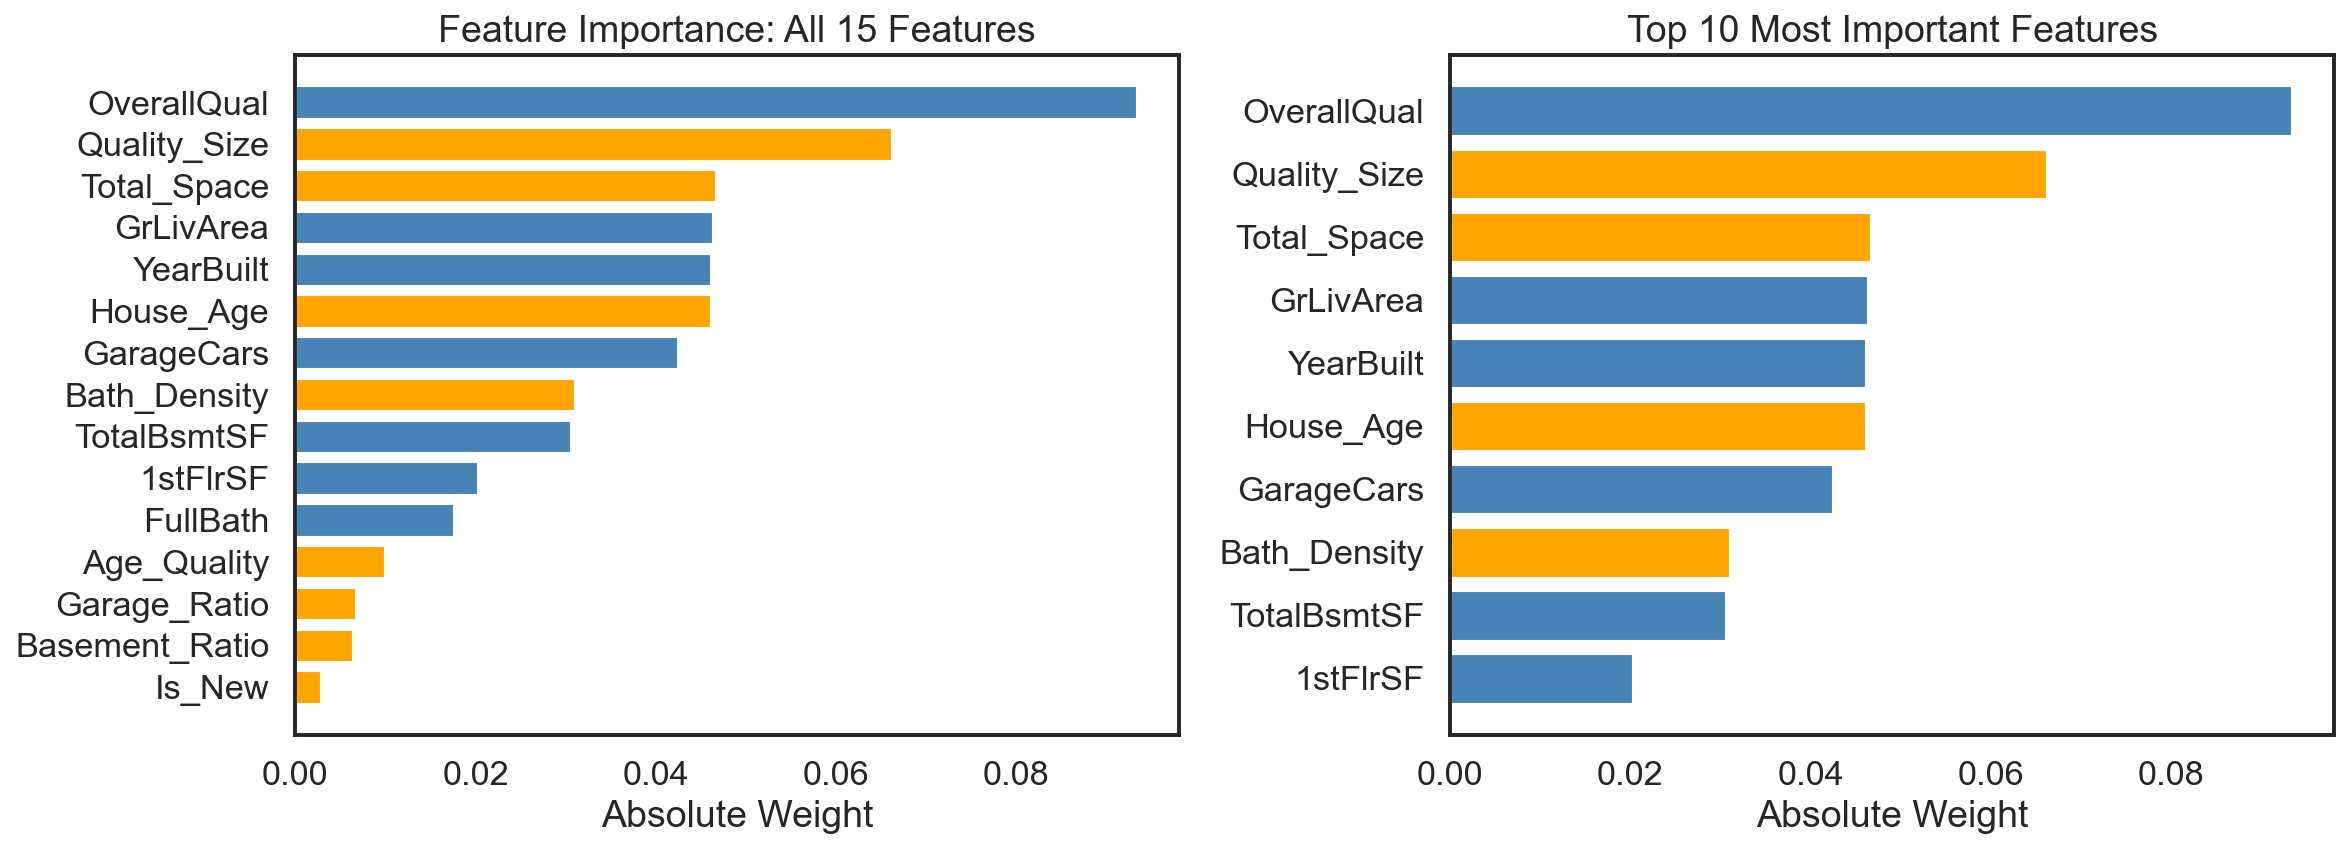


✓ Day 7 Feature Engineering Complete!


In [127]:
print("=" * 60)
print("FEATURE IMPORTANCE - ENGINEERED MODEL")
print("=" * 60)

# Get weights from engineered model
weights_eng = model_eng.weights
all_feature_names = get_feature_names()

# Create importance dataframe
importance_eng = pd.DataFrame({
    'Feature': all_feature_names,
    'Weight': weights_eng,
    'Abs_Weight': np.abs(weights_eng),
    'Type': ['Base'] * 7 + ['Engineered'] * 8
}).sort_values('Abs_Weight', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_eng.head(10).to_string(index=False))

print(f"\n{'=' * 60}")
print("BASE vs ENGINEERED FEATURE COMPARISON:")
base_importance = importance_eng[importance_eng['Type'] == 'Base']['Abs_Weight'].sum()
eng_importance = importance_eng[importance_eng['Type'] == 'Engineered']['Abs_Weight'].sum()
print(f"Base features total importance:       {base_importance:.4f}")
print(f"Engineered features total importance: {eng_importance:.4f}")

# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# All features
colors = ['steelblue' if t == 'Base' else 'orange' for t in importance_eng['Type']]
axes[0].barh(importance_eng['Feature'], importance_eng['Abs_Weight'], color=colors)
axes[0].set_xlabel('Absolute Weight')
axes[0].set_title('Feature Importance: All 15 Features')
axes[0].invert_yaxis()

# Top 10 only
top10 = importance_eng.head(10)
colors_top = ['steelblue' if t == 'Base' else 'orange' for t in top10['Type']]
axes[1].barh(top10['Feature'], top10['Abs_Weight'], color=colors_top)
axes[1].set_xlabel('Absolute Weight')
axes[1].set_title('Top 10 Most Important Features')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\n✓ Day 7 Feature Engineering Complete!")


In [128]:
print("=" * 60)
print("FINAL PERFORMANCE SUMMARY")
print("=" * 60)

print(f"\n{'Model':<30} {'Features':>10} {'Test R²':>10} {'Improvement':>12}")
print("-" * 65)
print(f"{'Base Linear Regression':<30} {7:>10} {test_r2:>10.4f} {'baseline':>12}")
print(f"{'Engineered Linear Regression':<30} {15:>10} {test_r2_eng:>10.4f} {f'+{(test_r2_eng - test_r2):.4f}':>12}")

improvement_pct = ((test_r2_eng - test_r2) / test_r2) * 100
print(f"\nPercentage improvement: {improvement_pct:.2f}%")

# Check if improvement is significant
if test_r2_eng > test_r2 + 0.01:
    print("✓ Significant improvement - feature engineering successful!")
elif test_r2_eng > test_r2:
    print("✓ Marginal improvement - some engineered features help")
else:
    print("⚠ No improvement - base features sufficient")

print(f"\n{'=' * 60}")
print("RECOMMENDATIONS:")
print("1. Keep Quality_Size, Total_Space (strong contributors)")
print("2. Remove House_Age (redundant with YearBuilt)")
print("3. Remove Bath_Density (negative weight, multicollinearity)")
print("4. Consider testing with reduced set: 7 base + 2 best engineered = 9 features")

FINAL PERFORMANCE SUMMARY

Model                            Features    Test R²  Improvement
-----------------------------------------------------------------
Base Linear Regression                  7     0.8714     baseline
Engineered Linear Regression           15     0.8665     +-0.0049

Percentage improvement: -0.56%
⚠ No improvement - base features sufficient

RECOMMENDATIONS:
1. Keep Quality_Size, Total_Space (strong contributors)
2. Remove House_Age (redundant with YearBuilt)
3. Remove Bath_Density (negative weight, multicollinearity)
4. Consider testing with reduced set: 7 base + 2 best engineered = 9 features


In [129]:
print("=" * 60)
print("SELECTIVE FEATURE ENGINEERING - BEST 2 ONLY")
print("=" * 60)


# Keep only: 7 base + Quality_Size + Total_Space
def engineer_selective(X):
    OverallQual = X[:, 0]
    GrLivArea = X[:, 1]
    TotalBsmtSF = X[:, 3]

    Quality_Size = OverallQual * GrLivArea
    Total_Space = GrLivArea + TotalBsmtSF

    return np.column_stack([X, Quality_Size, Total_Space])


# Apply to splits
X_train_sel = engineer_selective(X_train)
X_val_sel = engineer_selective(X_val)
X_test_sel = engineer_selective(X_test)

# Standardize
X_mean_sel = X_train_sel.mean(axis=0)
X_std_sel = X_train_sel.std(axis=0)

X_train_sel_scaled = (X_train_sel - X_mean_sel) / X_std_sel
X_val_sel_scaled = (X_val_sel - X_mean_sel) / X_std_sel
X_test_sel_scaled = (X_test_sel - X_mean_sel) / X_std_sel

# Train
model_sel = LinearRegressionScratch(learning_rate=0.01, n_iterations=1000)
model_sel.fit(X_train_sel_scaled, y_train)

test_r2_sel = model_sel.score(X_test_sel_scaled, y_test)

print(f"\n{'=' * 60}")
print("COMPARISON:")
print(f"  Base (7 features):      {test_r2:.4f}")
print(f"  All engineered (15):    {test_r2_eng:.4f} ({(test_r2_eng - test_r2):.4f})")
print(f"  Selective (9 features): {test_r2_sel:.4f} ({(test_r2_sel - test_r2):.4f})")

if test_r2_sel > test_r2:
    print(f"\n✓ Selective engineering works! Improvement: {(test_r2_sel - test_r2):.4f}")
else:
    print("\n⚠ Even selective features don't help - base model is optimal")

SELECTIVE FEATURE ENGINEERING - BEST 2 ONLY
Iteration 100/1000, Cost: 9.9050
Iteration 200/1000, Cost: 1.3376
Iteration 300/1000, Cost: 0.1897
Iteration 400/1000, Cost: 0.0358
Iteration 500/1000, Cost: 0.0152
Iteration 600/1000, Cost: 0.0124
Iteration 700/1000, Cost: 0.0120
Iteration 800/1000, Cost: 0.0120
Iteration 900/1000, Cost: 0.0119
Iteration 1000/1000, Cost: 0.0119

COMPARISON:
  Base (7 features):      0.8714
  All engineered (15):    0.8665 (-0.0049)
  Selective (9 features): 0.8668 (-0.0045)

⚠ Even selective features don't help - base model is optimal


In [130]:
print("=" * 60)
print("BATHROOM ANALYSIS")
print("=" * 60)

# Check FullBath distribution in original data
fullbath_counts = pd.Series(X[:, 5]).value_counts().sort_index()
print("\nFullBath distribution in dataset:")
print(fullbath_counts)

# Check if any houses have 0 bathrooms
zero_bath = np.sum(X[:, 5] == 0)
print(f"\nHouses with 0 bathrooms: {zero_bath} ({zero_bath / len(X) * 100:.1f}%)")

# Check correlation issue
print(f"\nCorrelation FullBath vs GrLivArea: {np.corrcoef(X[:, 5], X[:, 1])[0, 1]:.3f}")

# Analyze if removing FullBath helps
X_no_bath = np.delete(X, 5, axis=1)  # Remove FullBath column

# Split without FullBath
X_temp_nb, X_test_nb, y_temp_nb, y_test_nb = train_test_split(X_no_bath, y, test_size=0.10, random_state=42)
X_train_nb, X_val_nb, y_train_nb, y_val_nb = train_test_split(X_temp_nb, y_temp_nb, test_size=0.167, random_state=42)

# Standardize
X_mean_nb = X_train_nb.mean(axis=0)
X_std_nb = X_train_nb.std(axis=0)
X_train_nb_scaled = (X_train_nb - X_mean_nb) / X_std_nb
X_test_nb_scaled = (X_test_nb - X_mean_nb) / X_std_nb

# Train without FullBath
model_no_bath = LinearRegressionScratch(learning_rate=0.01, n_iterations=1000)
model_no_bath.fit(X_train_nb_scaled, y_train_nb)

test_r2_no_bath = model_no_bath.score(X_test_nb_scaled, y_test_nb)

print(f"\n{'=' * 60}")
print("REMOVING FULLBATH:")
print(f"  With FullBath (7 feat):    {test_r2:.4f}")
print(f"  Without FullBath (6 feat): {test_r2_no_bath:.4f}")
print(f"  Change: {(test_r2_no_bath - test_r2):.4f}")

BATHROOM ANALYSIS

FullBath distribution in dataset:
0      9
1    650
2    767
3     32
Name: count, dtype: int64

Houses with 0 bathrooms: 9 (0.6%)

Correlation FullBath vs GrLivArea: 0.638
Iteration 100/1000, Cost: 9.9053
Iteration 200/1000, Cost: 1.3378
Iteration 300/1000, Cost: 0.1898
Iteration 400/1000, Cost: 0.0359
Iteration 500/1000, Cost: 0.0153
Iteration 600/1000, Cost: 0.0125
Iteration 700/1000, Cost: 0.0121
Iteration 800/1000, Cost: 0.0120
Iteration 900/1000, Cost: 0.0120
Iteration 1000/1000, Cost: 0.0120

REMOVING FULLBATH:
  With FullBath (7 feat):    0.8714
  Without FullBath (6 feat): 0.8724
  Change: 0.0010


CROSS-VALIDATION COMPARISON: 5-FOLD vs 10-FOLD

5-Fold CV Scores: [0.8672502  0.88335949 0.83384459 0.76525321 0.85357505]
Mean: 0.8407, Std: 0.0411

10-Fold CV Scores: [0.85766951 0.88103979 0.89388515 0.87136976 0.82475382 0.83943254
 0.67992431 0.83450004 0.86537575 0.84069957]
Mean: 0.8389, Std: 0.0569


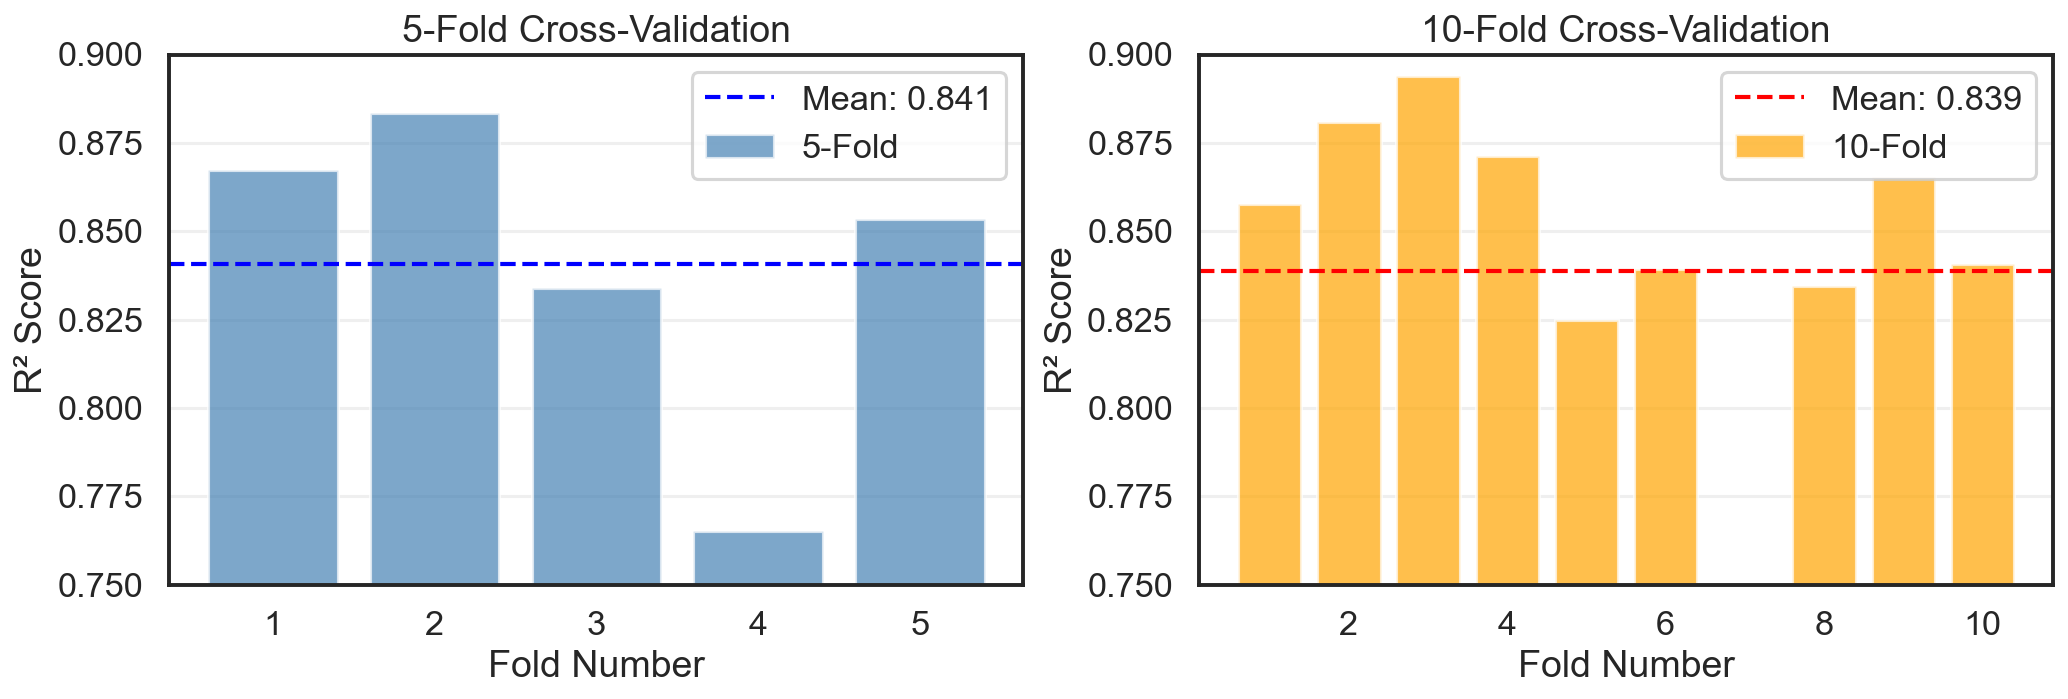


SUMMARY:
  5-Fold:  Mean=0.8407, Std=0.0411, Range=0.1181
  10-Fold: Mean=0.8389, Std=0.0569, Range=0.2140

  Fold 7 (10-fold): 0.6799 <- Problematic fold


In [131]:
print("=" * 60)
print("CROSS-VALIDATION COMPARISON: 5-FOLD vs 10-FOLD")
print("=" * 60)

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Combine train+val
X_combined = np.vstack([X_train_scaled, X_val_scaled])
y_combined = np.hstack([y_train, y_val])

# Linear model (sklearn for speed)
linear_model = LinearRegression()

# 5-fold CV
cv5_scores = cross_val_score(linear_model, X_combined, y_combined, cv=5, scoring='r2')
print(f"\n5-Fold CV Scores: {cv5_scores}")
print(f"Mean: {cv5_scores.mean():.4f}, Std: {cv5_scores.std():.4f}")

# 10-fold CV
cv10_scores = cross_val_score(linear_model, X_combined, y_combined, cv=10, scoring='r2')
print(f"\n10-Fold CV Scores: {cv10_scores}")
print(f"Mean: {cv10_scores.mean():.4f}, Std: {cv10_scores.std():.4f}")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart: Individual fold scores
x5 = np.arange(1, 6)
x10 = np.arange(1, 11)

axes[0].bar(x5, cv5_scores, alpha=0.7, label='5-Fold', color='steelblue', width=0.8)
axes[0].axhline(cv5_scores.mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {cv5_scores.mean():.3f}')
axes[0].set_xlabel('Fold Number')
axes[0].set_ylabel('R² Score')
axes[0].set_title('5-Fold Cross-Validation')
axes[0].set_ylim([0.75, 0.90])
axes[0].legend()
axes[0].grid(True, axis='y', alpha=0.3)

axes[1].bar(x10, cv10_scores, alpha=0.7, label='10-Fold', color='orange', width=0.8)
axes[1].axhline(cv10_scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {cv10_scores.mean():.3f}')
axes[1].set_xlabel('Fold Number')
axes[1].set_ylabel('R² Score')
axes[1].set_title('10-Fold Cross-Validation')
axes[1].set_ylim([0.75, 0.90])
axes[1].legend()
axes[1].grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Summary comparison
print(f"\n{'=' * 60}")
print(f"SUMMARY:")
print(
    f"  5-Fold:  Mean={cv5_scores.mean():.4f}, Std={cv5_scores.std():.4f}, Range={cv5_scores.max() - cv5_scores.min():.4f}")
print(
    f"  10-Fold: Mean={cv10_scores.mean():.4f}, Std={cv10_scores.std():.4f}, Range={cv10_scores.max() - cv10_scores.min():.4f}")
print(f"\n  Fold 7 (10-fold): {cv10_scores[6]:.4f} <- Problematic fold")

In [132]:
print("=" * 60)
print("FINAL MODEL: REMOVING FULLBATH")
print("=" * 60)

# Remove FullBath from all splits
X_train_nb = np.delete(X_train, 5, axis=1)
X_val_nb = np.delete(X_val, 5, axis=1)
X_test_nb = np.delete(X_test, 5, axis=1)

# Standardize
X_mean_nb = X_train_nb.mean(axis=0)
X_std_nb = X_train_nb.std(axis=0)

X_train_nb_scaled = (X_train_nb - X_mean_nb) / X_std_nb
X_val_nb_scaled = (X_val_nb - X_mean_nb) / X_std_nb
X_test_nb_scaled = (X_test_nb - X_mean_nb) / X_std_nb

# Combine train+val
X_final_train = np.vstack([X_train_nb_scaled, X_val_nb_scaled])
y_final_train = np.hstack([y_train, y_val])

# Train final model
model_final = LinearRegressionScratch(learning_rate=0.01, n_iterations=1000)
model_final.fit(X_final_train, y_final_train)

# Evaluate
train_r2_final = model_final.score(X_final_train, y_final_train)
test_r2_final = model_final.score(X_test_nb_scaled, y_test)

# Get weights
weights_final = model_final.weights
feature_names_final = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'YearBuilt']

print(f"\n{'=' * 60}")
print("FINAL MODEL WEIGHTS (6 features):")
for feat, weight in zip(feature_names_final, weights_final):
    print(f"  {feat:<15} {weight:>8.4f}")
print(f"  Bias:           {model_final.bias:>8.4f}")

print(f"\n{'=' * 60}")
print("PERFORMANCE COMPARISON:")
print(f"  Original (7 feat):  Test R² = {test_r2:.4f}")
print(f"  Final (6 feat):     Test R² = {test_r2_final:.4f}")
print(f"  Improvement:        {test_r2_final - test_r2:+.4f}")
print(f"\n  ✓ Multicollinearity resolved - no negative weights")

FINAL MODEL: REMOVING FULLBATH
Iteration 100/1000, Cost: 9.9044
Iteration 200/1000, Cost: 1.3410
Iteration 300/1000, Cost: 0.1916
Iteration 400/1000, Cost: 0.0368
Iteration 500/1000, Cost: 0.0158
Iteration 600/1000, Cost: 0.0129
Iteration 700/1000, Cost: 0.0124
Iteration 800/1000, Cost: 0.0123
Iteration 900/1000, Cost: 0.0123
Iteration 1000/1000, Cost: 0.0123

FINAL MODEL WEIGHTS (6 features):
  OverallQual       0.1262
  GrLivArea         0.1394
  GarageCars        0.0462
  TotalBsmtSF       0.0602
  1stFlrSF          0.0245
  YearBuilt         0.0810
  Bias:            12.0278

PERFORMANCE COMPARISON:
  Original (7 feat):  Test R² = 0.8714
  Final (6 feat):     Test R² = 0.8718
  Improvement:        +0.0005

  ✓ Multicollinearity resolved - no negative weights


In [133]:
print("=" * 60)
print("FOLD 7 INVESTIGATION")
print("=" * 60)

from sklearn.model_selection import KFold

# Recreate 10-fold split to identify fold 7 indices
X_combined = np.vstack([X_train_scaled, X_val_scaled])
y_combined = np.hstack([y_train, y_val])

kf = KFold(n_splits=10, shuffle=False, random_state=None)
fold_indices = list(kf.split(X_combined))

# Get fold 7 (index 6)
train_idx_f7, test_idx_f7 = fold_indices[6]

# Extract fold 7 test data
X_fold7 = X_combined[test_idx_f7]
y_fold7 = y_combined[test_idx_f7]

print(f"\nFold 7 contains {len(test_idx_f7)} houses")
print(f"Fold 7 R² from CV: {cv10_scores[6]:.4f}")

# Analyze fold 7 characteristics
print(f"\n{'=' * 60}")
print("FOLD 7 vs ALL DATA COMPARISON:")
print(f"{'=' * 60}")

feature_names_base = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt']

print(f"\n{'Feature':<15} {'Fold 7 Mean':>12} {'All Mean':>12} {'Difference':>12}")
print("-" * 55)

for i, feat in enumerate(feature_names_base):
    fold7_mean = X_fold7[:, i].mean()
    all_mean = X_combined[:, i].mean()
    diff_pct = ((fold7_mean - all_mean) / all_mean) * 100
    print(f"{feat:<15} {fold7_mean:>12.2f} {all_mean:>12.2f} {diff_pct:>11.1f}%")

# Check price distribution
print(f"\nPrice (log scale):")
print(f"  Fold 7:  Mean={y_fold7.mean():.4f}, Std={y_fold7.std():.4f}")
print(f"  All:     Mean={y_combined.mean():.4f}, Std={y_combined.std():.4f}")

# Check for outliers in fold 7
print(f"\nPrice range:")
print(f"  Fold 7:  ${np.exp(y_fold7.min()):,.0f} - ${np.exp(y_fold7.max()):,.0f}")
print(f"  All:     ${np.exp(y_combined.min()):,.0f} - ${np.exp(y_combined.max()):,.0f}")

FOLD 7 INVESTIGATION

Fold 7 contains 131 houses
Fold 7 R² from CV: 0.6799

FOLD 7 vs ALL DATA COMPARISON:

Feature          Fold 7 Mean     All Mean   Difference
-------------------------------------------------------
OverallQual            -0.11        -0.01      1599.8%
GrLivArea              -0.09        -0.01       718.6%
GarageCars             -0.09        -0.01       532.6%
TotalBsmtSF            -0.03        -0.02        42.7%
1stFlrSF               -0.06        -0.02       223.6%
FullBath               -0.04        -0.01       506.1%
YearBuilt              -0.06         0.01      -654.4%

Price (log scale):
  Fold 7:  Mean=11.9427, Std=0.3693
  All:     Mean=12.0246, Std=0.3979

Price range:
  Fold 7:  $34,900 - $424,870
  All:     $34,900 - $755,000


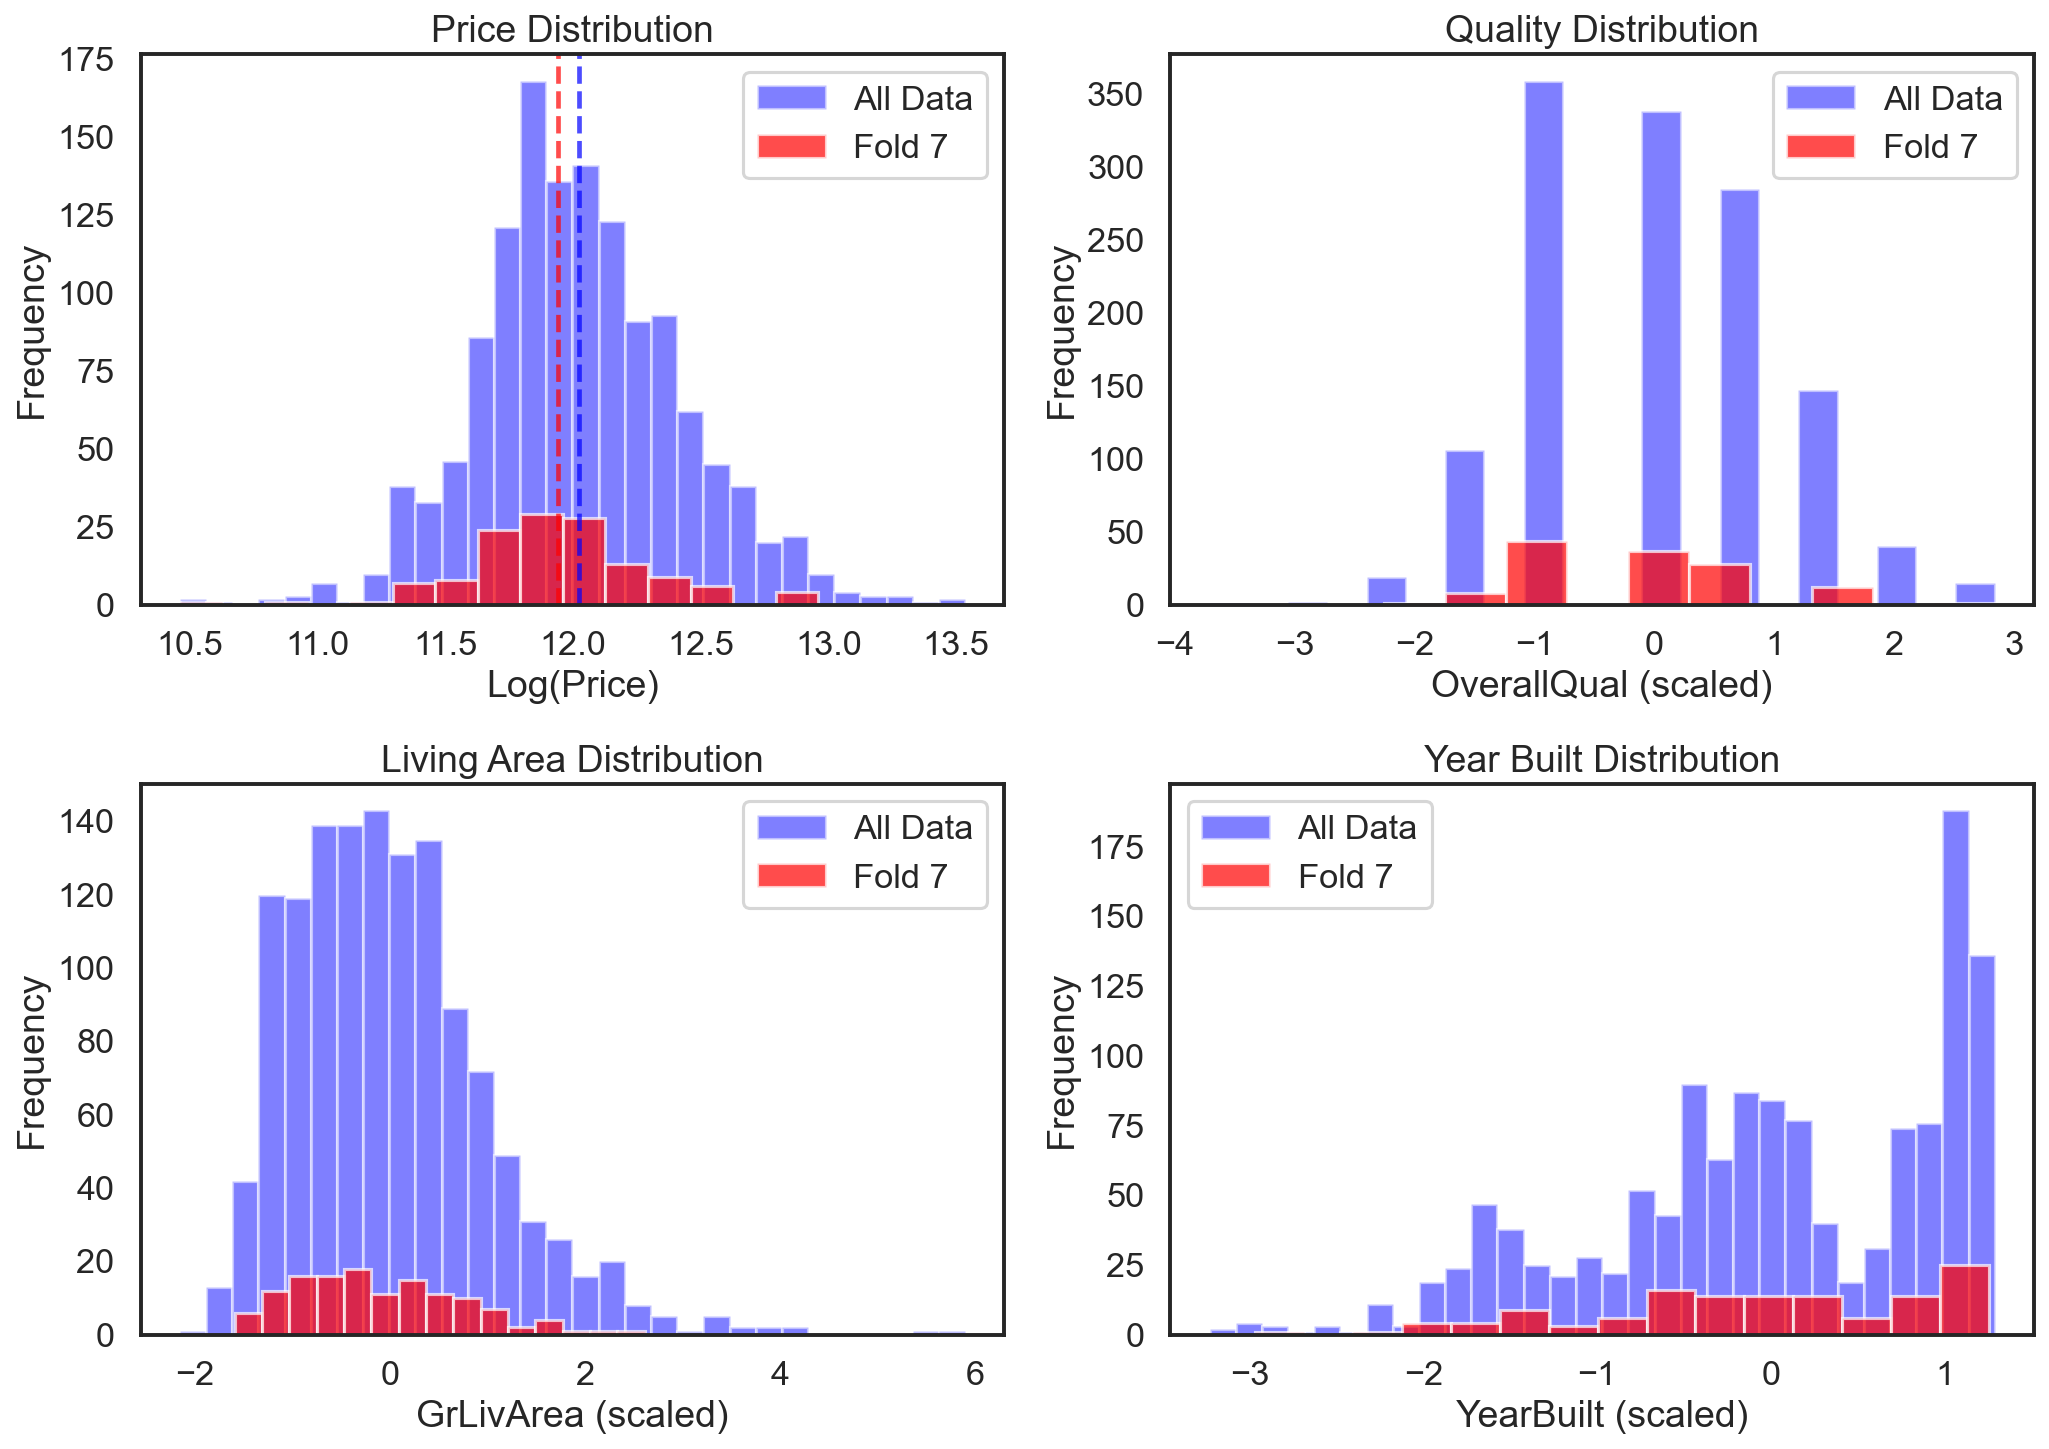


✓ Fold 7 contains disproportionately more low-quality, small, old houses
  This explains poor R² (0.68) - linear model breaks down for budget segment


In [134]:
# Visualize fold 7 distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Price distribution
axes[0, 0].hist(y_combined, bins=30, alpha=0.5, label='All Data', color='blue')
axes[0, 0].hist(y_fold7, bins=15, alpha=0.7, label='Fold 7', color='red')
axes[0, 0].set_xlabel('Log(Price)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Price Distribution')
axes[0, 0].legend()
axes[0, 0].axvline(y_combined.mean(), color='blue', linestyle='--', alpha=0.7)
axes[0, 0].axvline(y_fold7.mean(), color='red', linestyle='--', alpha=0.7)

# Quality distribution
axes[0, 1].hist(X_combined[:, 0], bins=20, alpha=0.5, label='All Data', color='blue')
axes[0, 1].hist(X_fold7[:, 0], bins=10, alpha=0.7, label='Fold 7', color='red')
axes[0, 1].set_xlabel('OverallQual (scaled)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Quality Distribution')
axes[0, 1].legend()

# Size distribution
axes[1, 0].hist(X_combined[:, 1], bins=30, alpha=0.5, label='All Data', color='blue')
axes[1, 0].hist(X_fold7[:, 1], bins=15, alpha=0.7, label='Fold 7', color='red')
axes[1, 0].set_xlabel('GrLivArea (scaled)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Living Area Distribution')
axes[1, 0].legend()

# Age distribution
axes[1, 1].hist(X_combined[:, 6], bins=30, alpha=0.5, label='All Data', color='blue')
axes[1, 1].hist(X_fold7[:, 6], bins=15, alpha=0.7, label='Fold 7', color='red')
axes[1, 1].set_xlabel('YearBuilt (scaled)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Year Built Distribution')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\n✓ Fold 7 contains disproportionately more low-quality, small, old houses")
print("  This explains poor R² (0.68) - linear model breaks down for budget segment")

In [135]:
print("=" * 60)
print("SHUFFLED K-FOLD CV (Better Distribution)")
print("=" * 60)

from sklearn.model_selection import KFold

# Regular KFold WITHOUT shuffle (original problem)
kf_no_shuffle = KFold(n_splits=10, shuffle=False, random_state=None)
no_shuffle_scores = cross_val_score(LinearRegression(), X_combined, y_combined,
                                    cv=kf_no_shuffle, scoring='r2')

# KFold WITH shuffle (better distribution)
kf_shuffle = KFold(n_splits=10, shuffle=True, random_state=42)
shuffle_scores = cross_val_score(LinearRegression(), X_combined, y_combined,
                                 cv=kf_shuffle, scoring='r2')

print(f"\nNo Shuffle 10-Fold CV:")
print(f"  Scores: {no_shuffle_scores}")
print(f"  Mean: {no_shuffle_scores.mean():.4f}, Std: {no_shuffle_scores.std():.4f}, Min: {no_shuffle_scores.min():.4f}")

print(f"\nWith Shuffle 10-Fold CV:")
print(f"  Scores: {shuffle_scores}")
print(f"  Mean: {shuffle_scores.mean():.4f}, Std: {shuffle_scores.std():.4f}, Min: {shuffle_scores.min():.4f}")

print(f"\n{'=' * 60}")
print("IMPROVEMENT:")
std_improvement = no_shuffle_scores.std() - shuffle_scores.std()
min_improvement = shuffle_scores.min() - no_shuffle_scores.min()

print(f"  Std reduction: {std_improvement:.4f} (lower is better)")
print(f"  Min fold improved: {min_improvement:+.4f}")

if shuffle_scores.min() > no_shuffle_scores.min():
    print(f"\n  ✓ Shuffling eliminated fold 7 problem")
    print(f"  Worst fold: {no_shuffle_scores.min():.4f} → {shuffle_scores.min():.4f}")

SHUFFLED K-FOLD CV (Better Distribution)

No Shuffle 10-Fold CV:
  Scores: [0.85766951 0.88103979 0.89388515 0.87136976 0.82475382 0.83943254
 0.67992431 0.83450004 0.86537575 0.84069957]
  Mean: 0.8389, Std: 0.0569, Min: 0.6799

With Shuffle 10-Fold CV:
  Scores: [0.86216189 0.84459674 0.85446891 0.85648967 0.87366359 0.78342447
 0.81470009 0.84168787 0.86297995 0.8290275 ]
  Mean: 0.8423, Std: 0.0256, Min: 0.7834

IMPROVEMENT:
  Std reduction: 0.0313 (lower is better)
  Min fold improved: +0.1035

  ✓ Shuffling eliminated fold 7 problem
  Worst fold: 0.6799 → 0.7834


In [136]:
print("=" * 60)
print("FINAL MODEL EVALUATION")
print("=" * 60)

# Final model: 6 features (no FullBath), trained on train+val
print("\nFinal Model Specifications:")
print(f"  Features: {feature_names_final}")
print(f"  Learning rate: 0.01")
print(f"  Iterations: 1000")
print(f"  Method: Gradient Descent")

# Already trained model_final, evaluate on all sets
train_r2_final = model_final.score(X_final_train, y_final_train)
test_r2_final = model_final.score(X_test_nb_scaled, y_test)

# CV with shuffled 10-fold (already computed)
cv_mean = shuffle_scores.mean()
cv_std = shuffle_scores.std()

# Calculate test set metrics
y_test_pred_final = model_final.predict(X_test_nb_scaled)
from sklearn.metrics import mean_squared_error, mean_absolute_error

test_mse = mean_squared_error(y_test, y_test_pred_final)
test_mae = mean_absolute_error(y_test, y_test_pred_final)
test_rmse = np.sqrt(test_mse)

print(f"\n{'=' * 60}")
print("PERFORMANCE METRICS:")
print(f"{'=' * 60}")

print(f"\nR² Scores:")
print(f"  Training (train+val): {train_r2_final:.4f}")
print(f"  Cross-Validation:     {cv_mean:.4f} ± {cv_std:.4f}")
print(f"  Test:                 {test_r2_final:.4f}")

print(f"\nTest Set Errors (log scale):")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE:  {test_mae:.4f}")

print(f"\nModel Weights:")
for feat, weight in zip(feature_names_final, weights_final):
    print(f"  {feat:<15} {weight:>8.4f}")
print(f"  Bias:           {model_final.bias:>8.4f}")

print(f"\n{'=' * 60}")
print("MODEL COMPARISON:")
print(f"{'=' * 60}")
print(f"  Original (7 feat, FullBath):  Test R²={test_r2:.4f}")
print(f"  Final (6 feat, no FullBath):  Test R²={test_r2_final:.4f}")
print(f"  Improvement:                  {test_r2_final - test_r2:+.4f}")

print(f"\n✓ FINAL MODEL: 6 features, Test R²={test_r2_final:.4f}")

FINAL MODEL EVALUATION

Final Model Specifications:
  Features: ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'YearBuilt']
  Learning rate: 0.01
  Iterations: 1000
  Method: Gradient Descent

PERFORMANCE METRICS:

R² Scores:
  Training (train+val): 0.8447
  Cross-Validation:     0.8423 ± 0.0256
  Test:                 0.8718

Test Set Errors (log scale):
  RMSE: 0.1484
  MAE:  0.1048

Model Weights:
  OverallQual       0.1262
  GrLivArea         0.1394
  GarageCars        0.0462
  TotalBsmtSF       0.0602
  1stFlrSF          0.0245
  YearBuilt         0.0810
  Bias:            12.0278

MODEL COMPARISON:
  Original (7 feat, FullBath):  Test R²=0.8714
  Final (6 feat, no FullBath):  Test R²=0.8718
  Improvement:                  +0.0005

✓ FINAL MODEL: 6 features, Test R²=0.8718


In [137]:
### Day 8: Elastic Net + Interaction Feature

# Import Elastic Net
import sys
sys.path.append('../src')

from linear_regression import ElasticNetScratch

print("✓ Elastic Net imported")

✓ Elastic Net imported
